<font size="9">JUNO PELT & WALT signals</font><br>
<hr>

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import pandas as pd

# Support for performance analysis of RTApp workloads
from trace_analysis import TraceAnalysis

# Support for trace events analysis
from trace import Trace
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test setup

In [3]:
with open(os.path.join('./', 'juno_r2.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

01:17:27  INFO    : LITTLE cluster max capacity: 593


# Configuration

In [4]:
workload='bbench_with_audio'
spec_id='mp_option_walt'
workload_id='w01'
run='1'
#/home/chrred01/work/juno/eas_walt_juno/wlauto_compare/walt_trace_all/t-rex_2.7.0_HD_off_mp_option_walt_b14_1

test_dir = '../../../eas_walt_juno/wlauto_compare/walt_trace_all/{}_{}_{}'.format(workload, spec_id, workload_id)
run_dir = '{}_{}/'.format(test_dir, run)
#platform_json = '{}/platform.json'.format(test_dir)
platform_json = './juno_r2.json'
trace_file = '{}/trace.dat'.format(run_dir)

# Load platform description data
with open(platform_json, 'r') as fh:
    platform = json.load(fh)

# Load Trace data
events = [
    'sched_load_avg_task',
    'sched_load_avg_cpu',
    'sched_switch',
    'sched_overutilized',
    'sched_energy_diff',
    'cpu_frequency'
]
trace = Trace(platform, run_dir, events)
ta = TraceAnalysis(trace, platform)


01:17:28  INFO    : Parsing FTrace format...


Maximum estimated system energy: 1734


01:17:59  INFO    : Collected events spans a 147.278 [s] time interval
01:17:59  INFO    : Overutilized time: 17.555490 [s] (11.920% of trace time)
01:17:59  INFO    : Set plots time range to (0.000000, 147.278141)[s]


In [5]:
# useful capacity functions
df = trace.df('cpu_frequency')
df_big = df[df['cpu']==1].copy()
df_little = df[df['cpu']==0].copy()
max_little_cap = platform['nrg_model']['little']['cpu']['cap_max']
max_big_cap = platform['nrg_model']['big']['cpu']['cap_max']
max_little_freq = max(platform['freqs']['little'])
max_big_freq = max(platform['freqs']['big'])
print 'Maximums: little cap {} @ {}, big cap {} @ {}'.format(max_little_cap, max_little_freq, max_big_cap, max_big_freq)
df_big[['capacity']] = df_big[['frequency']].apply(lambda x: (max_big_cap * x)/max_big_freq)
df_little[['capacity']] = df_little[['frequency']].apply(lambda x: (max_little_cap * x)/max_little_freq)

# what is the capacity of the big CPU at a given time
def getBigCapacity(time):
    global df_big
    return df_big.iloc[df_big.index.get_loc(time, method='pad')]['capacity']

# what is the capacity of the little CPU at a given time
def getLittleCapacity(time):
    global df_little
    return df_little.iloc[df_little.index.get_loc(time, method='pad')]['capacity']

def getCPUCapacity(cpu, time):
    global platform
    if cpu in platform['clusters']['big']:
        return getBigCapacity(time)
    else:
        return getLittleCapacity(time)

# what is the frequency of the big CPU at a given time
def getBigFreq(time):
    global df_big
    return df_big.iloc[df_big.index.get_loc(time, method='pad')]['frequency']

# what is the frequency of the little CPU at a given time
def getLittleFreq(time):
    global df_little
    return df_little.iloc[df_little.index.get_loc(time, method='pad')]['frequency']

def getCPUFreq(cpu, time):
    global platform
    if cpu in platform['clusters']['big']:
        return getBigFreq(time)
    else:
        return getLittleFreq(time)


Maximums: little cap 593 @ 950000, big cap 1023 @ 1200000


In [ ]:
# lookup what the CPU load is
cpus_df = trace.df('sched_load_avg_cpu').copy()
cpu_dfs=range(0,5)
for cpu in range(0,5):
    cpu_dfs[cpu] = cpus_df[cpus_df['cpu']==cpu].copy()

In [ ]:
# lookup in cpu load signals what a given CPU load is recorded as at any given time
def getCPUUtil(cpu, time):
    global platform
    global cpu_dfs
    return cpu_dfs[cpu].iloc[cpu_dfs[cpu].index.get_loc(time, method='pad')]['util_avg']

def make_cpuUtil_trace(row):
    time=row.name
    cpu=row['cpu']
    util=0
    try:
        util=getCPUUtil(cpu, time)
    except:
        pass
    return util
    
def make_capacity_trace(row):
    time=row.name
    cpu=row['cpu']
    capacity=0
    try:
        capacity=getCPUCapacity(cpu, time)
    except:
        pass
    return capacity

def make_change_possible_trace(row):
    # diff is walt_signal - pelt_signal
    diff = row['load_avg']-row['util_avg']
    # if diff is +ve, then walt was bigger, check to see if we went over 80% threshold
    if (row['cpu_util'] + diff) > 0.8 * row['capacity']:
        return 1000
    else:
        return 0
        
  

In [33]:
# add synthetic signals for all tasks
cap_df = trace.df('sched_load_avg_task').copy()
cap_df['capacity']=cap_df.apply(make_capacity_trace, axis=1)
cap_df['cpu_util']=cap_df.apply(make_cpuUtil_trace, axis=1)
cap_df['overload']=cap_df.apply(make_change_possible_trace, axis=1)

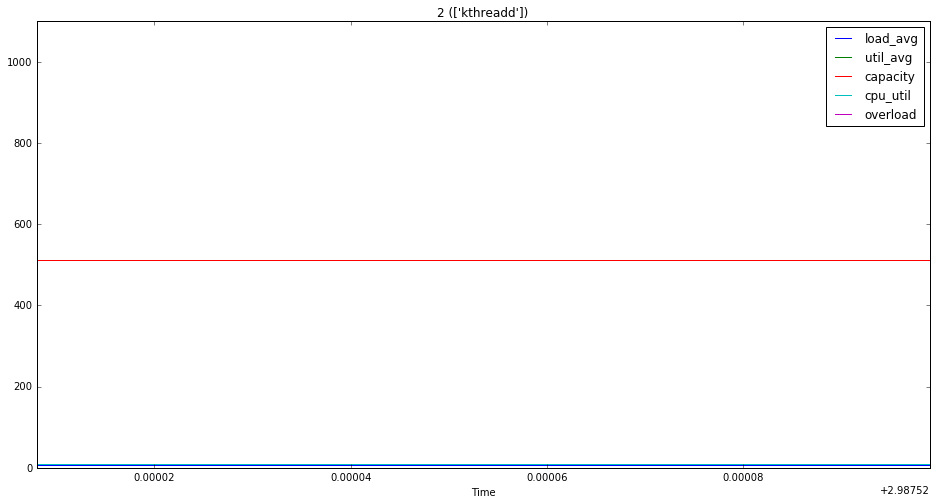

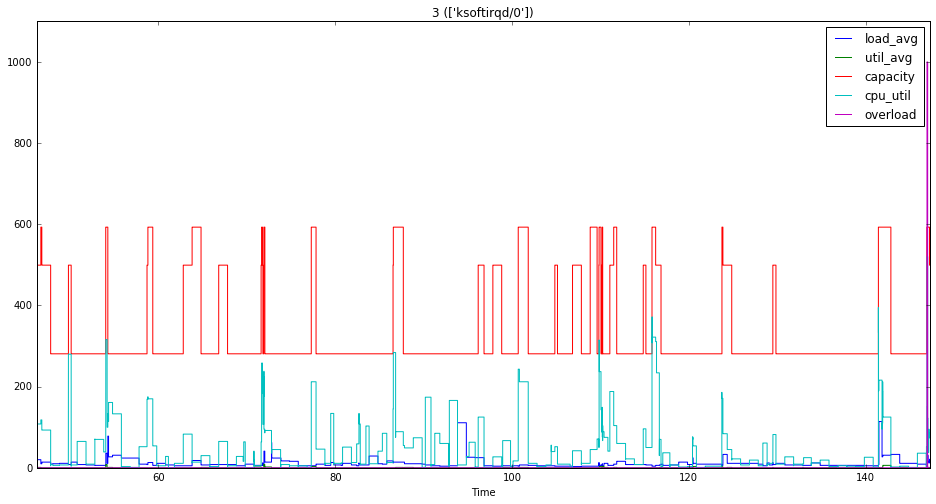

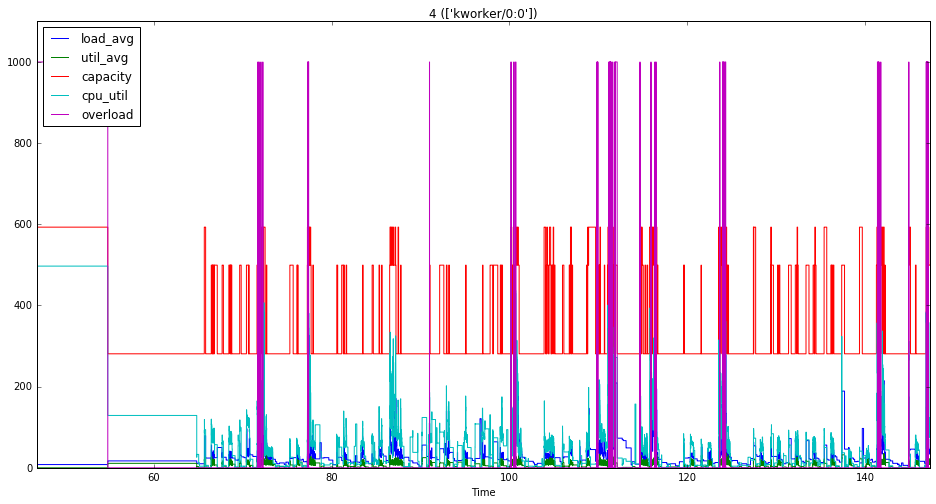

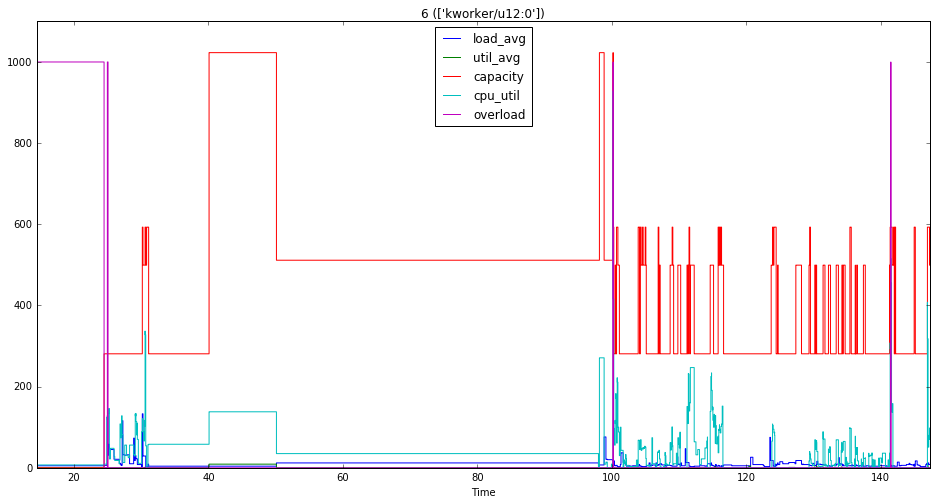

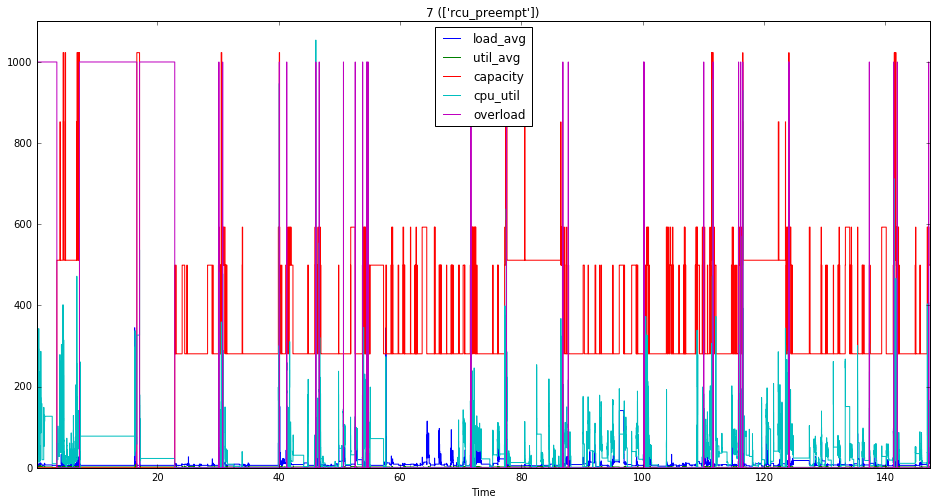

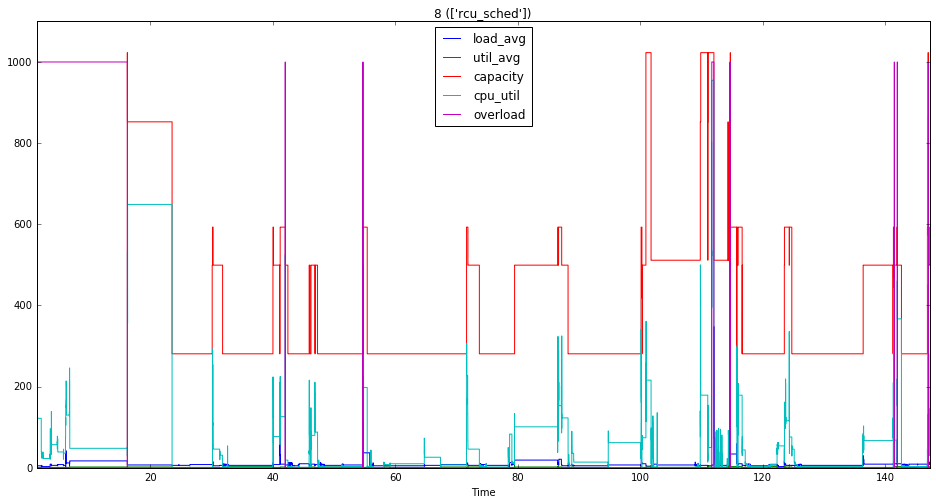

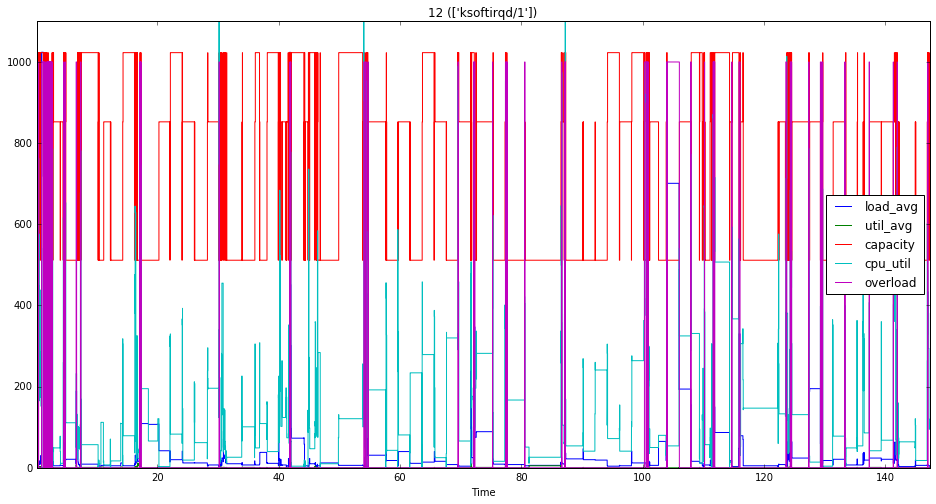

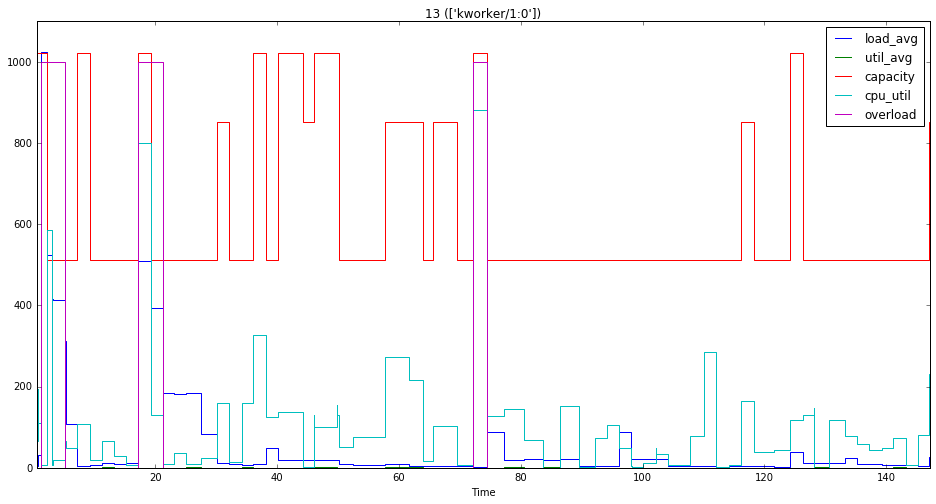

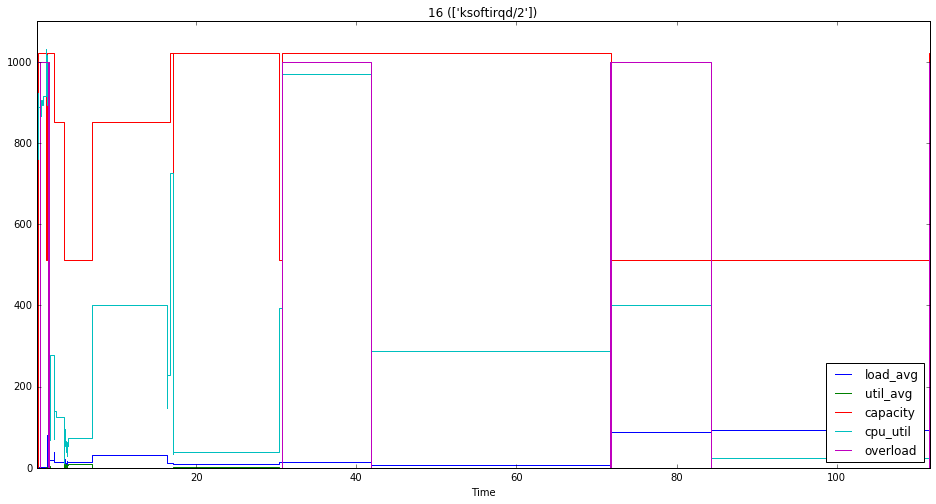

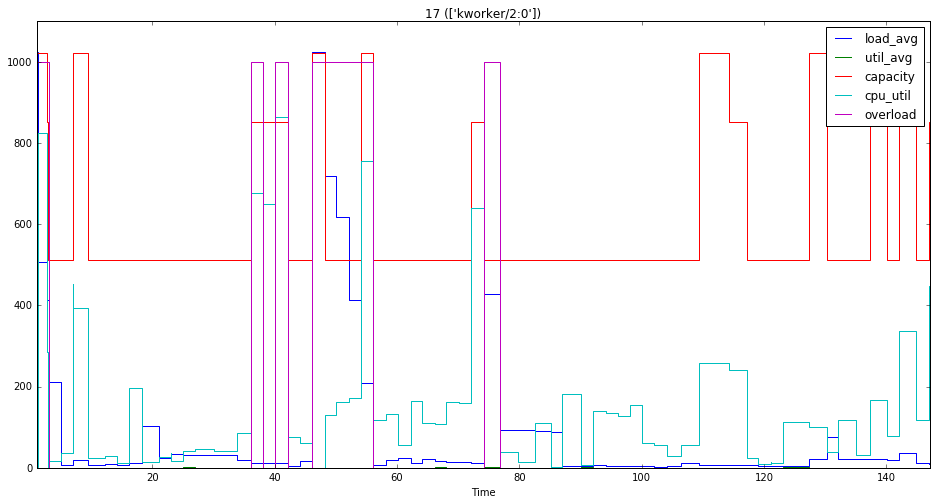

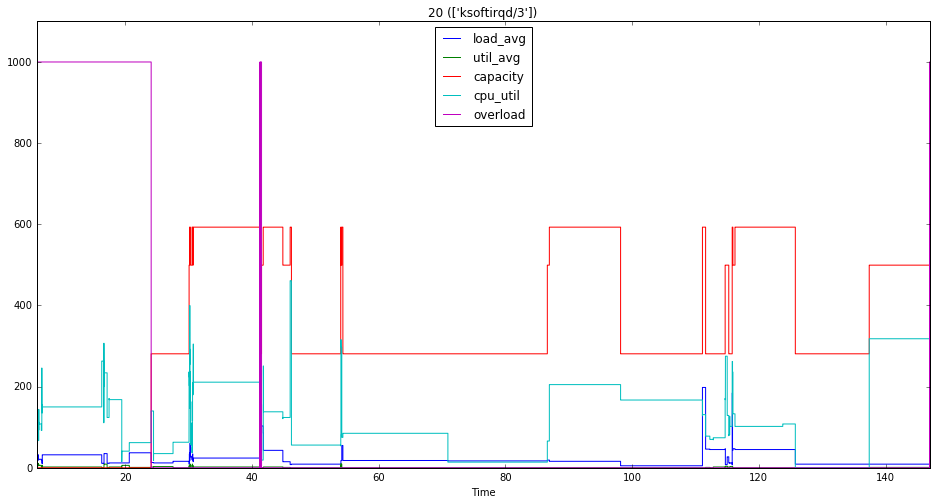

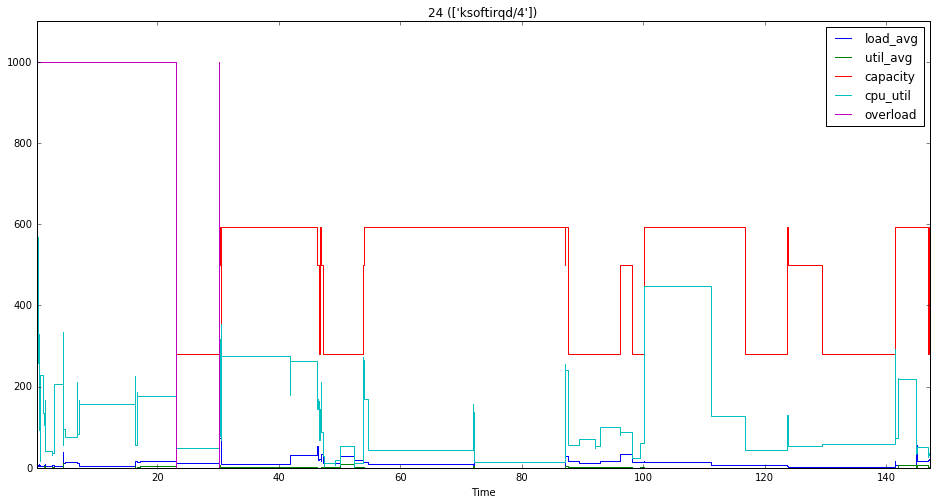

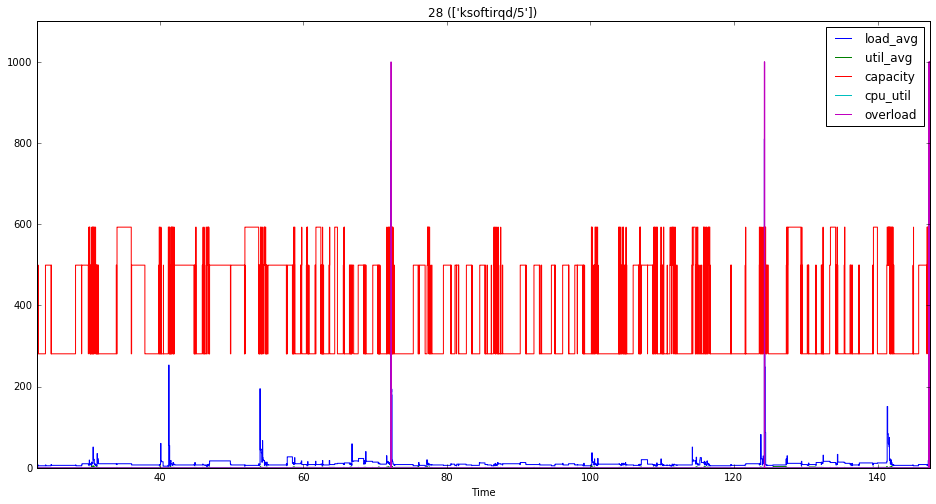

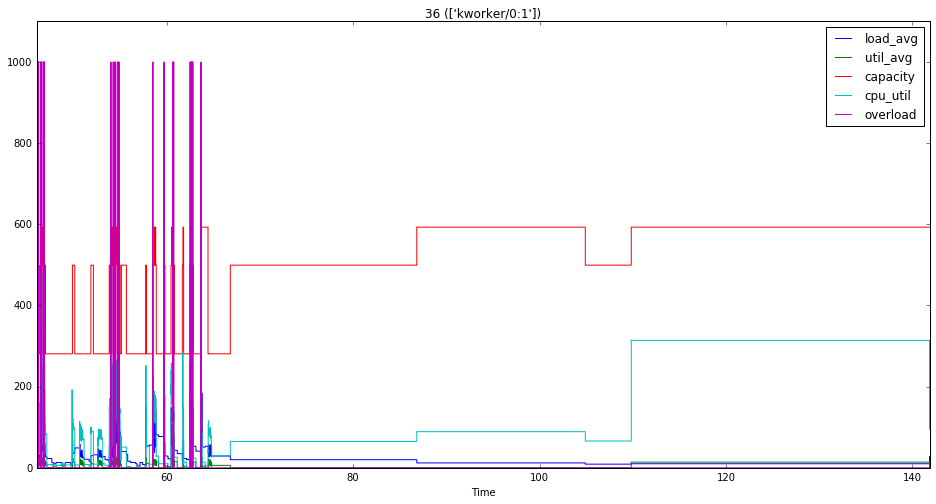

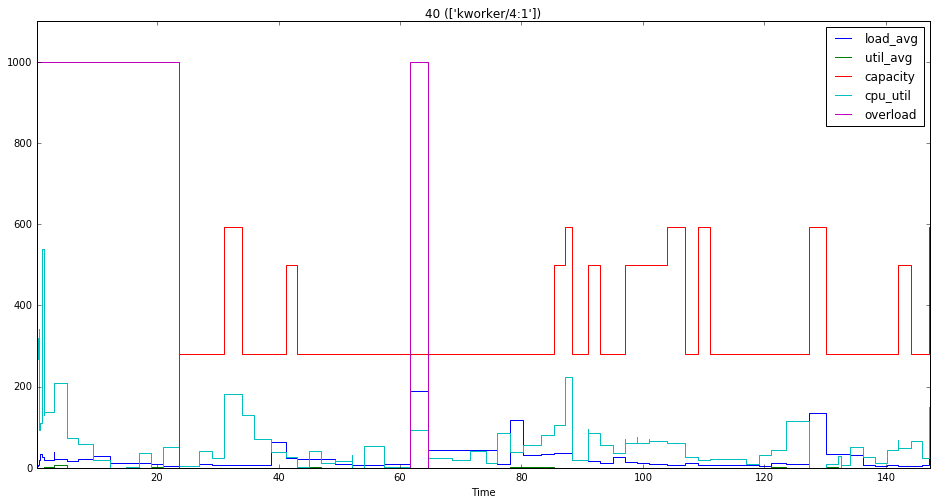

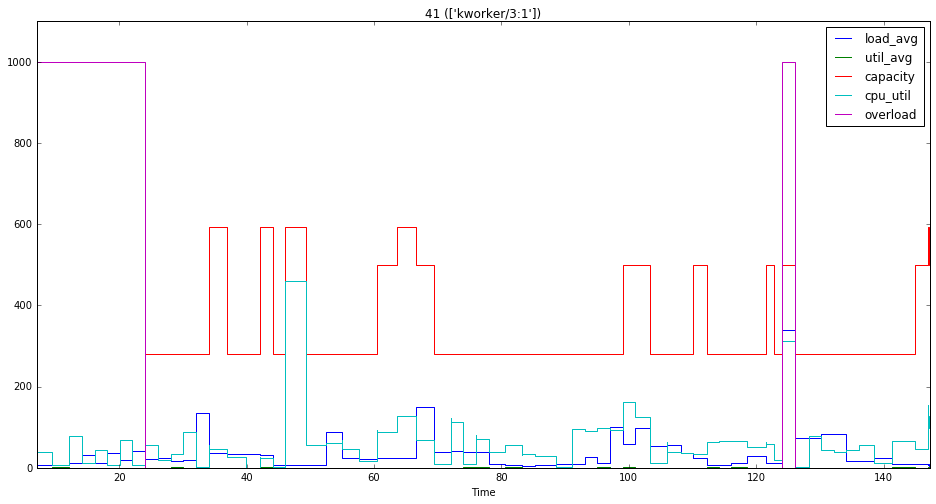

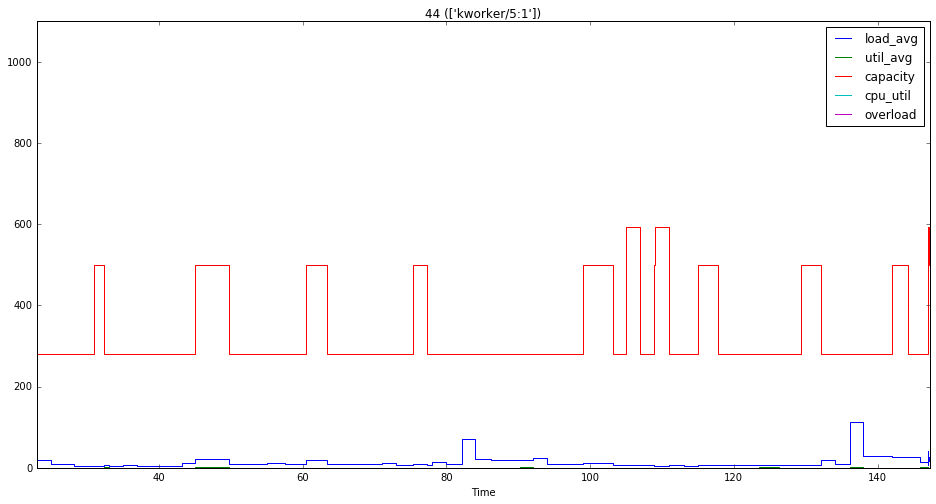

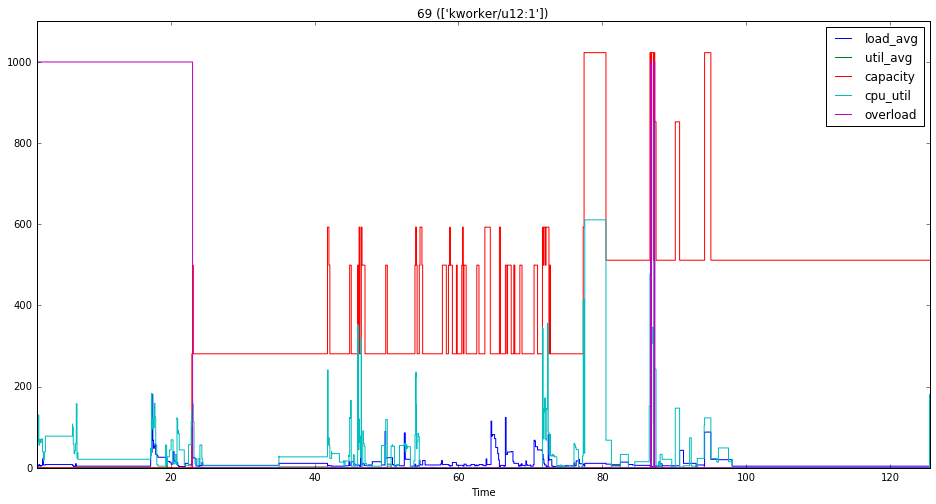

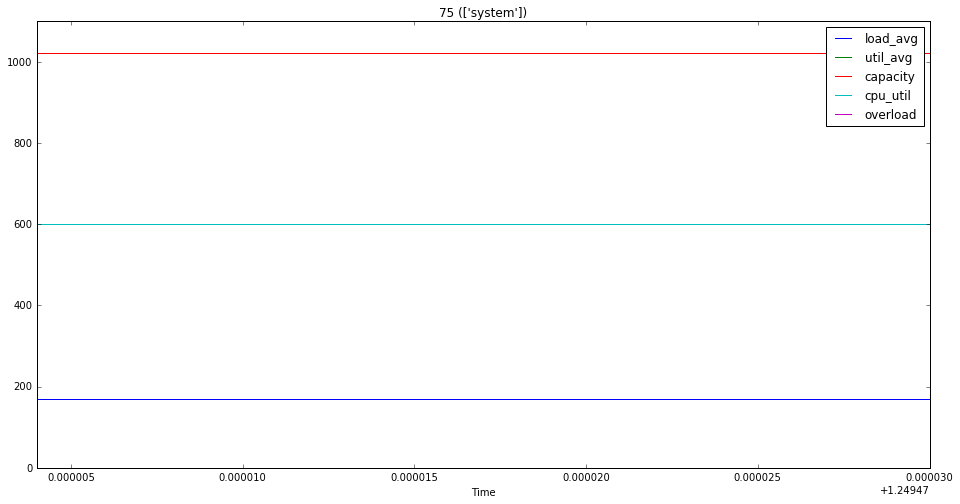

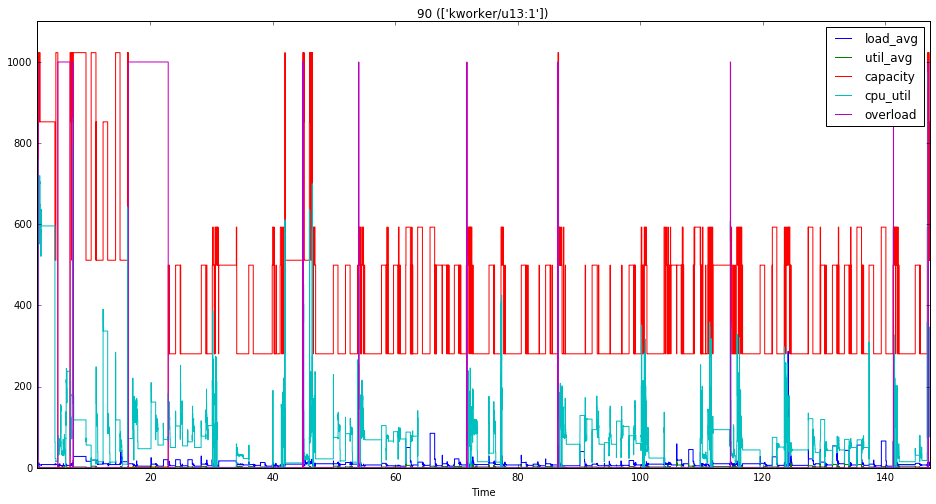

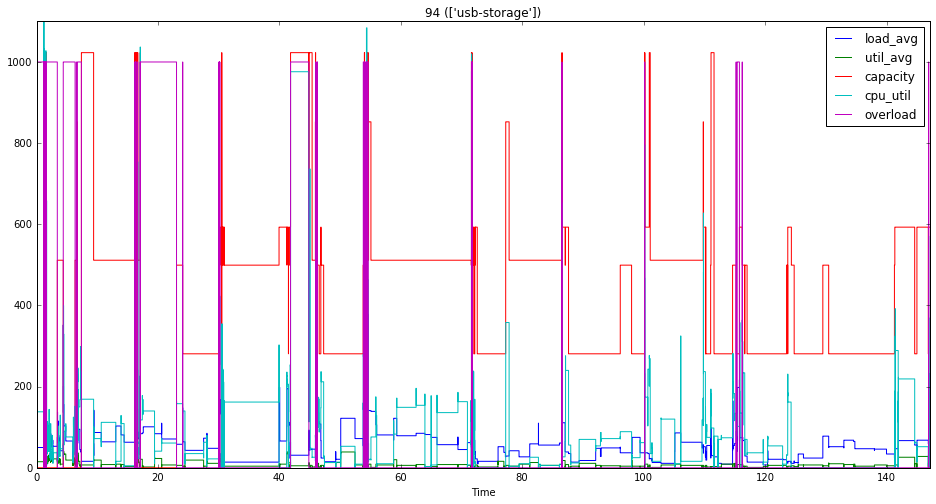

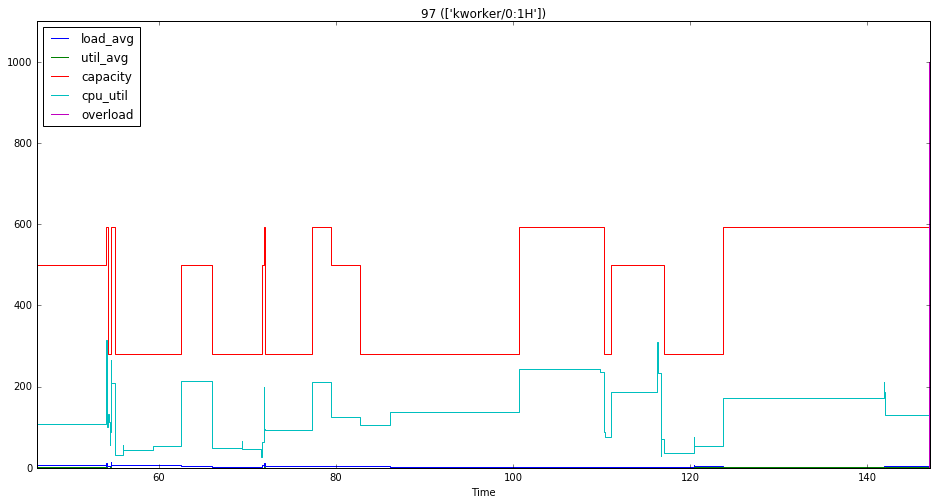

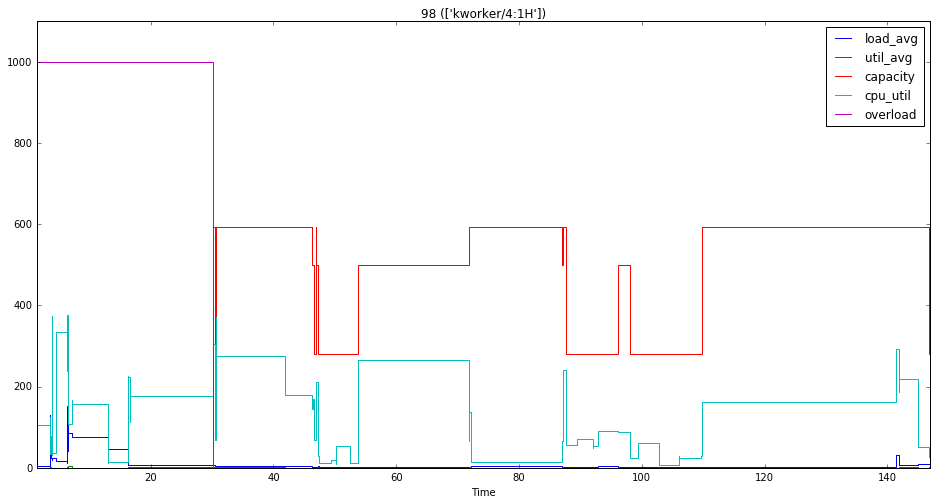

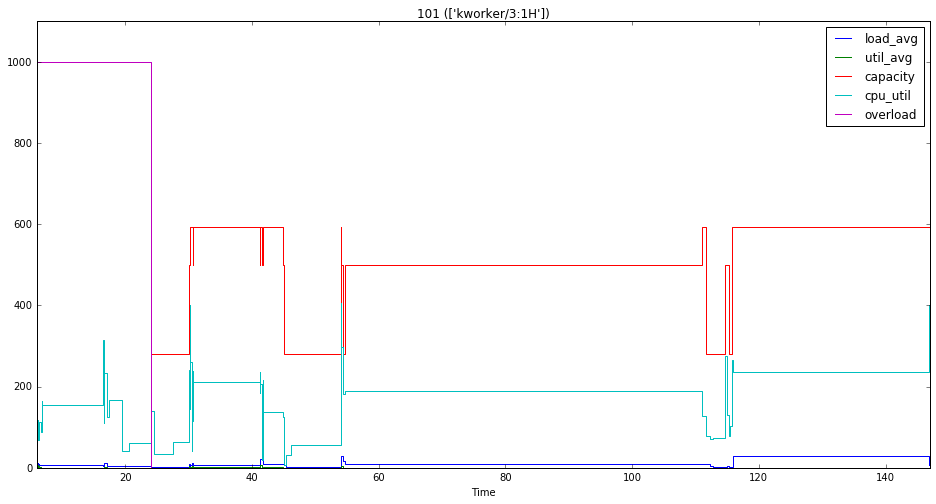

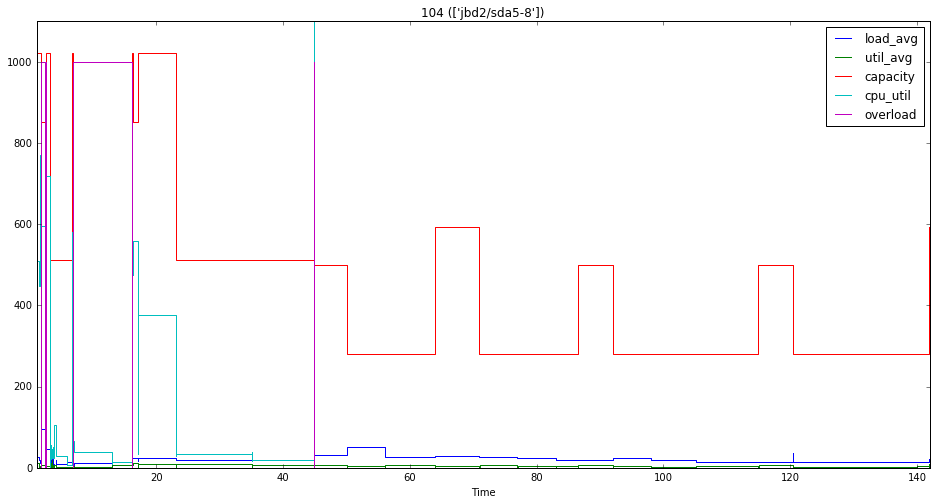

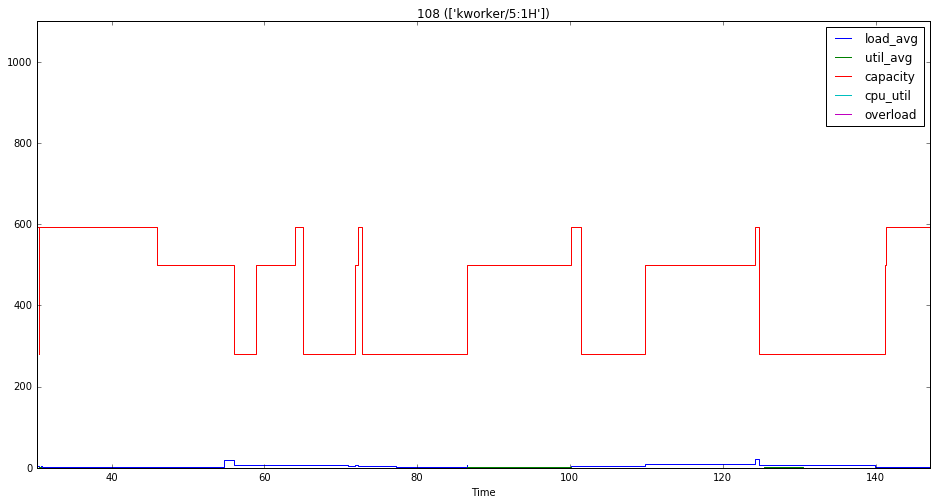

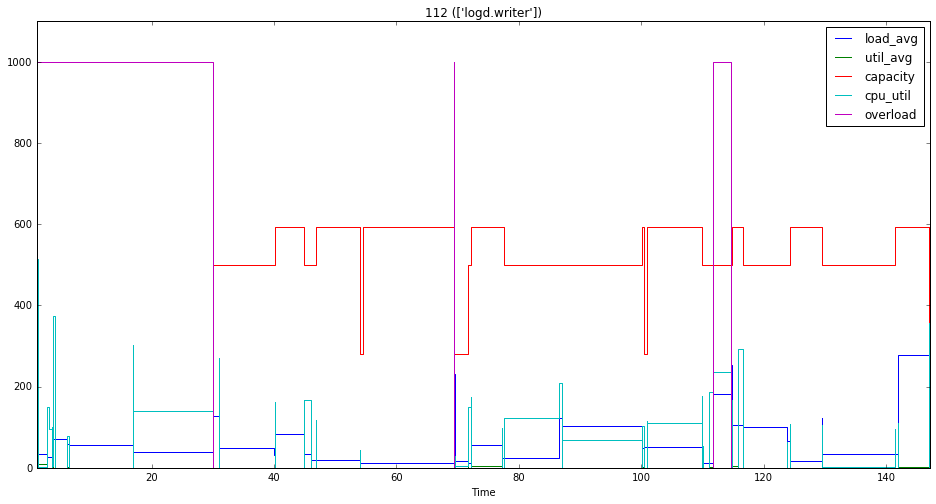

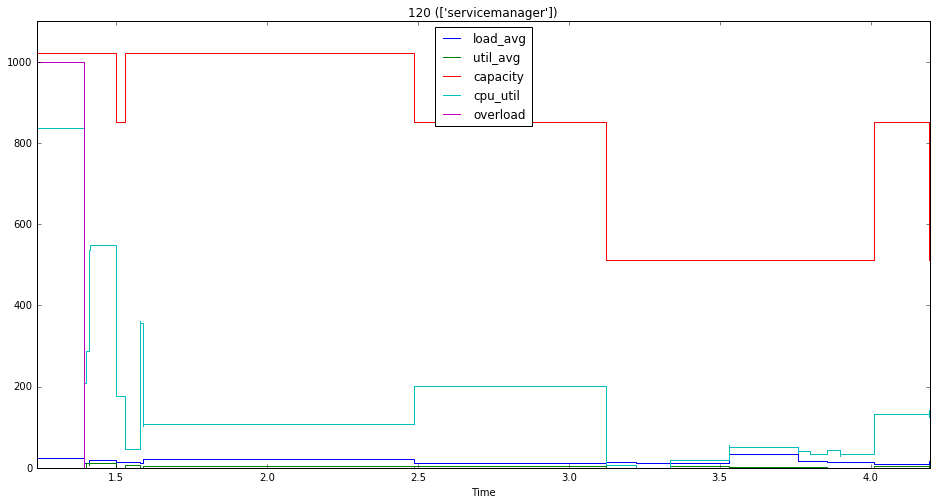

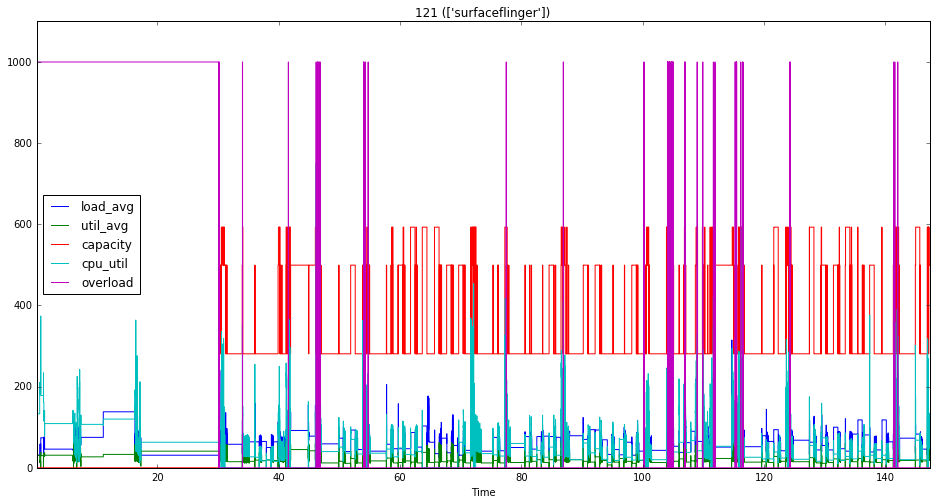

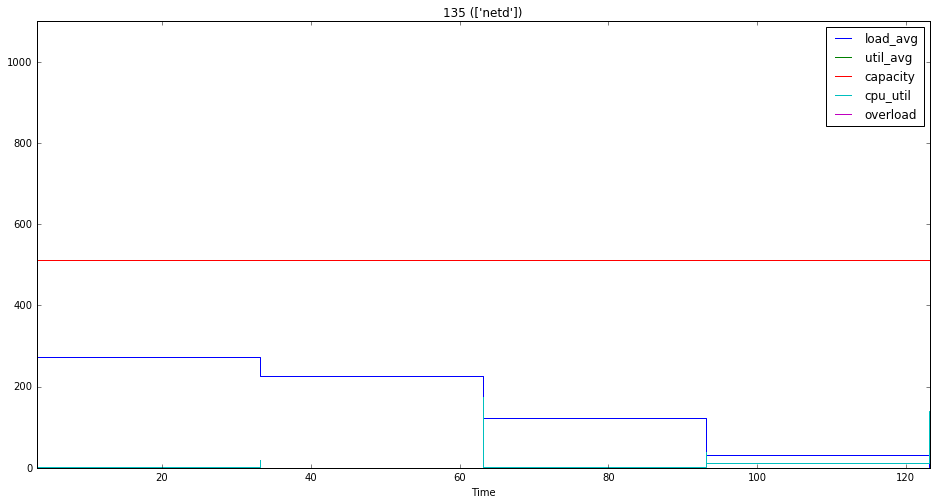

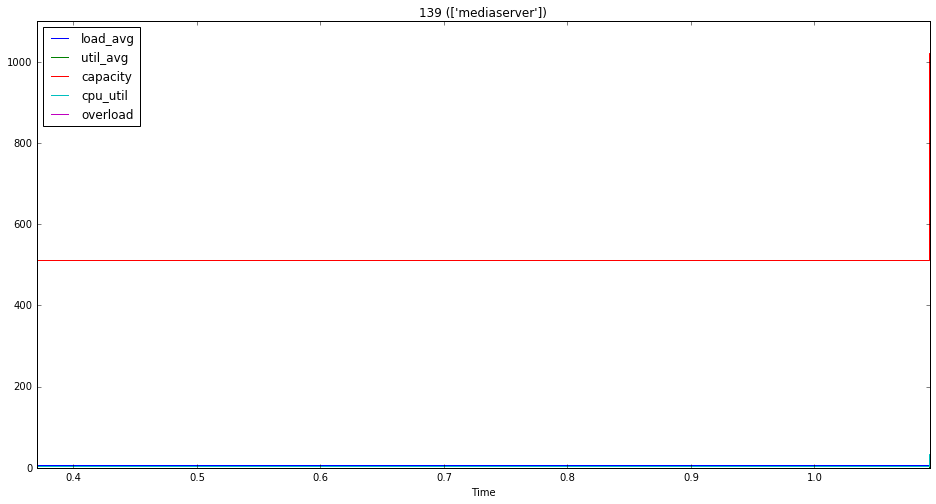

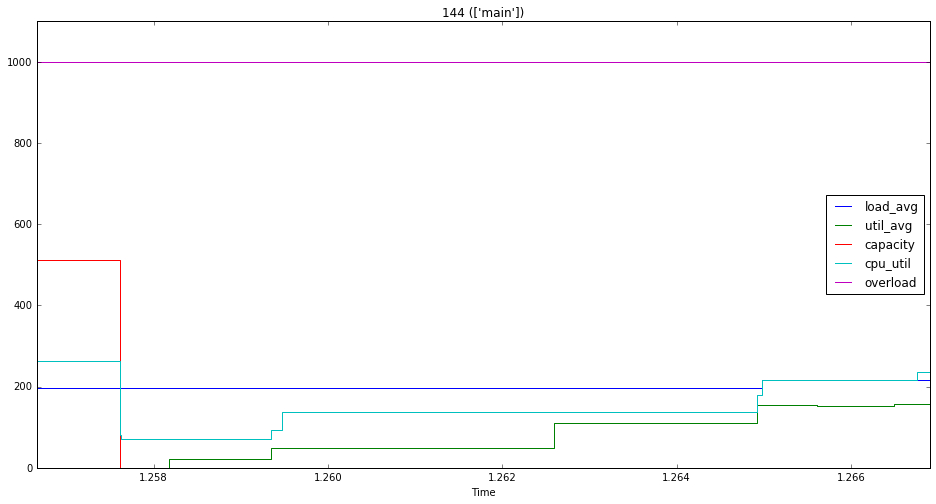

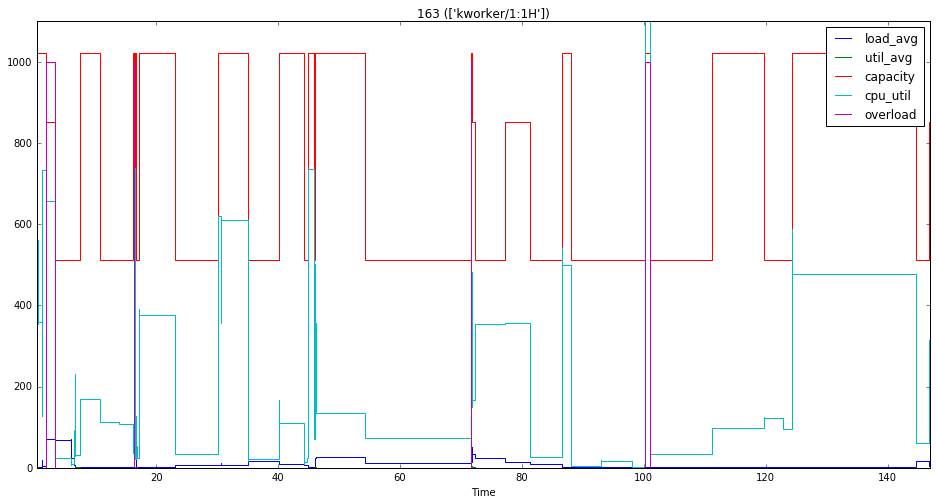

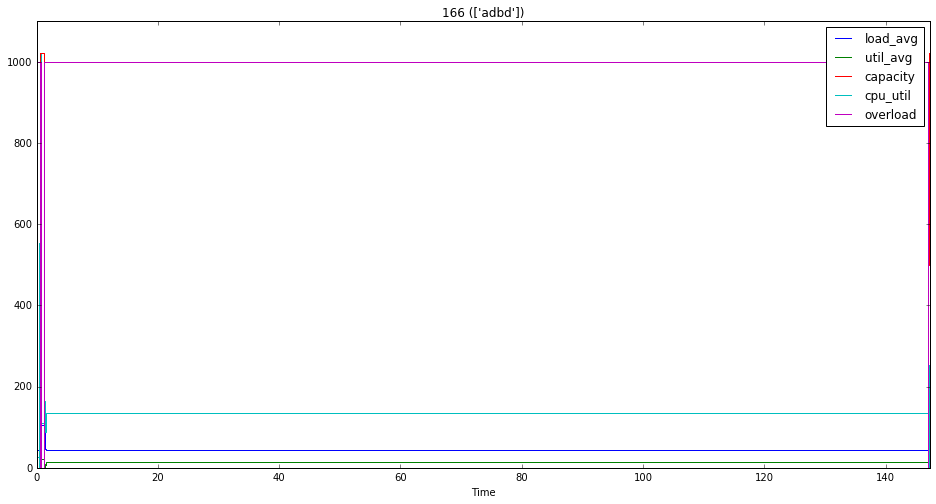

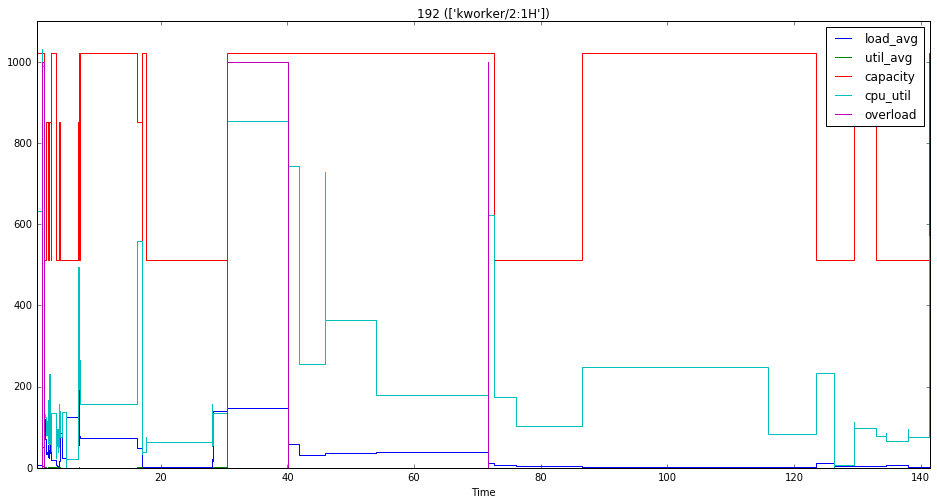

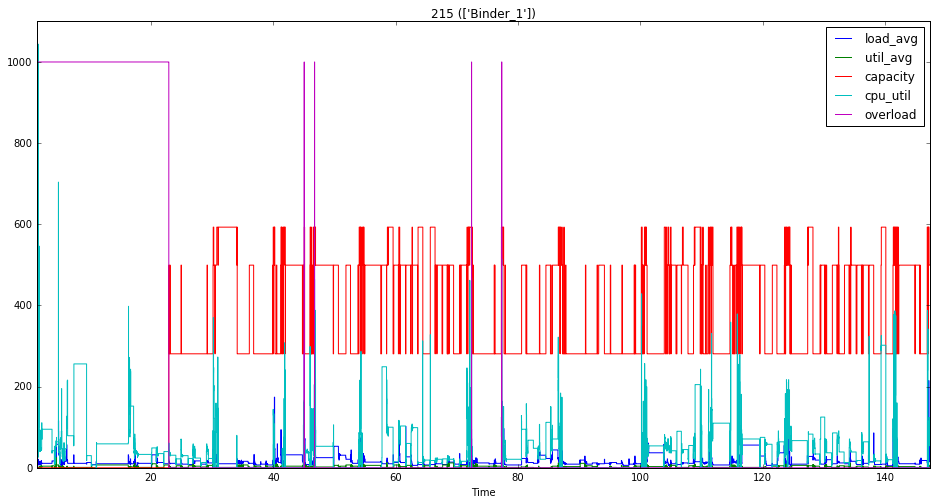

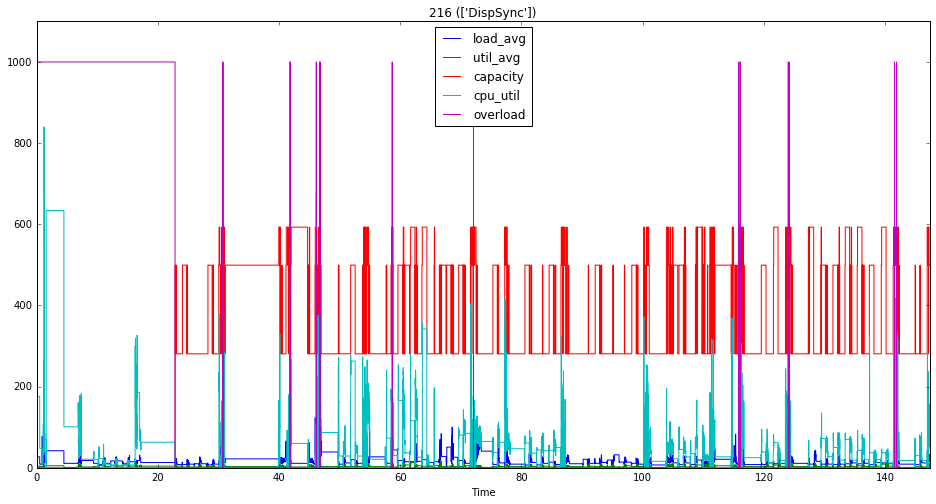

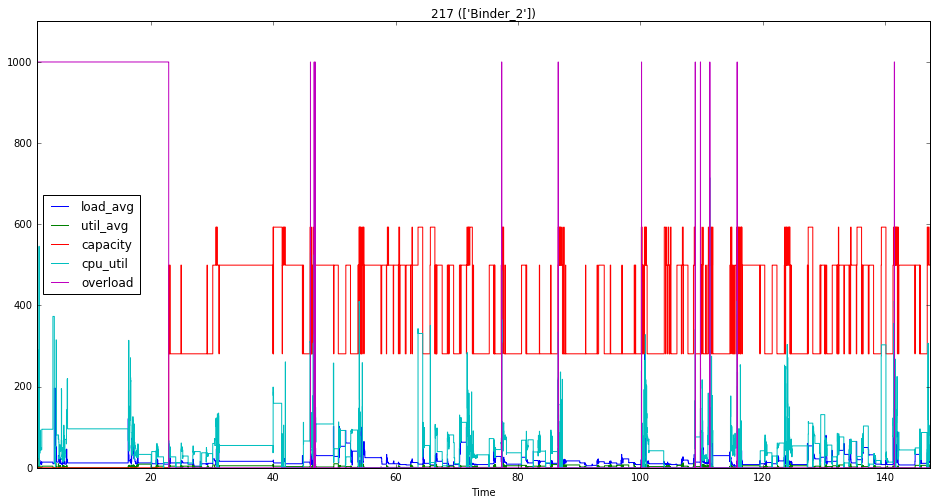

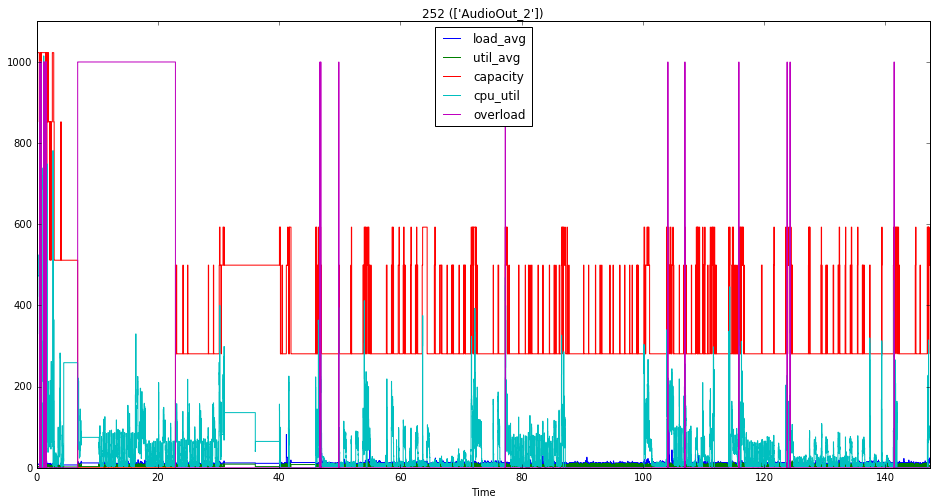

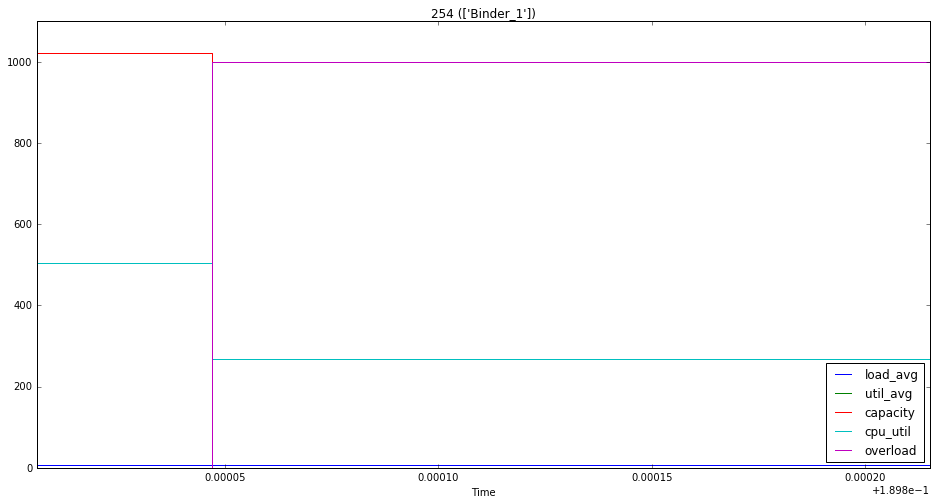

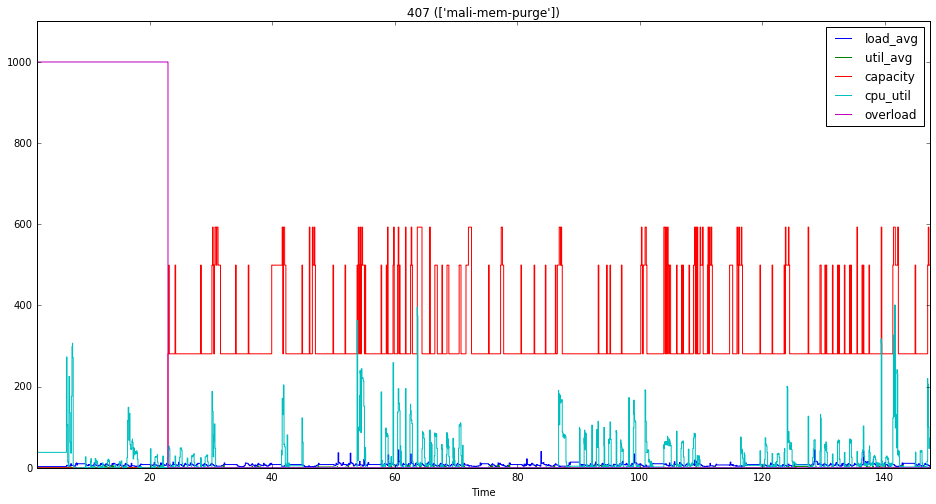

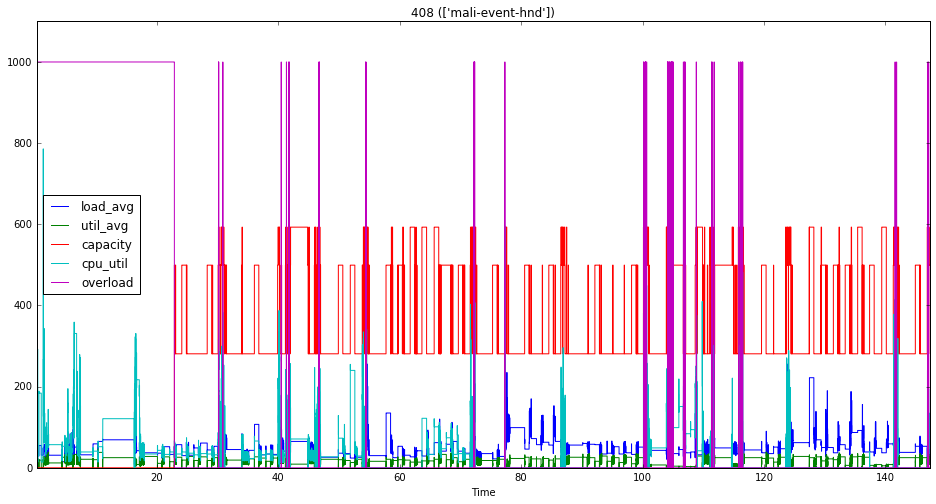

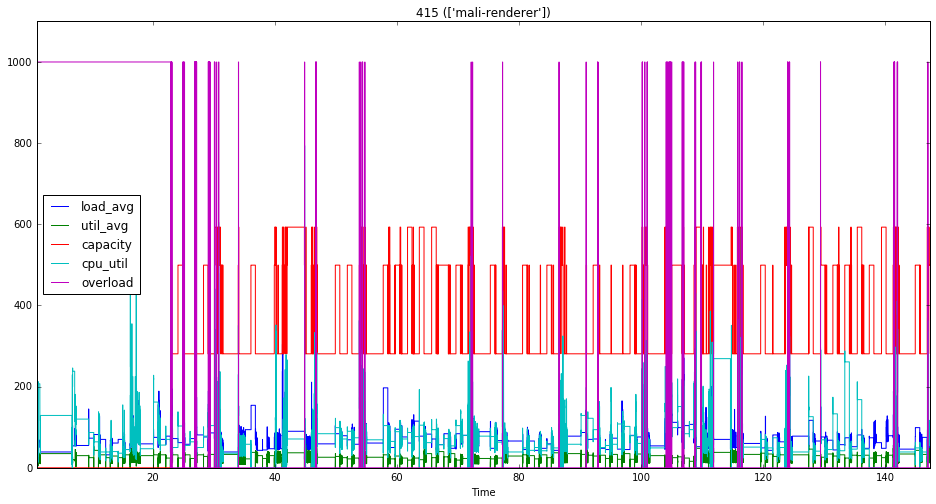

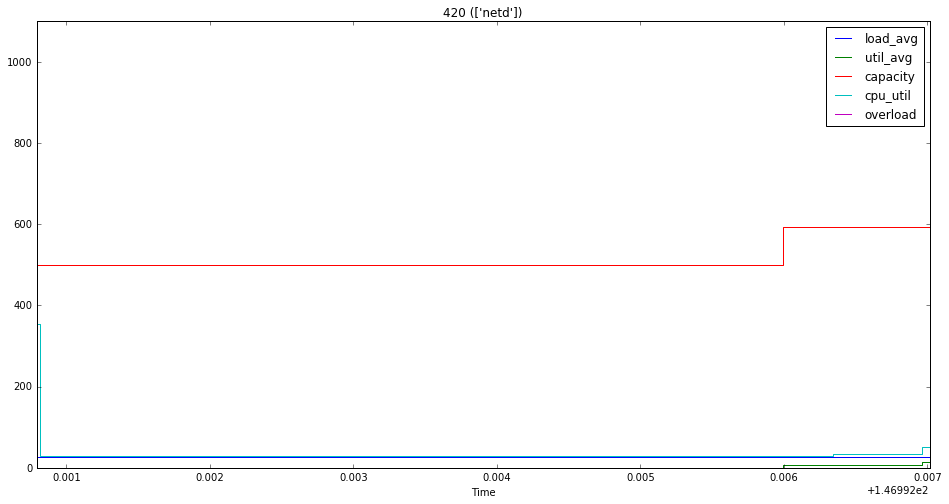

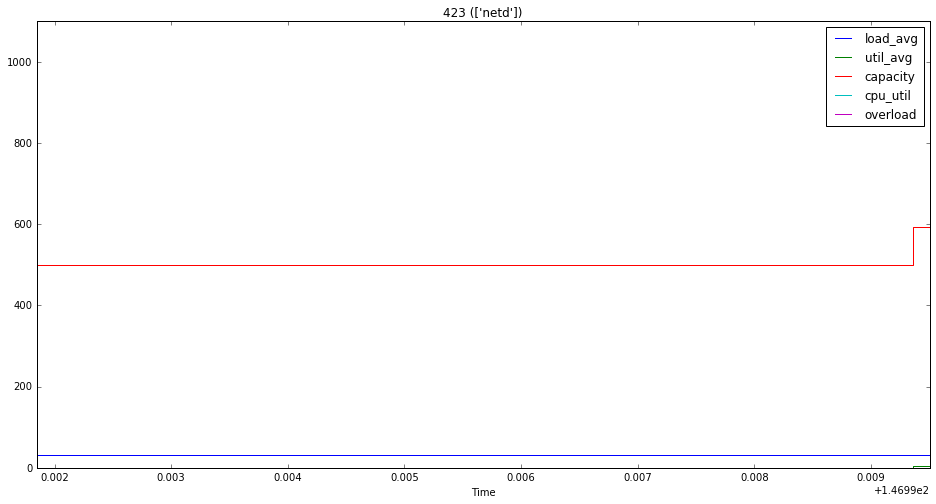

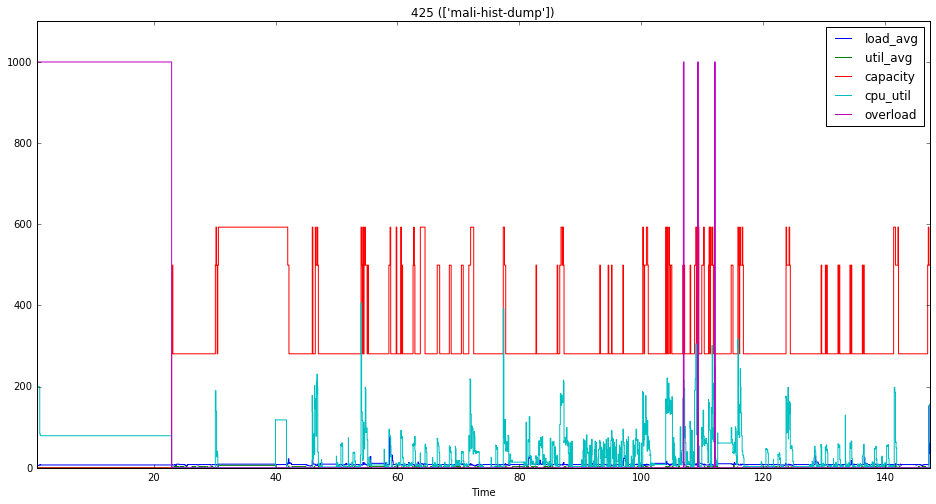

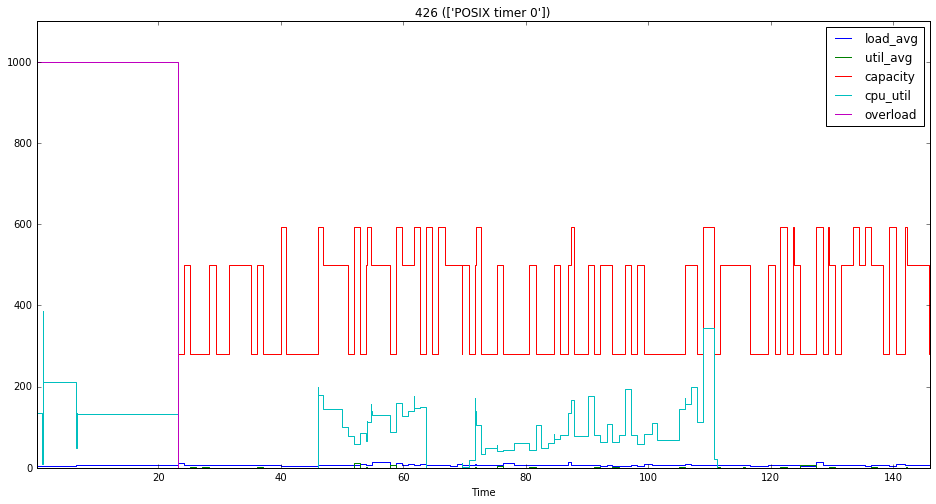

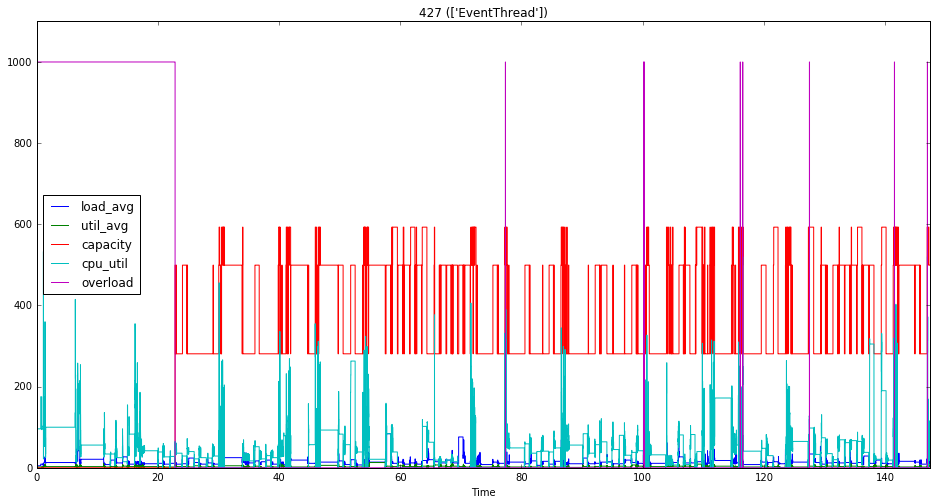

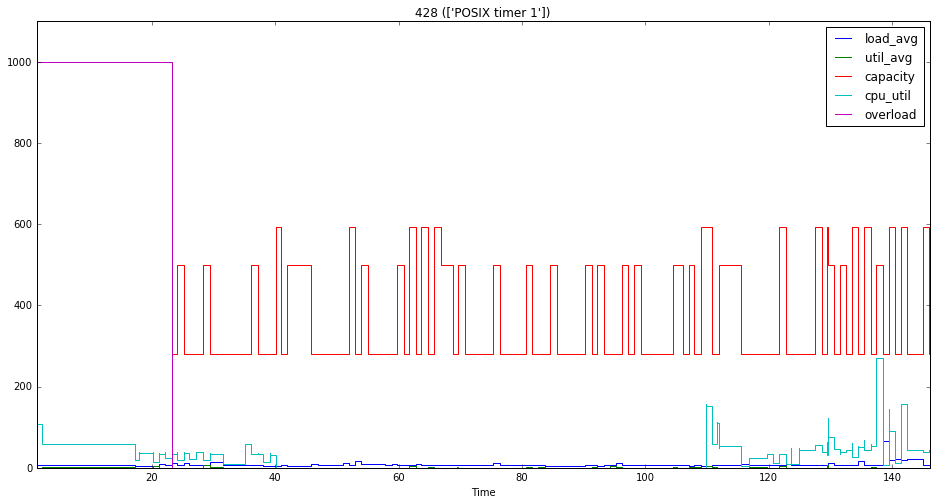

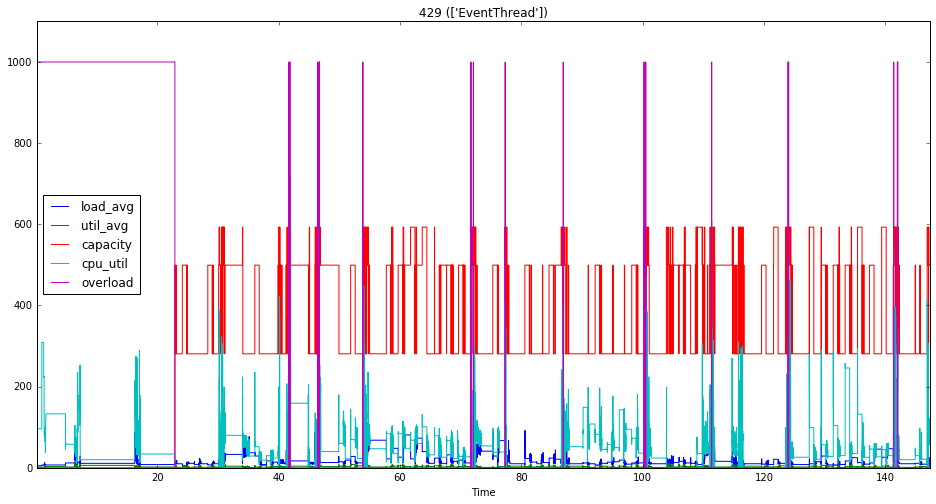

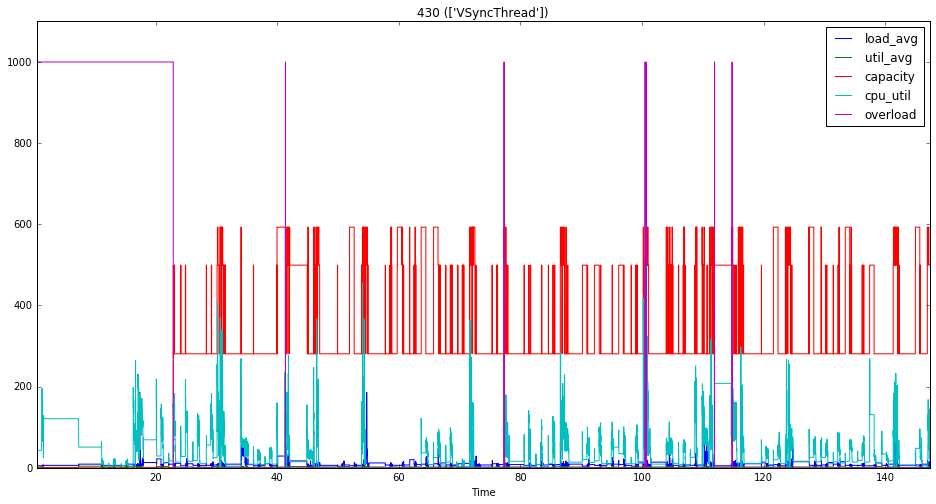

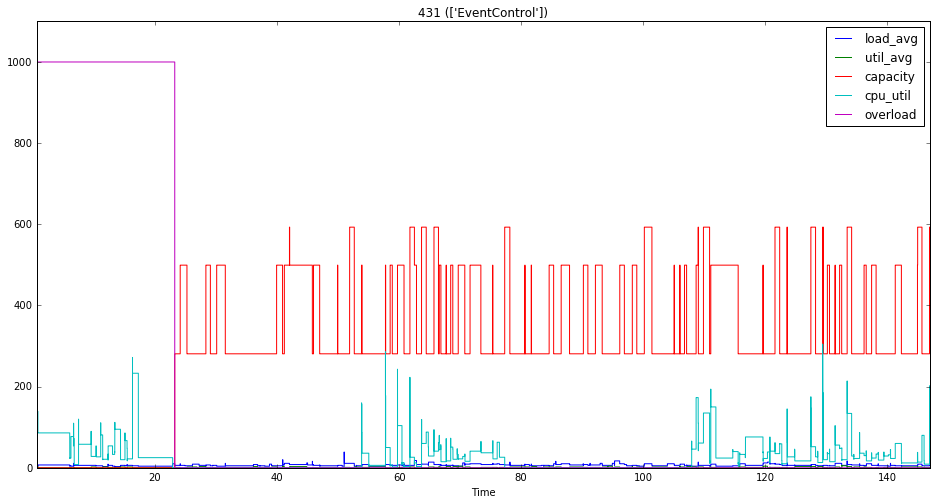

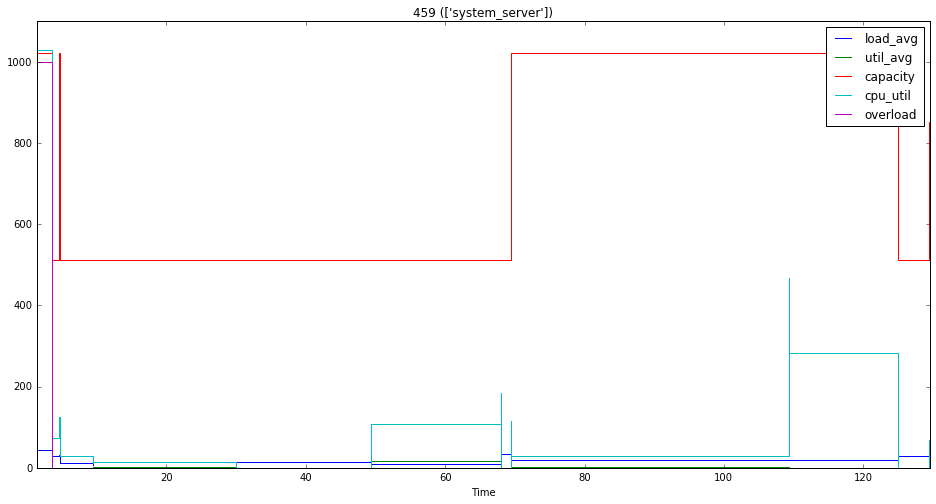

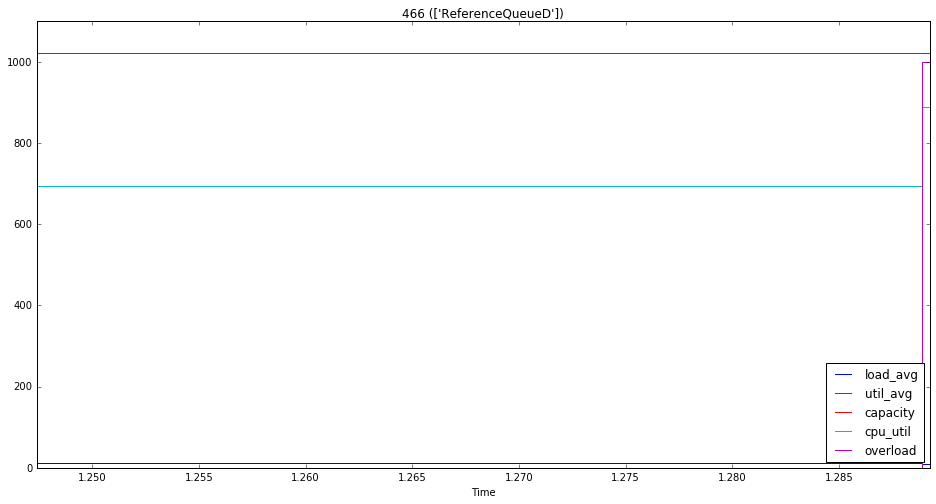

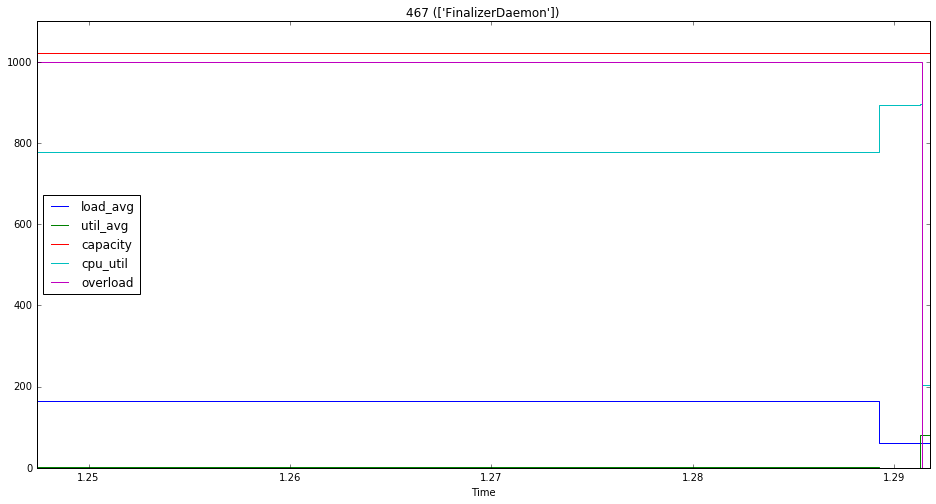

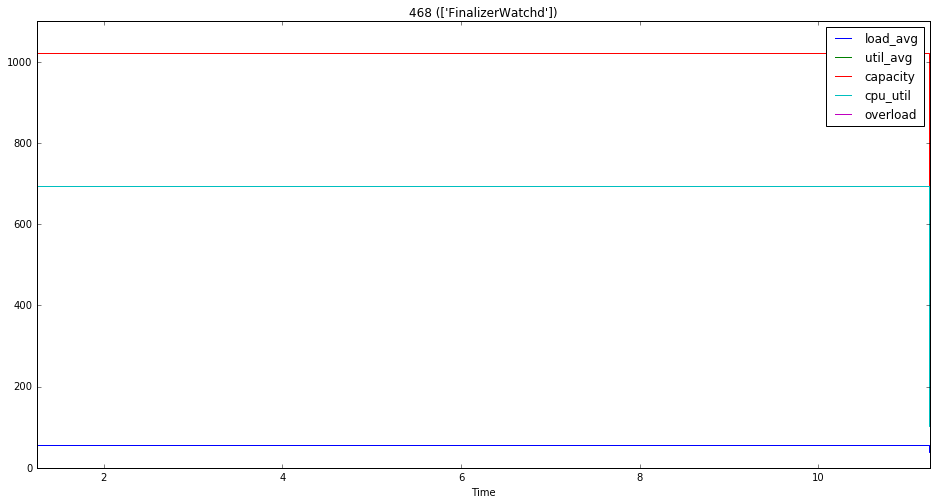

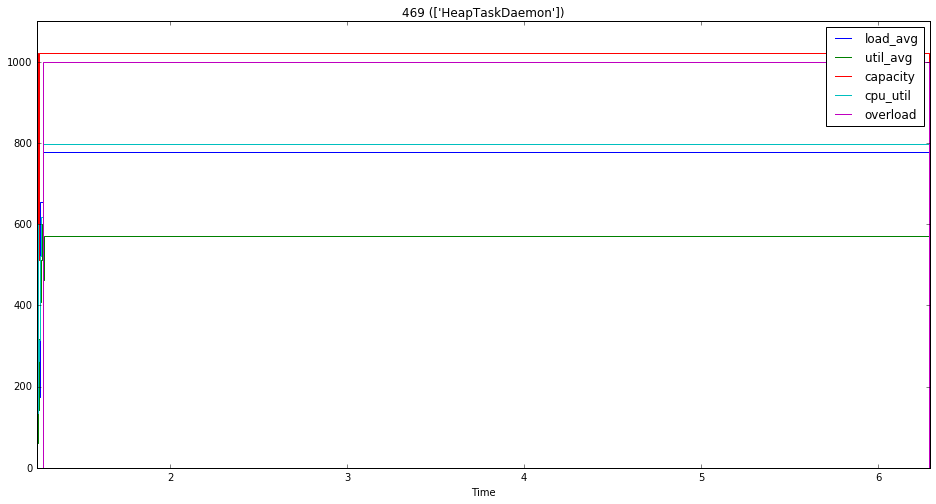

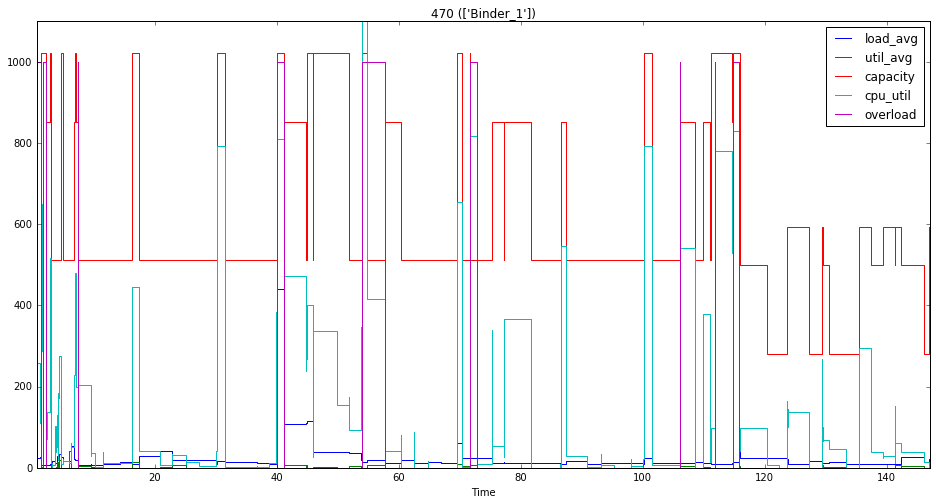

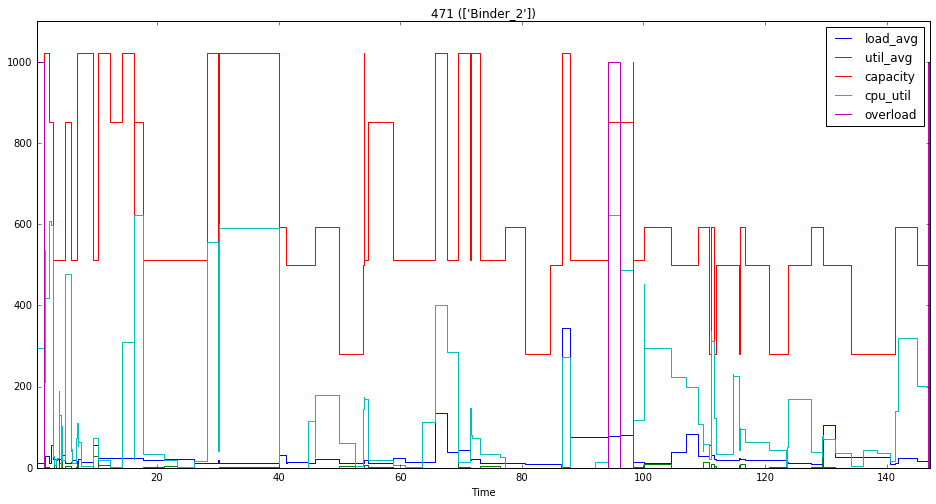

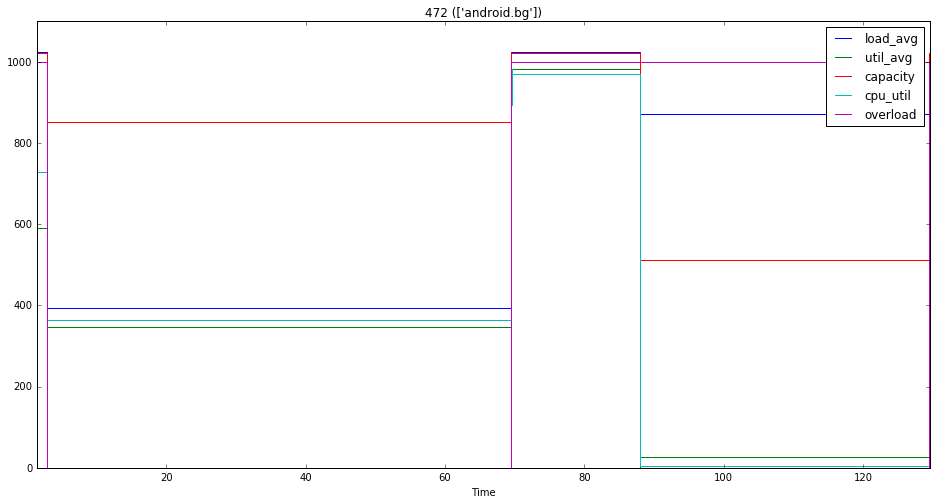

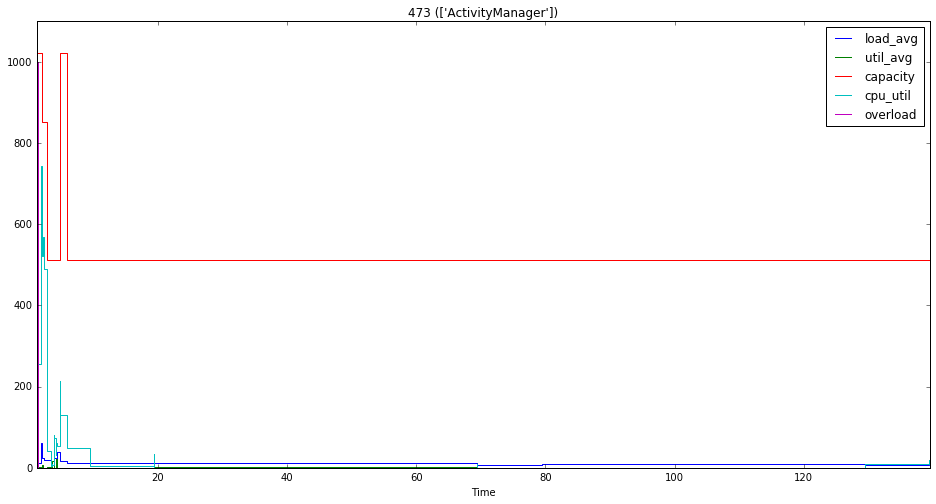

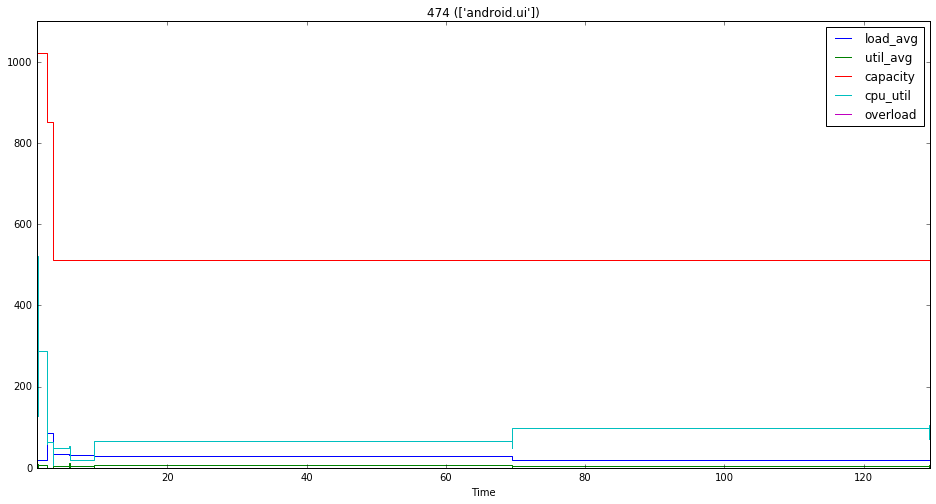

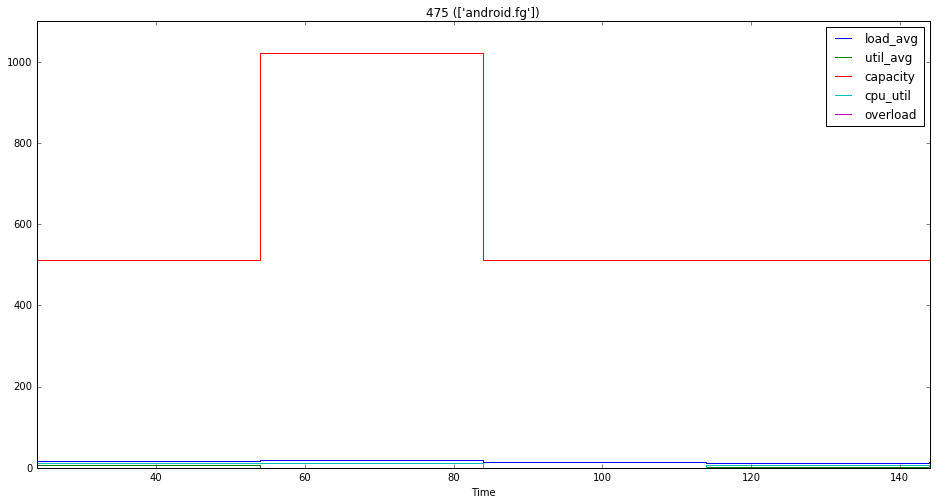

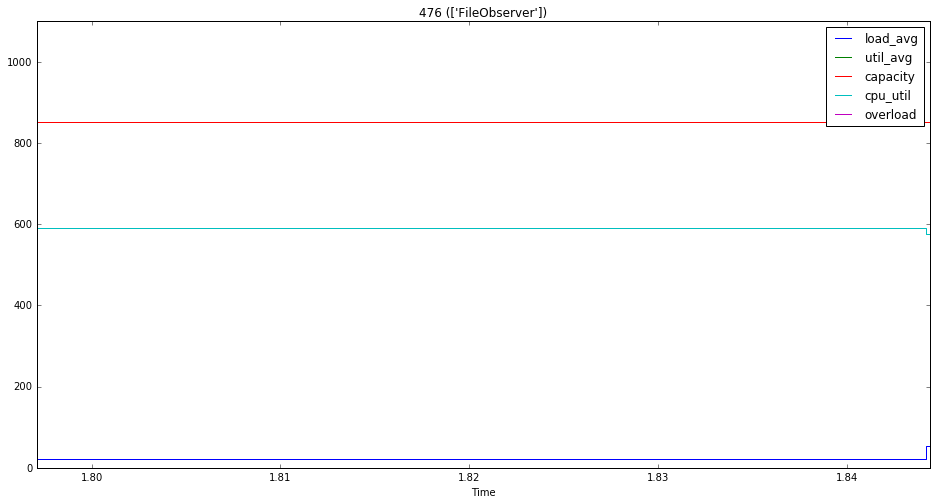

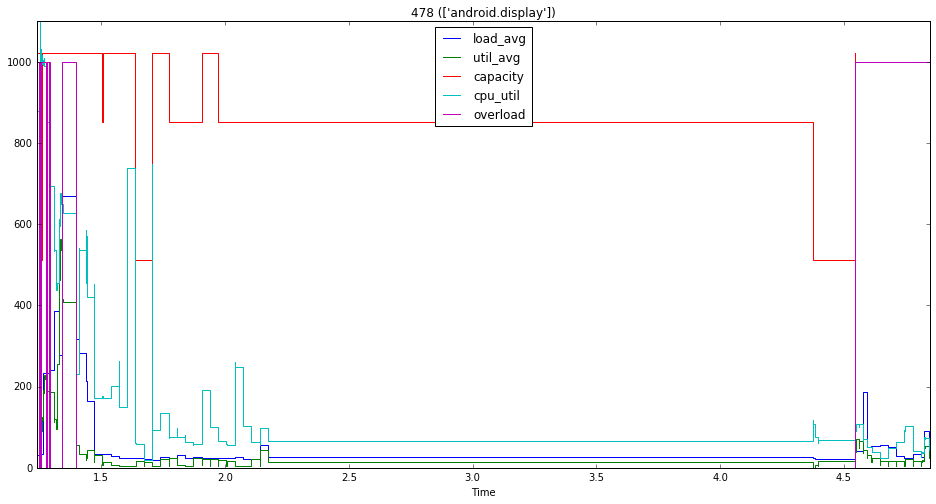

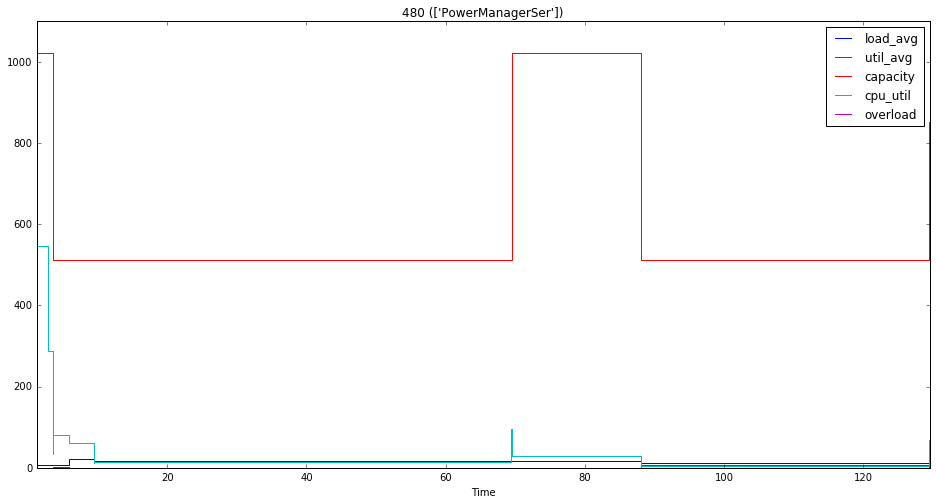

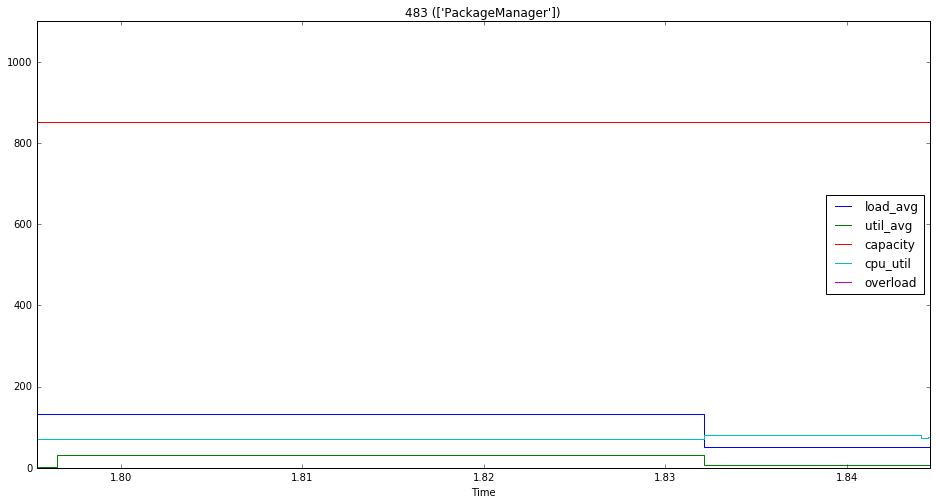

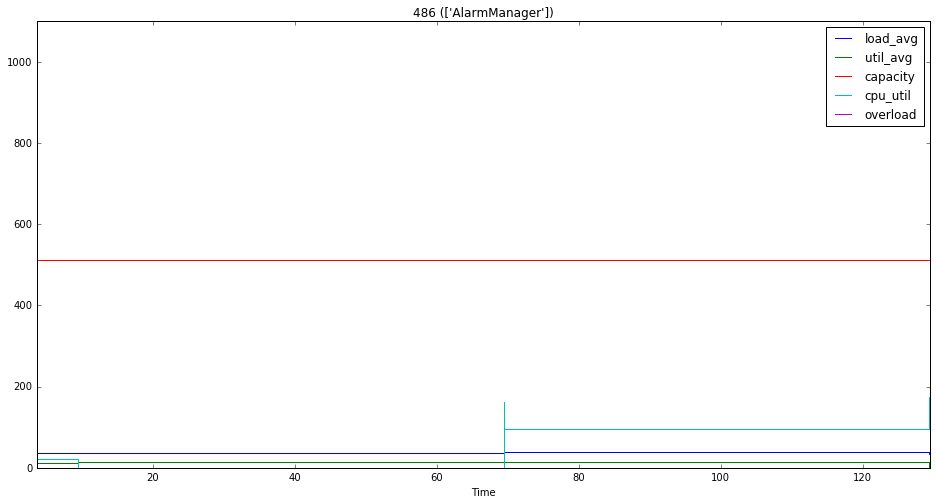

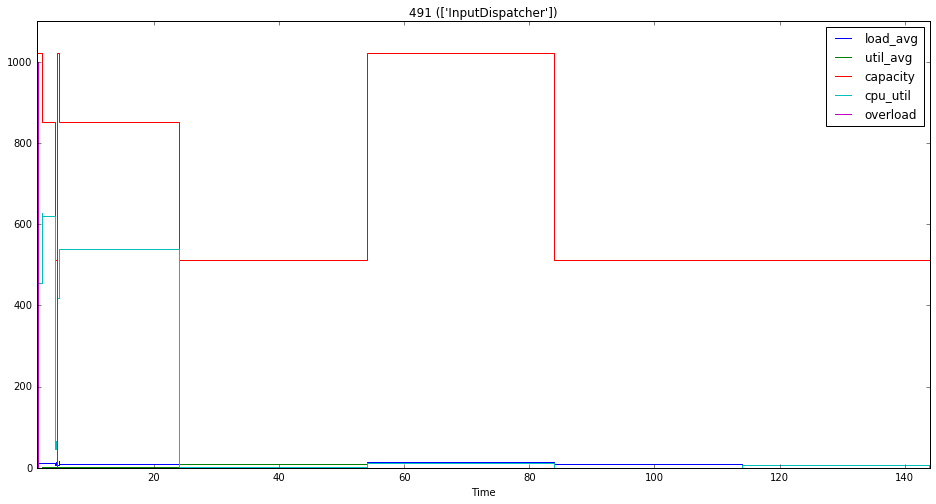

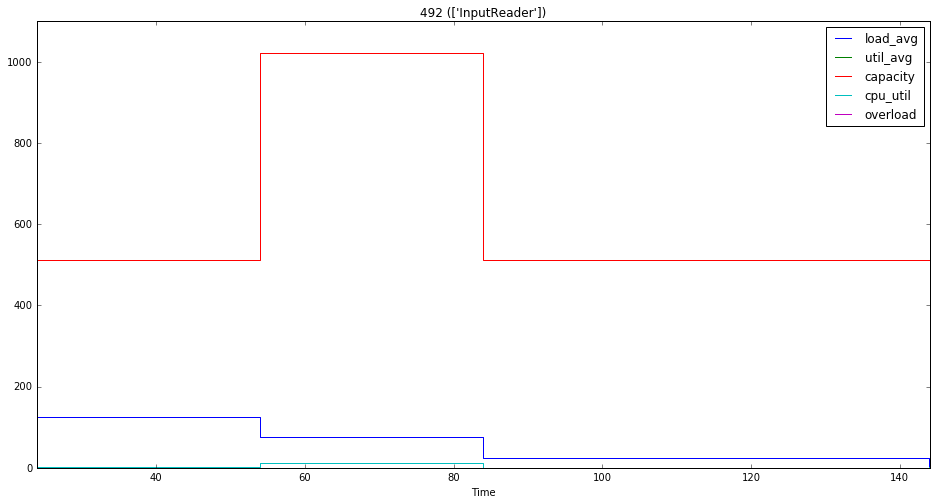

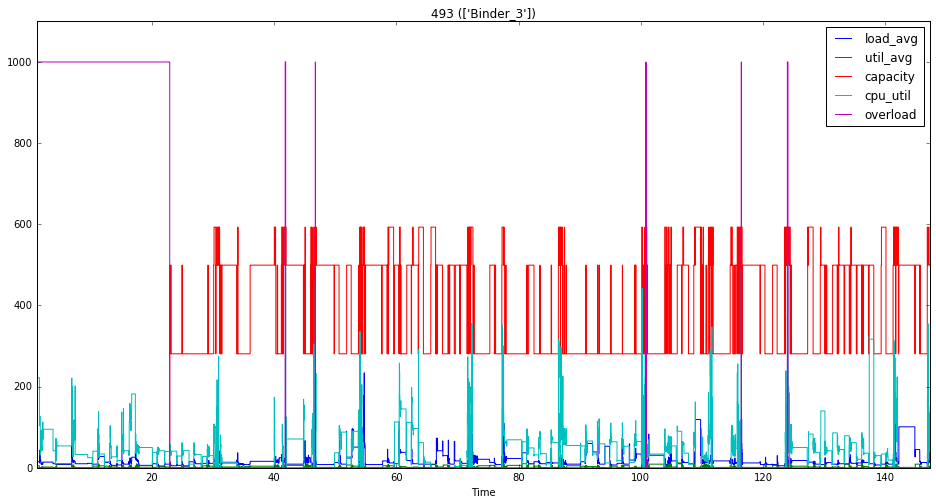

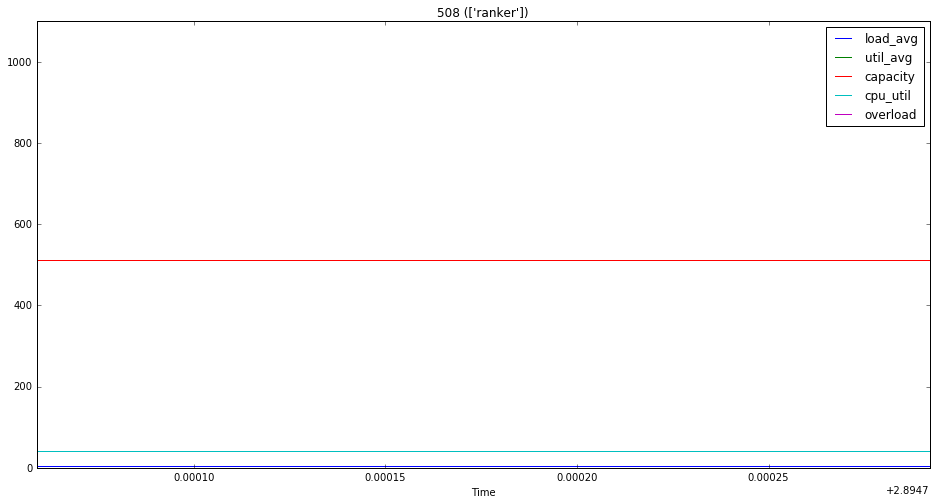

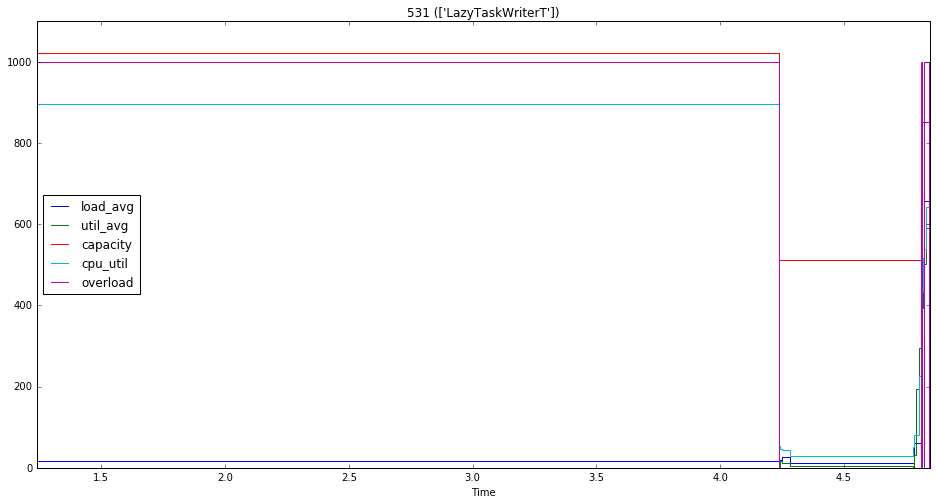

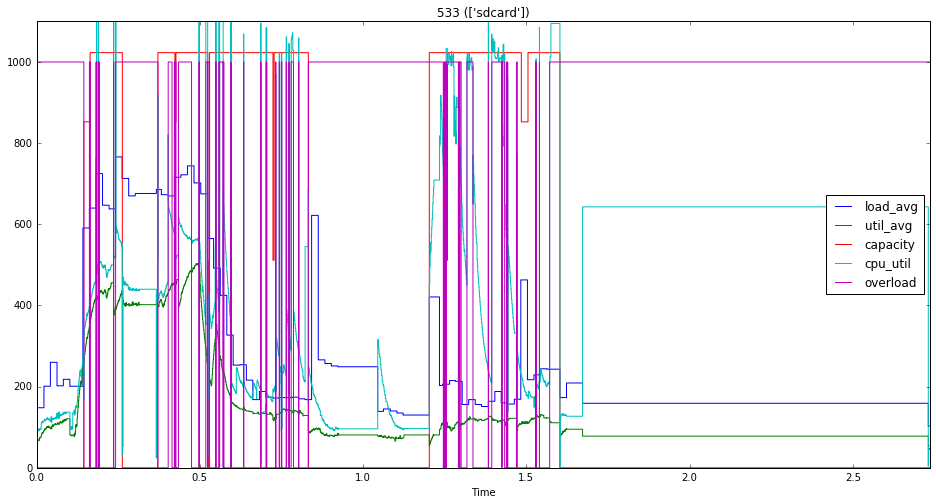

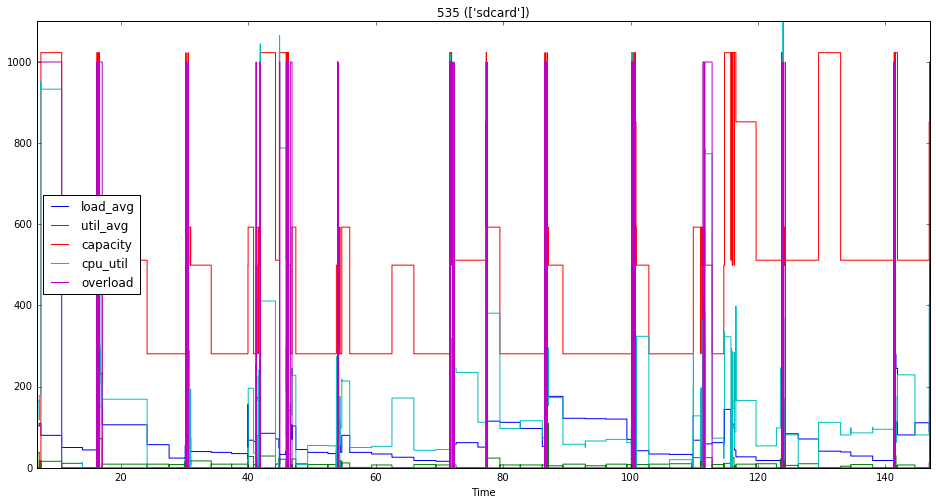

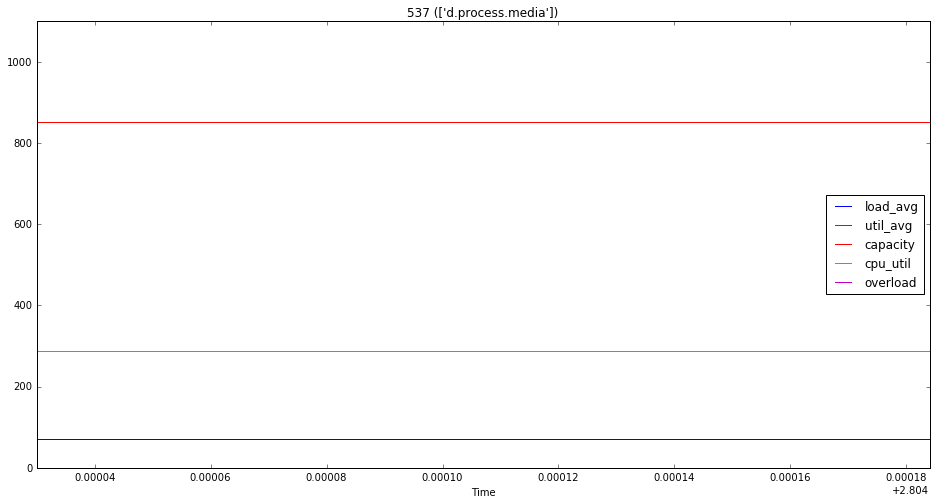

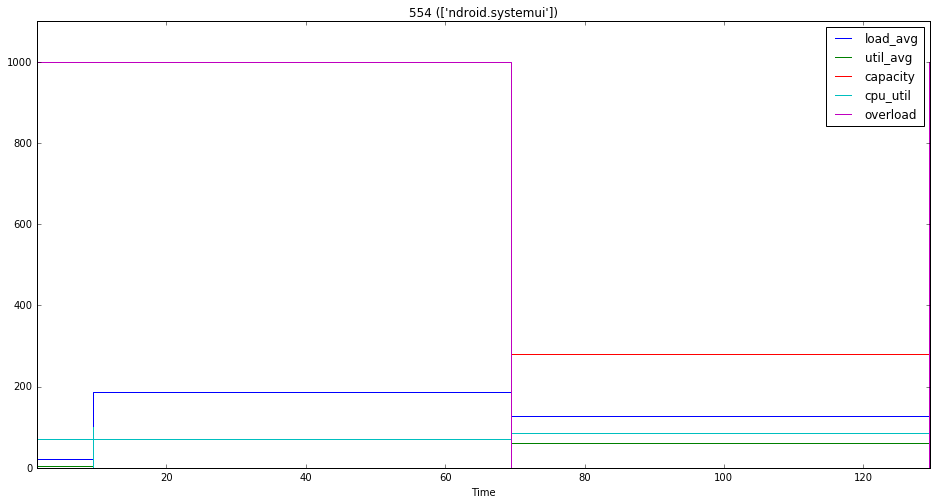

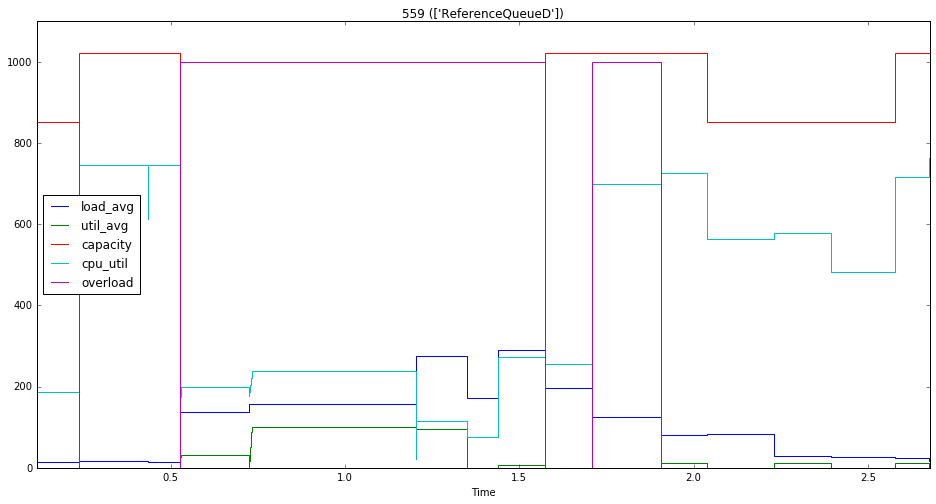

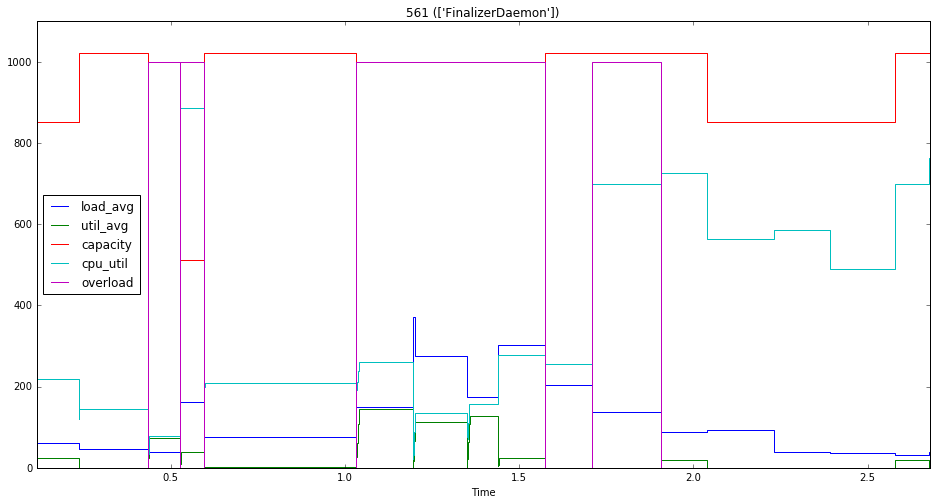

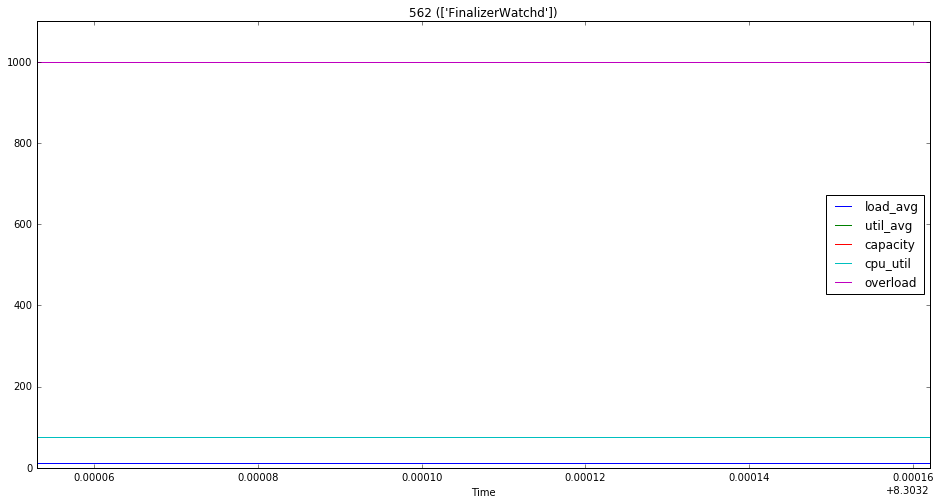

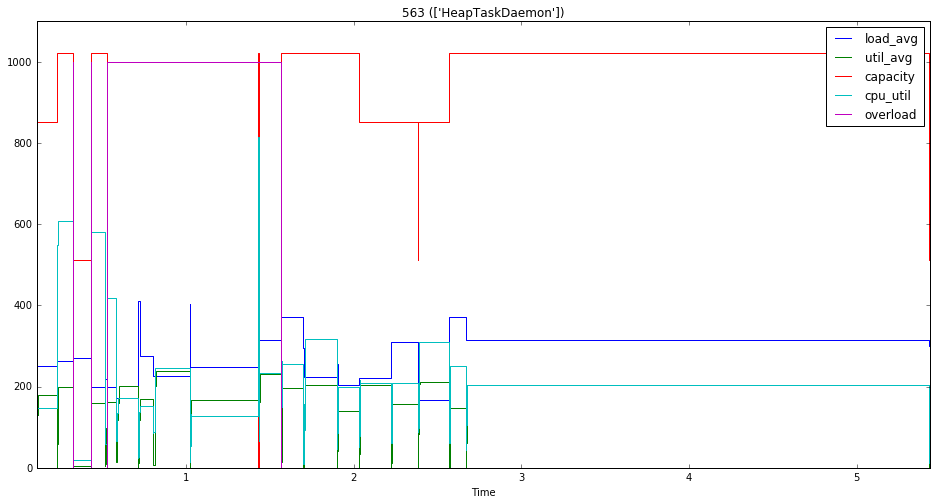

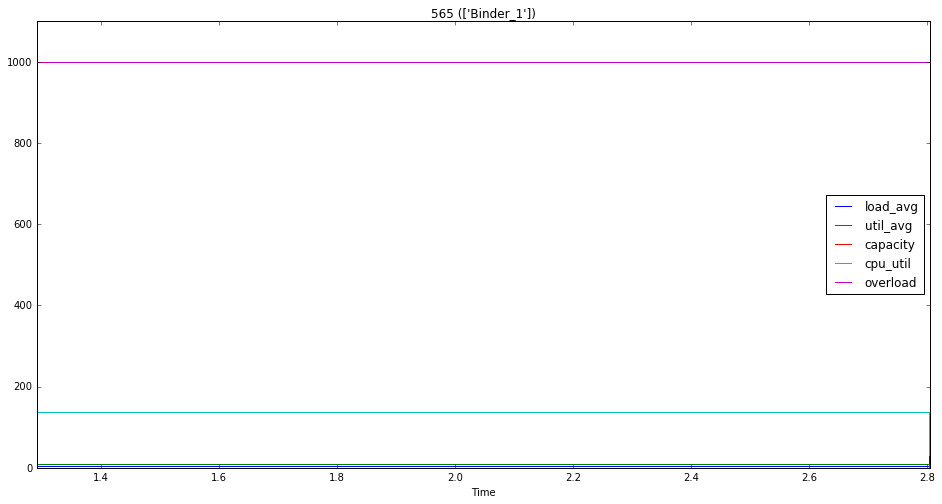

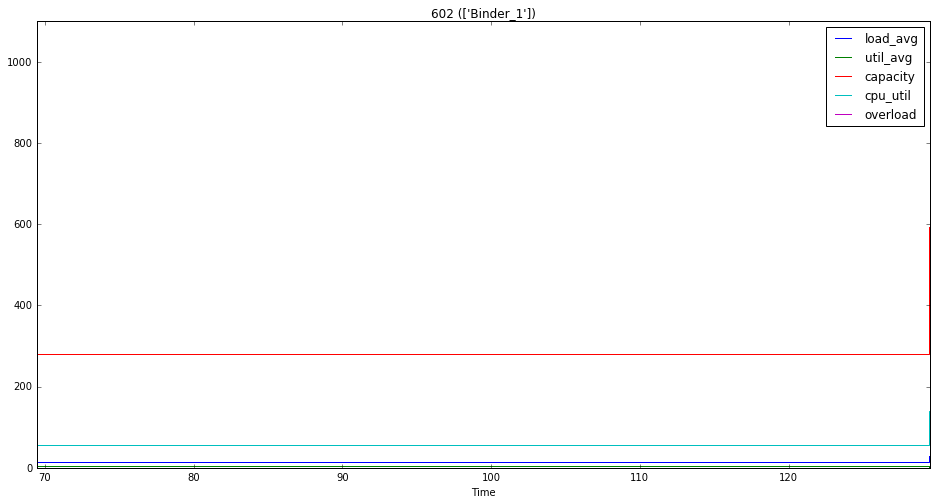

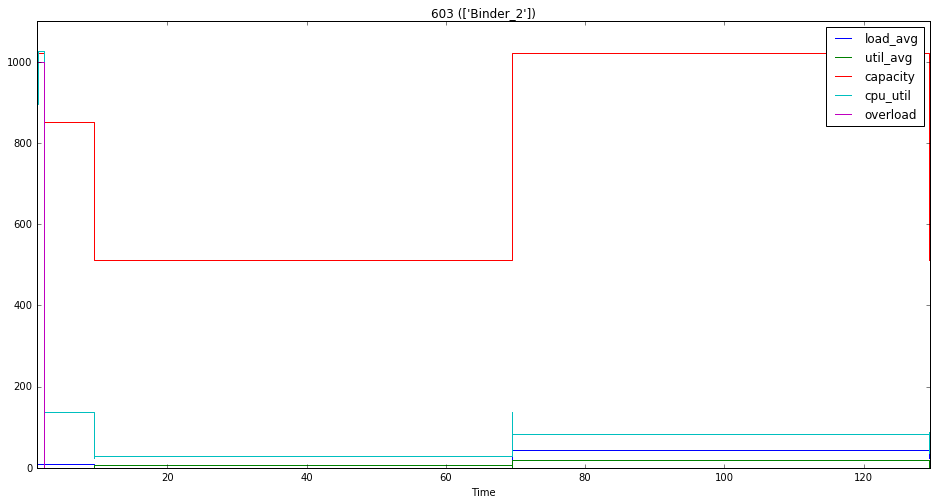

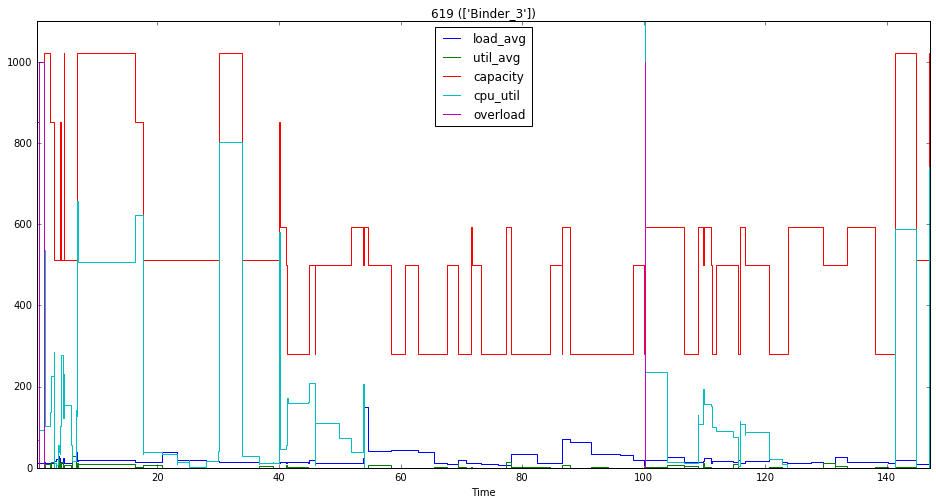

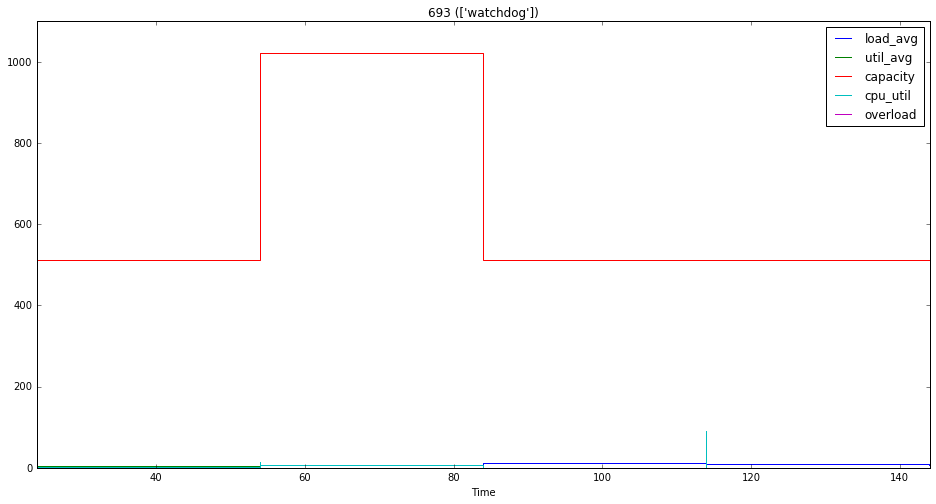

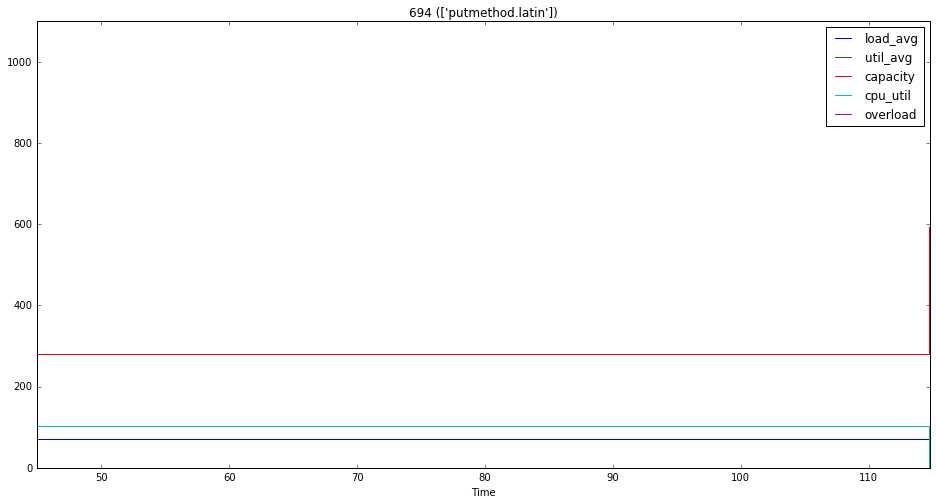

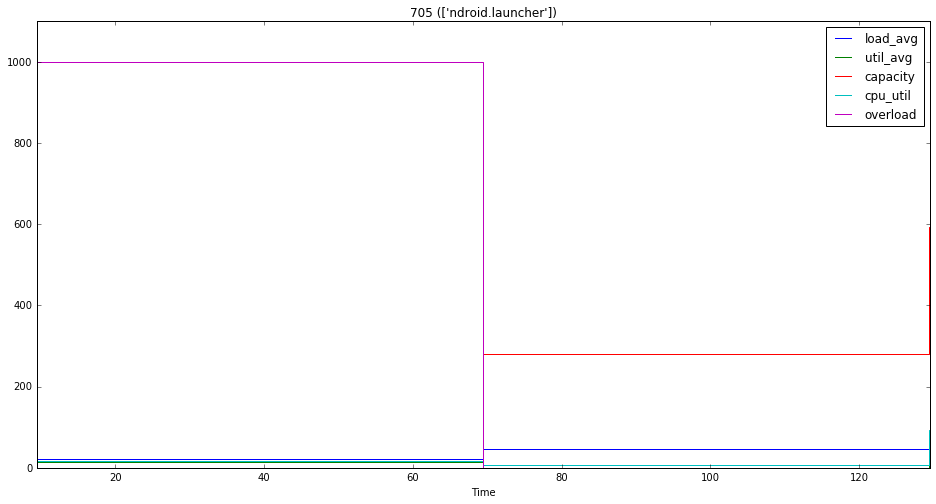

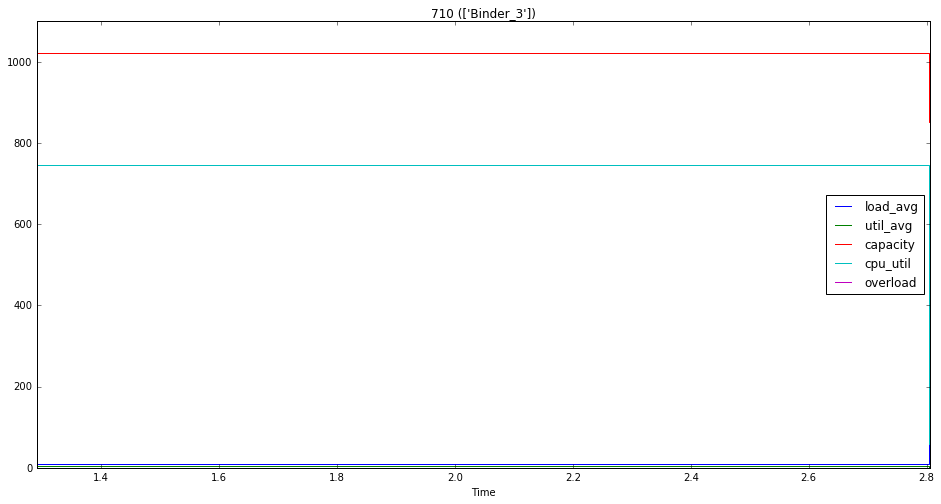

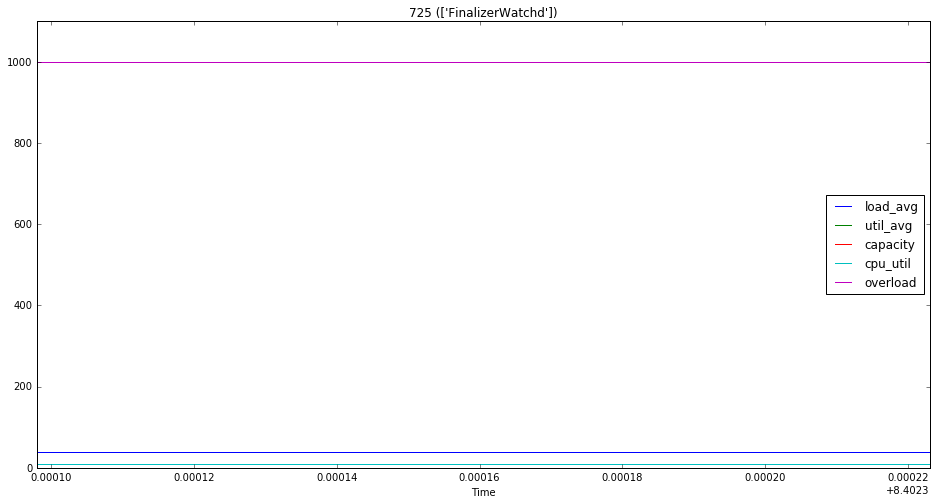

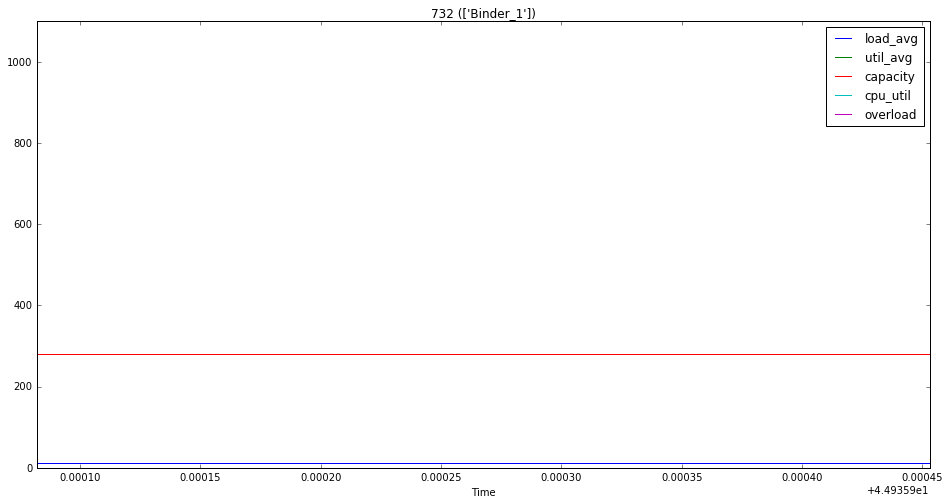

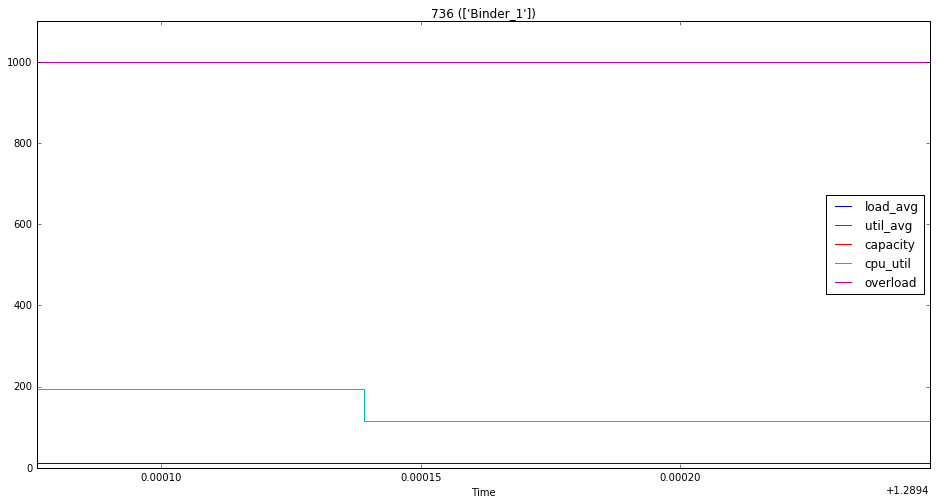

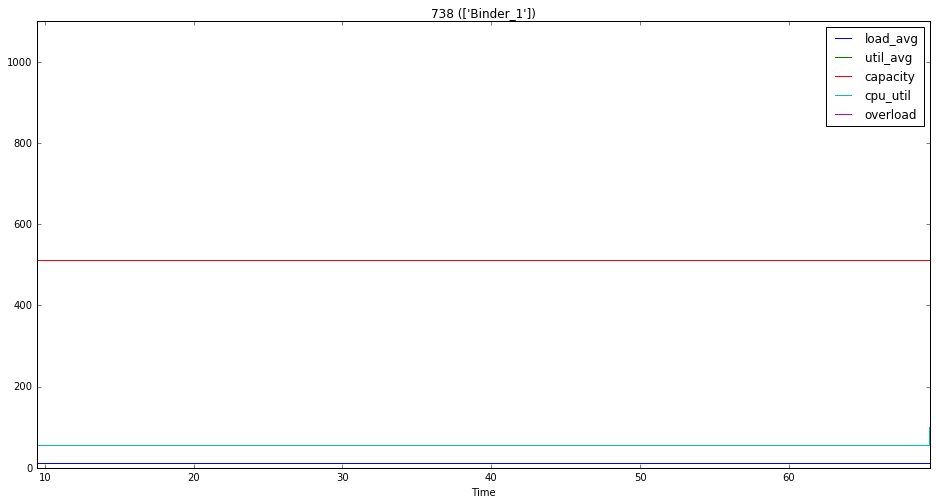

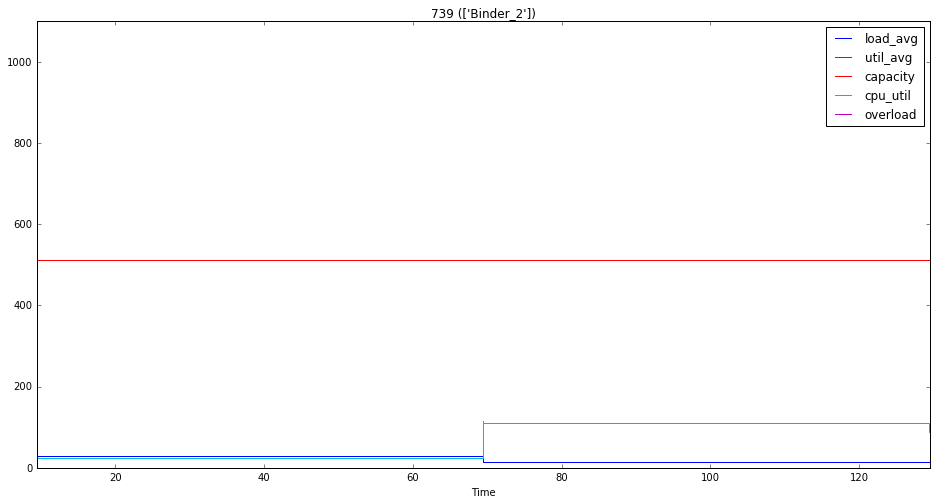

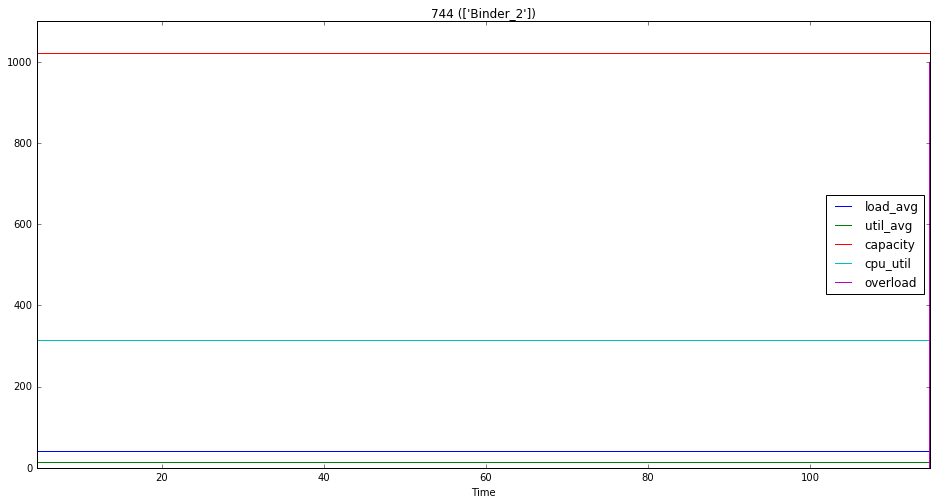

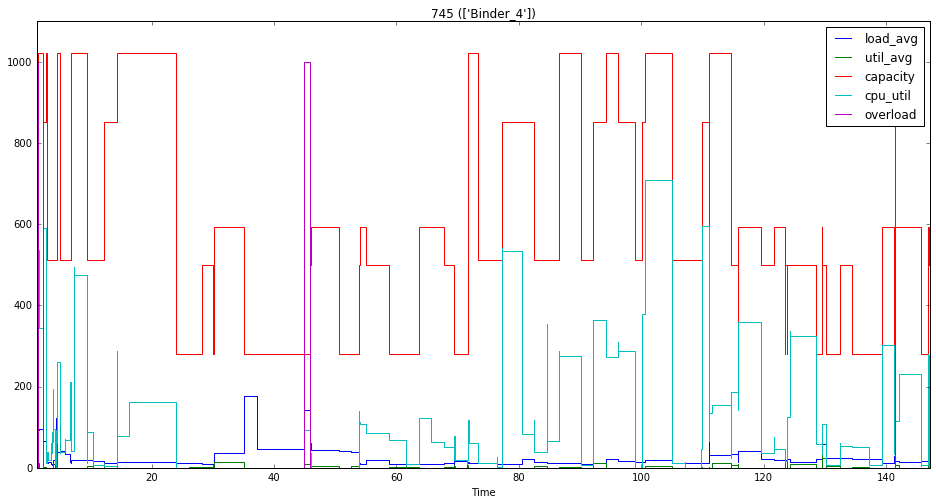

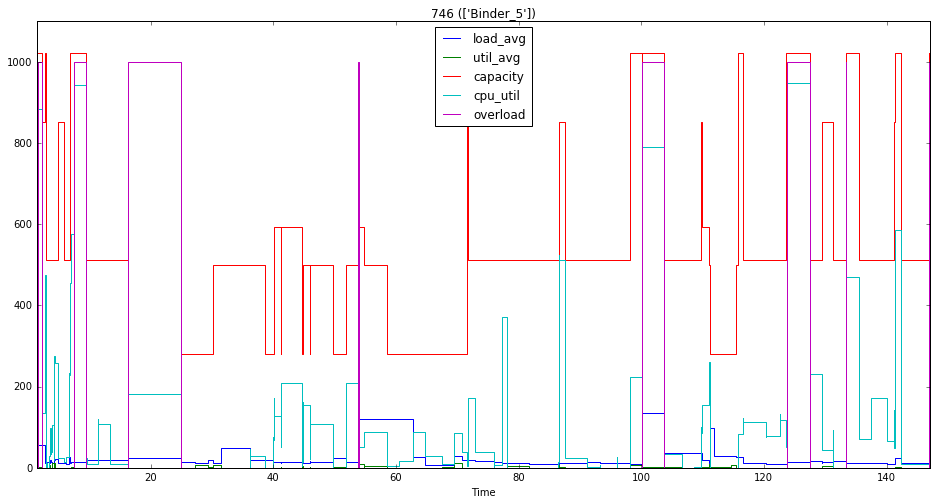

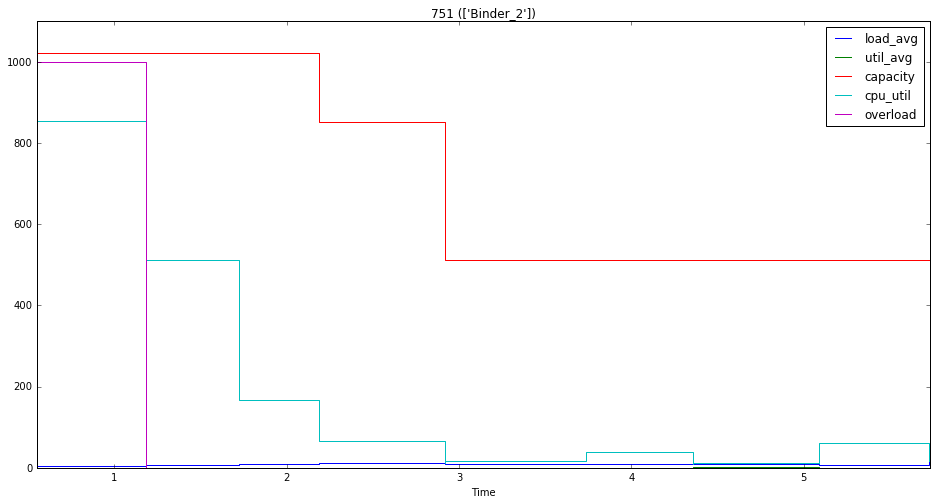

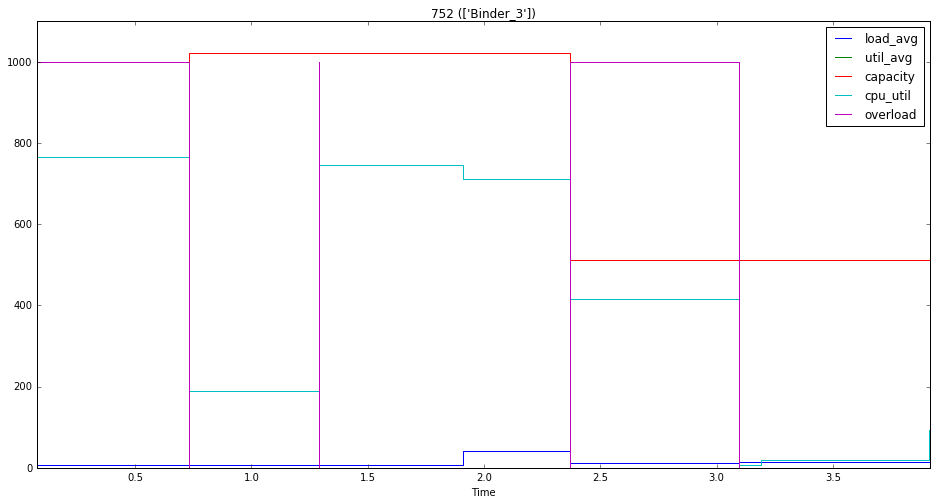

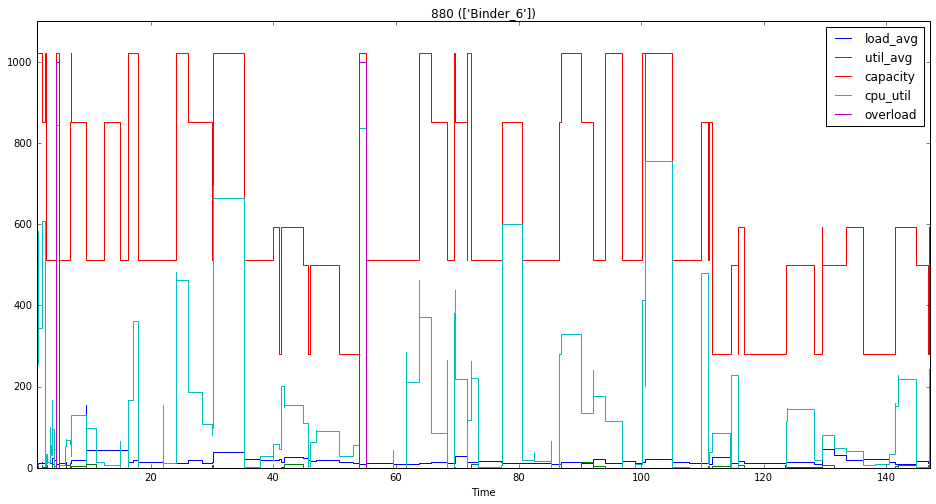

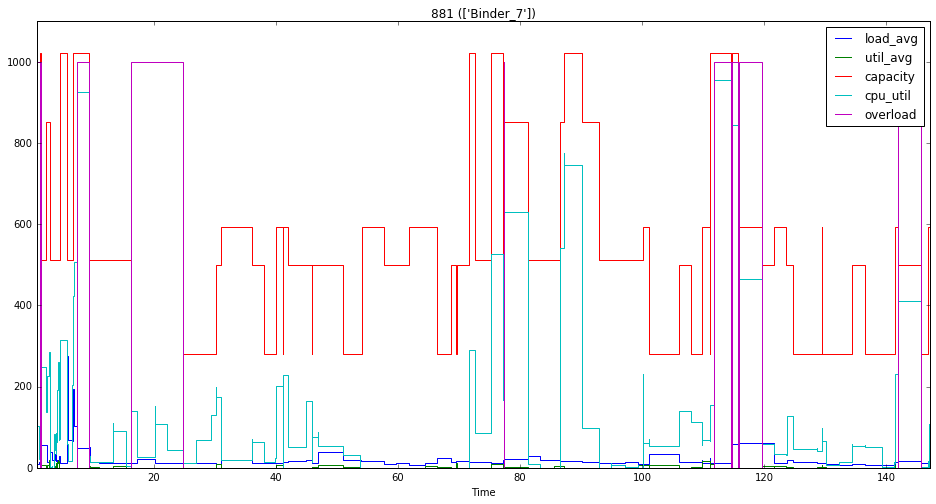

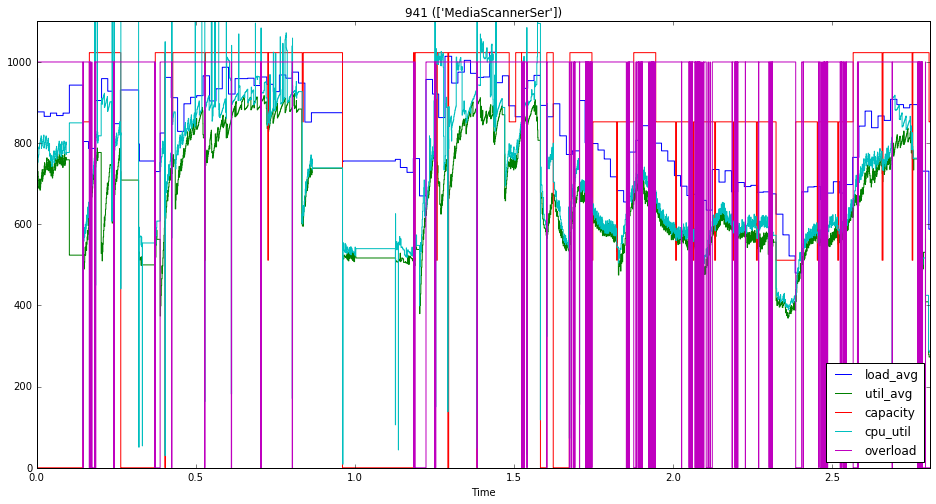

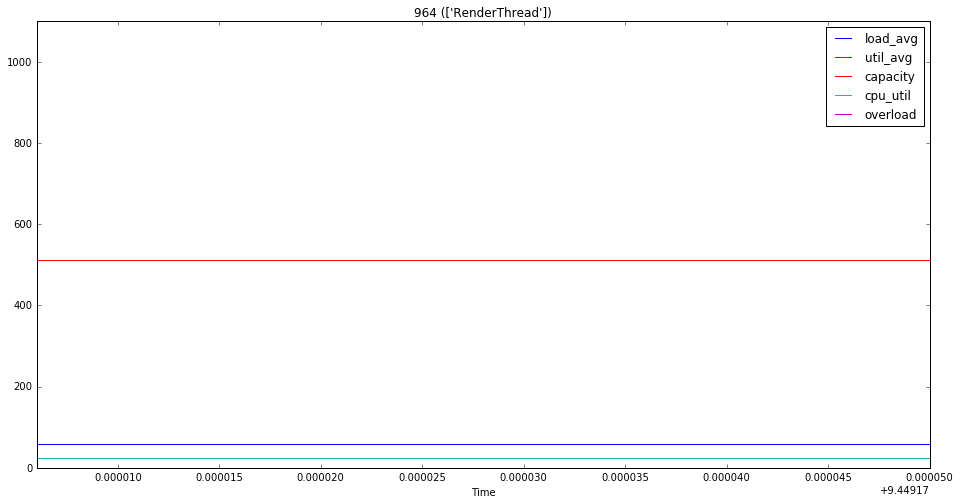

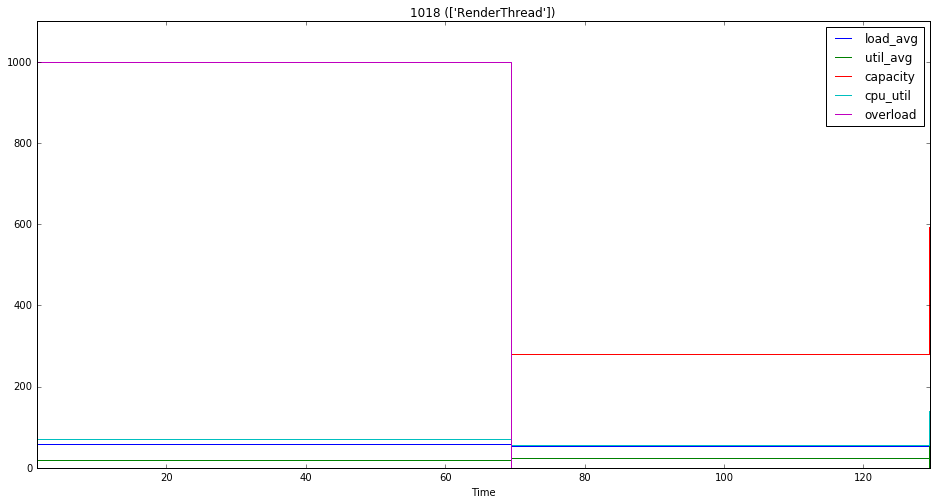

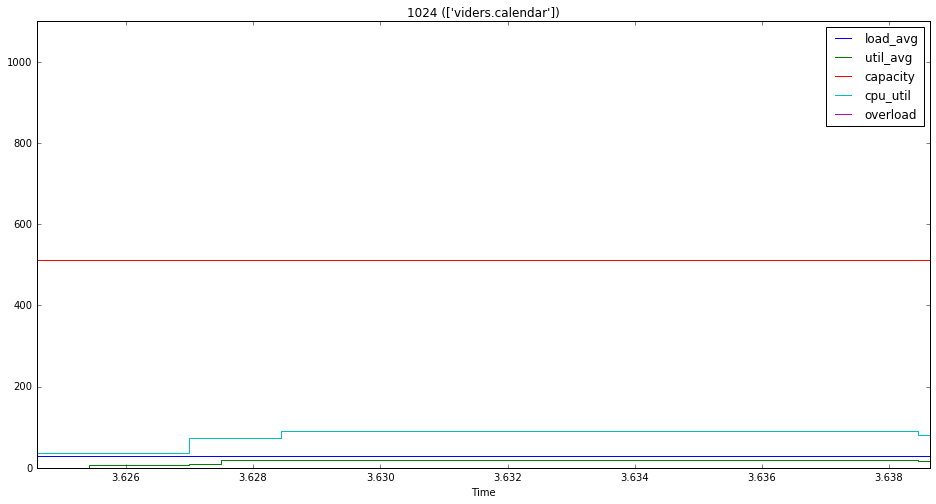

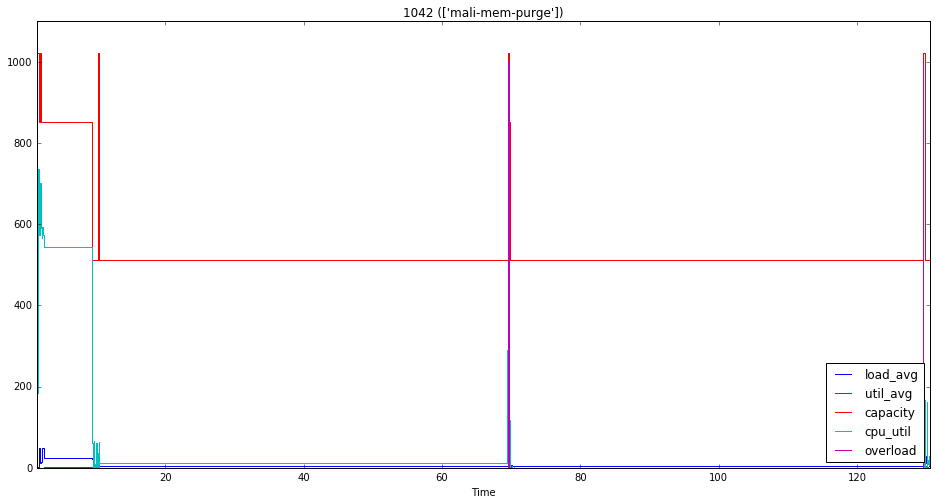

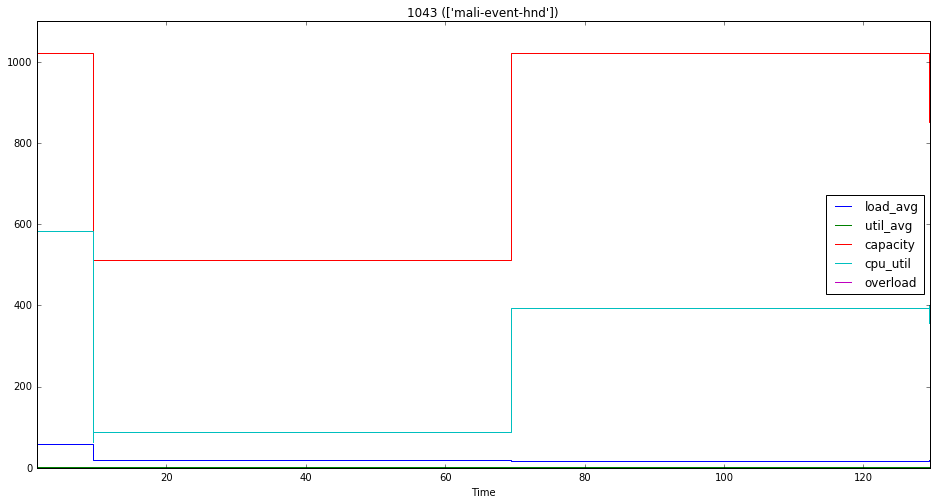

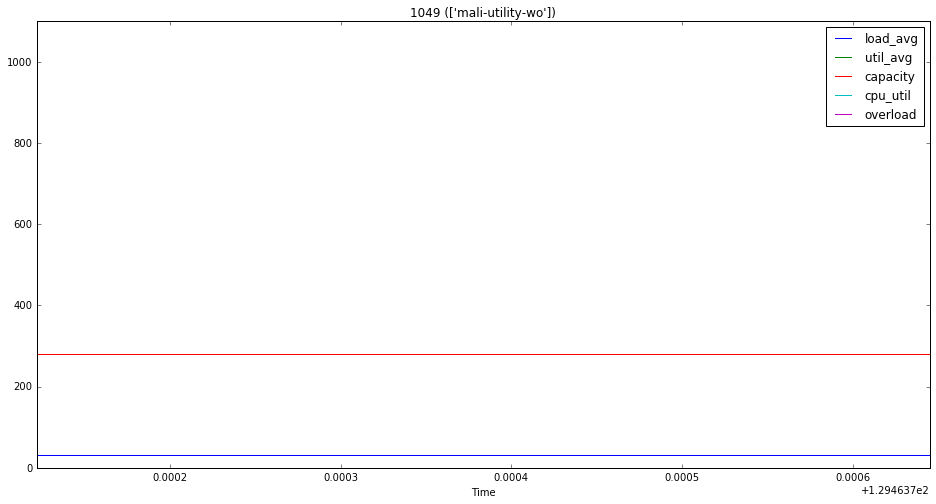

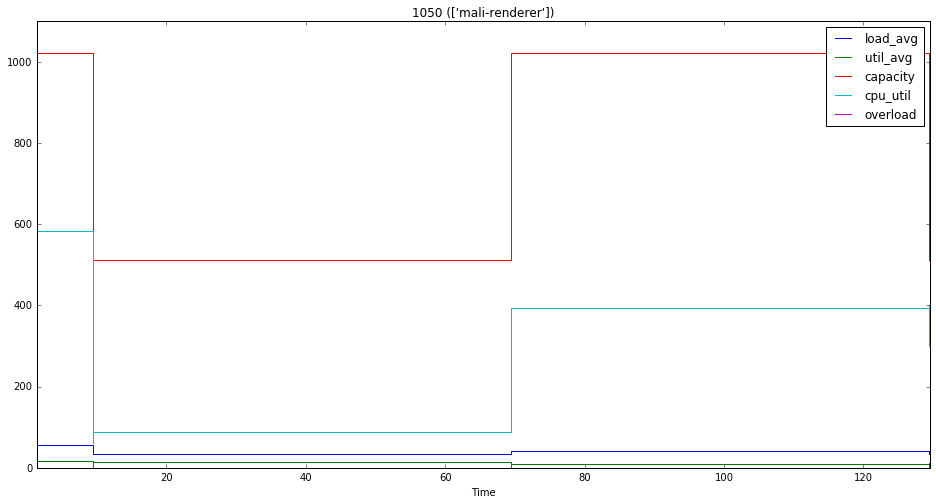

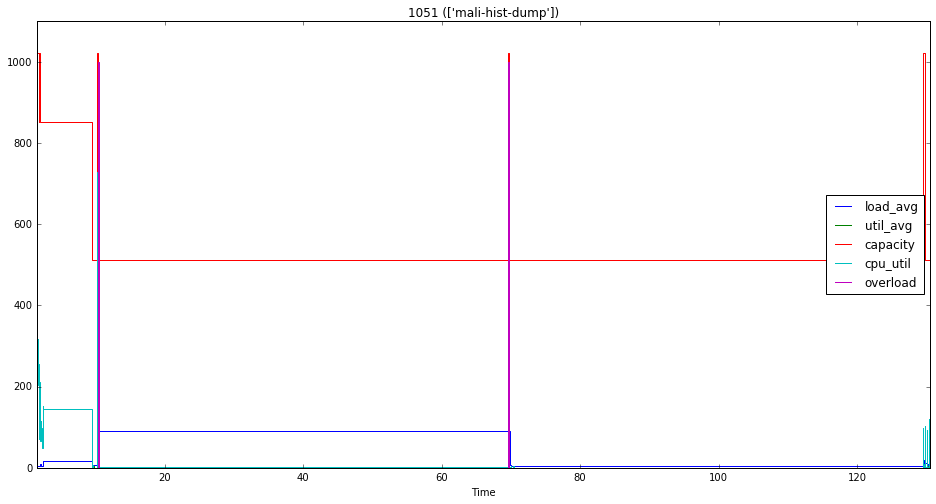

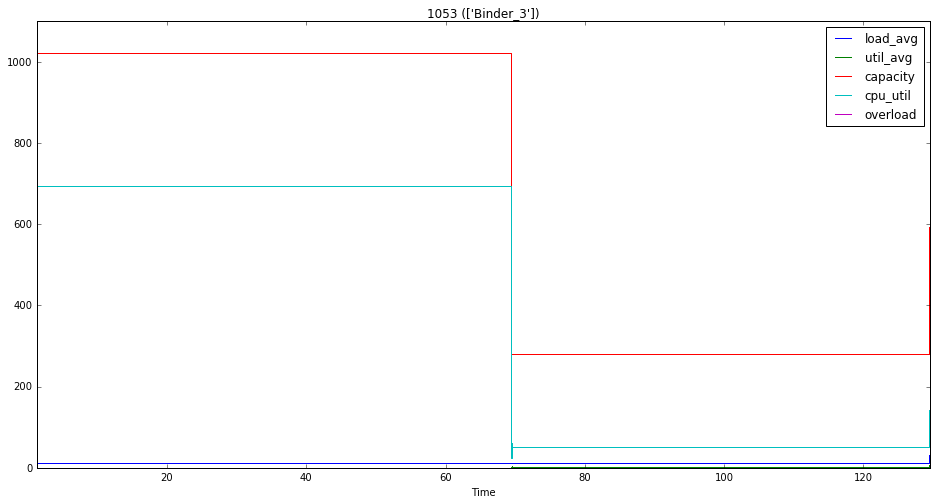

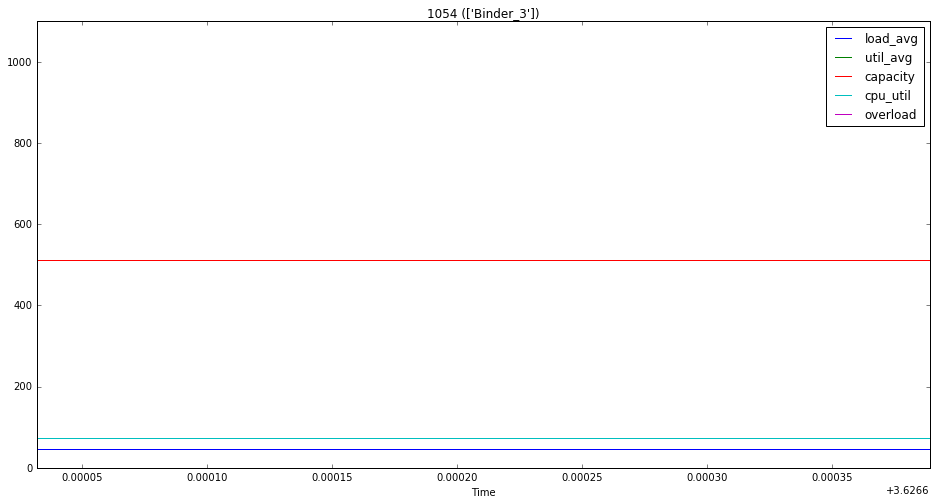

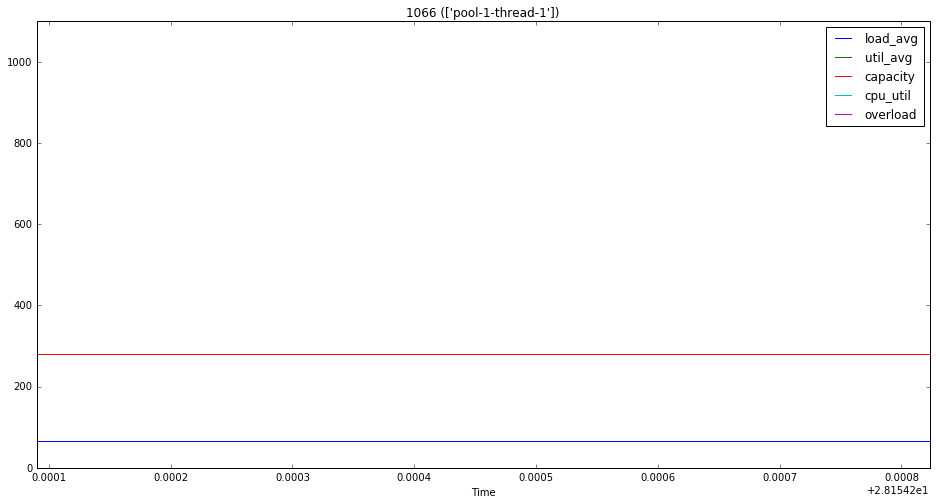

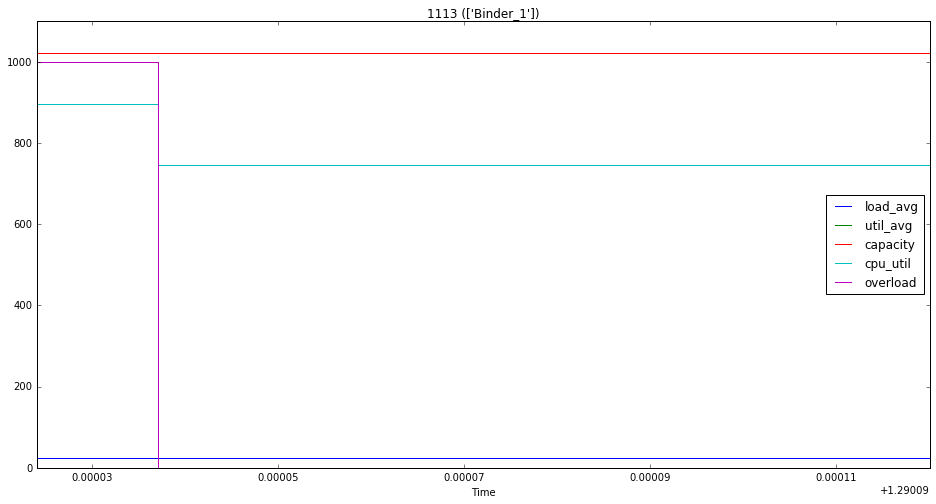

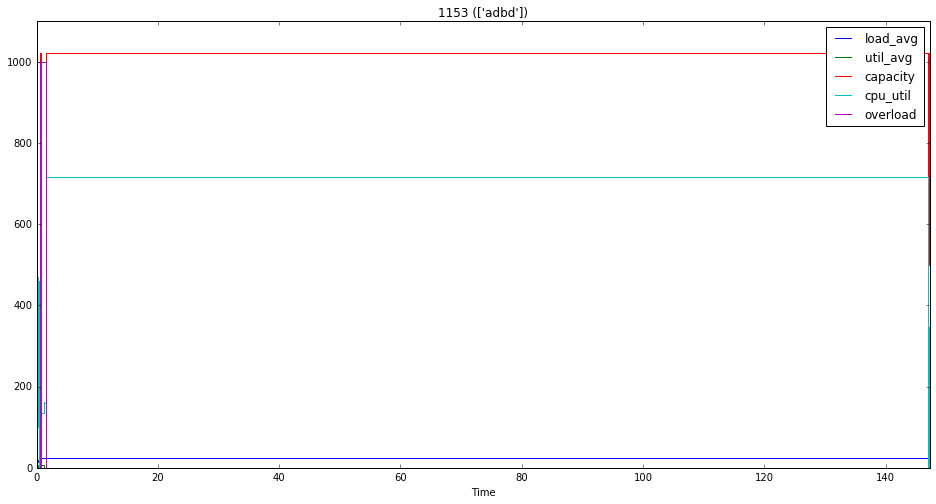

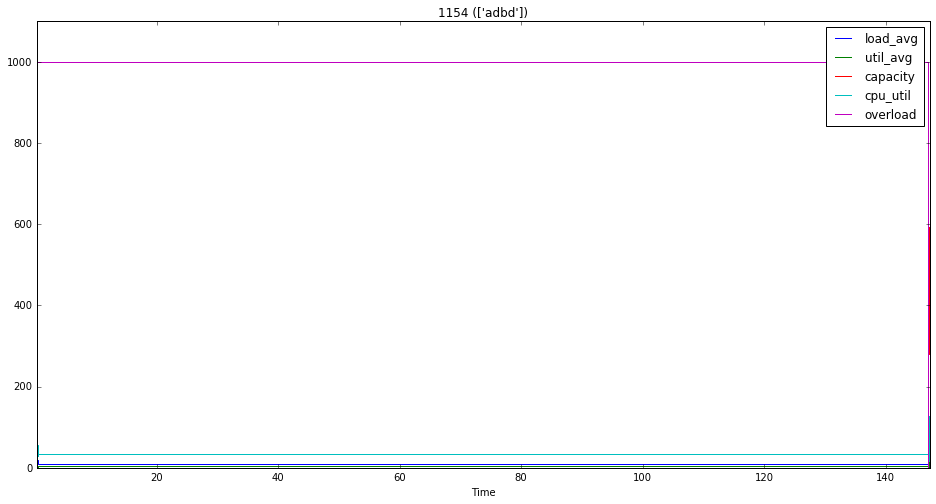

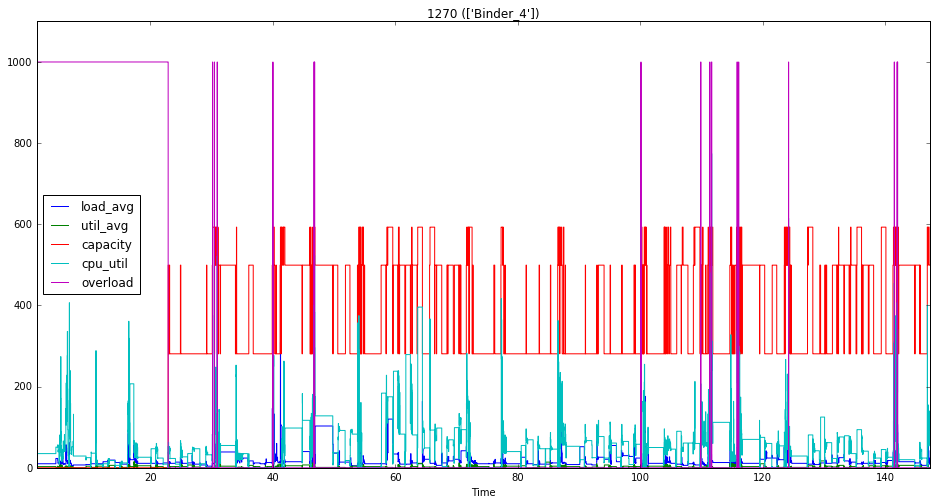

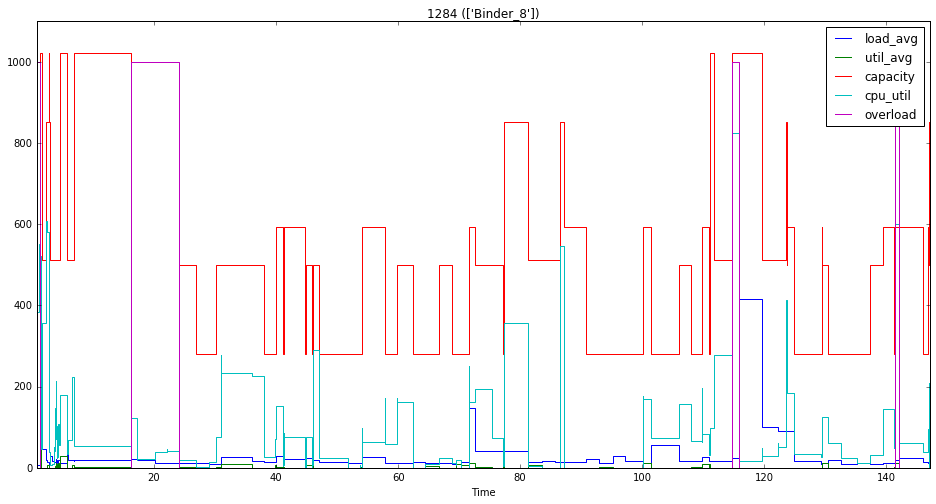

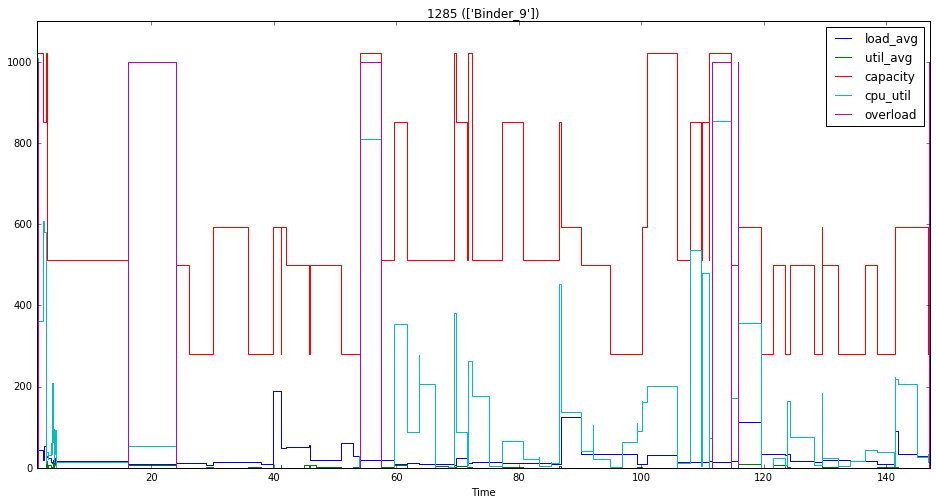

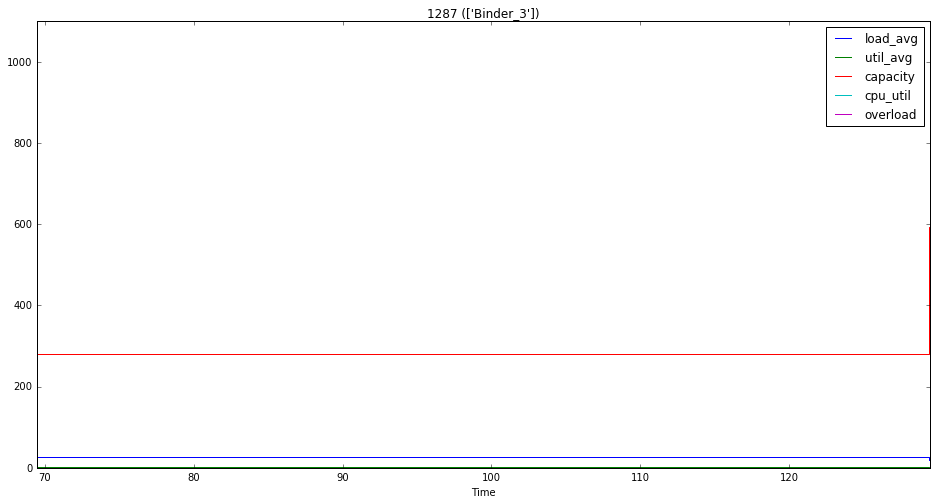

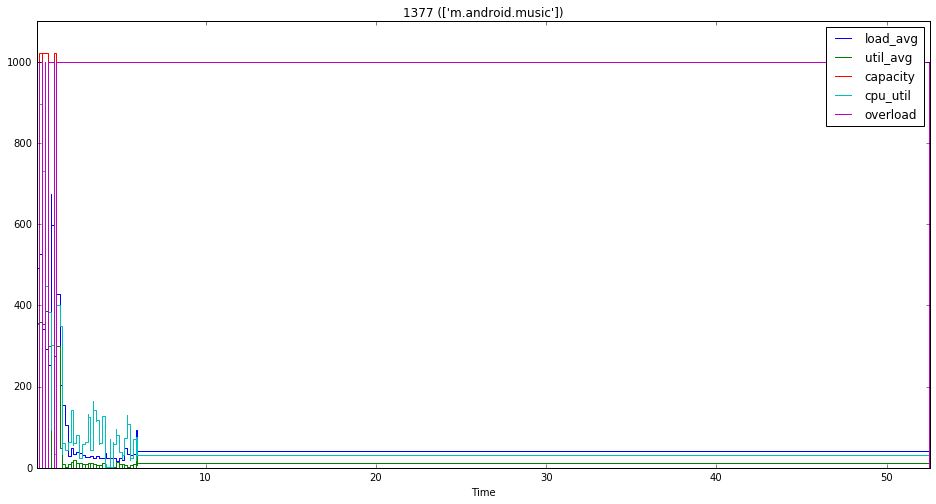

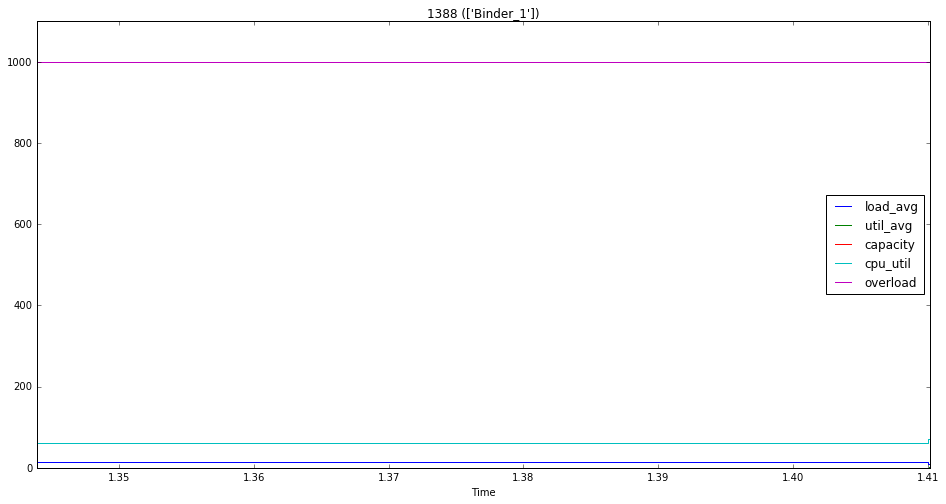

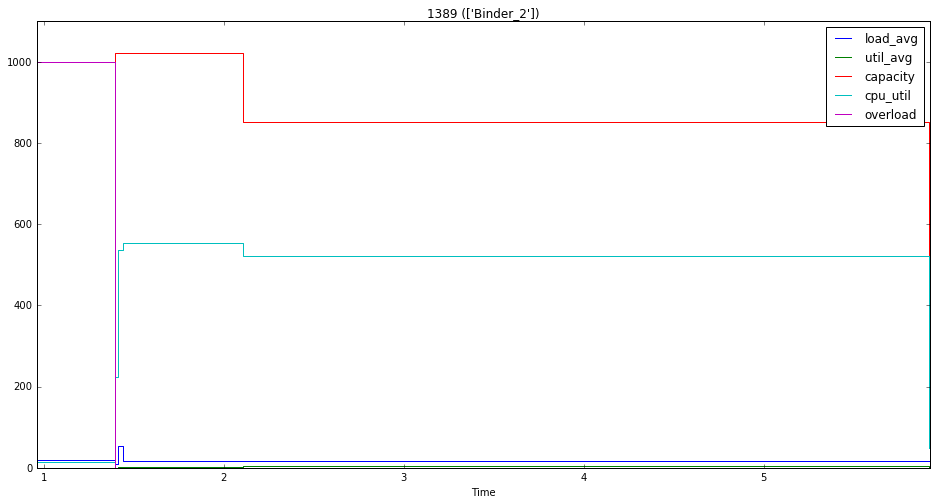

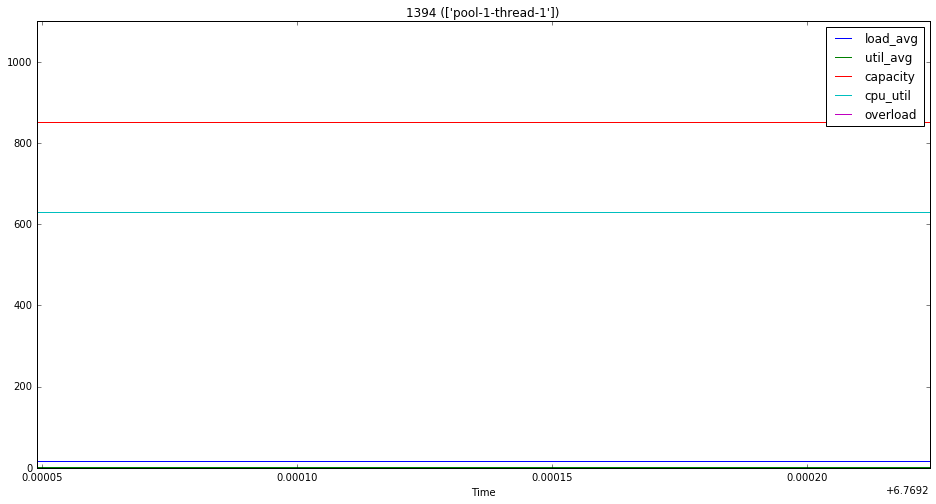

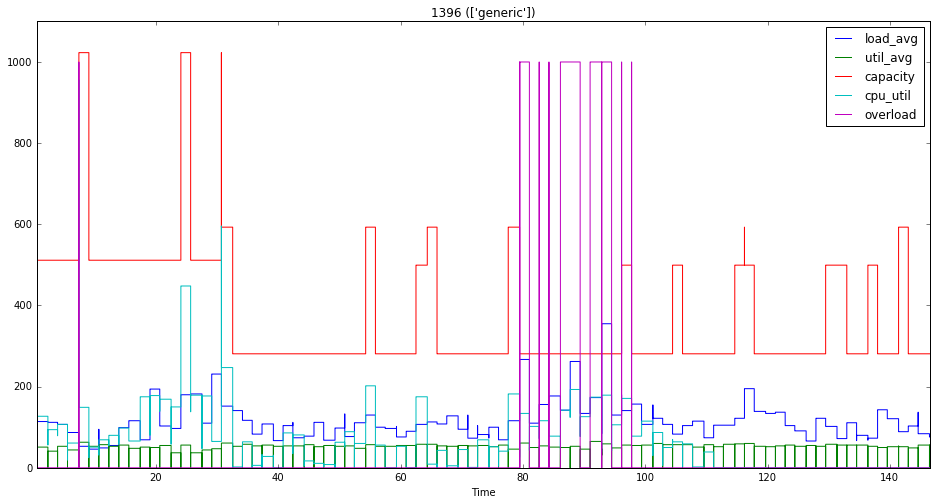

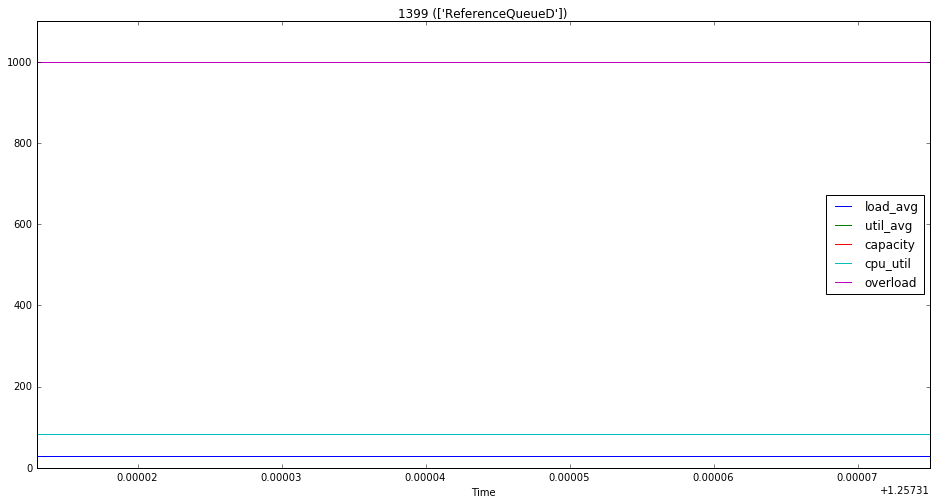

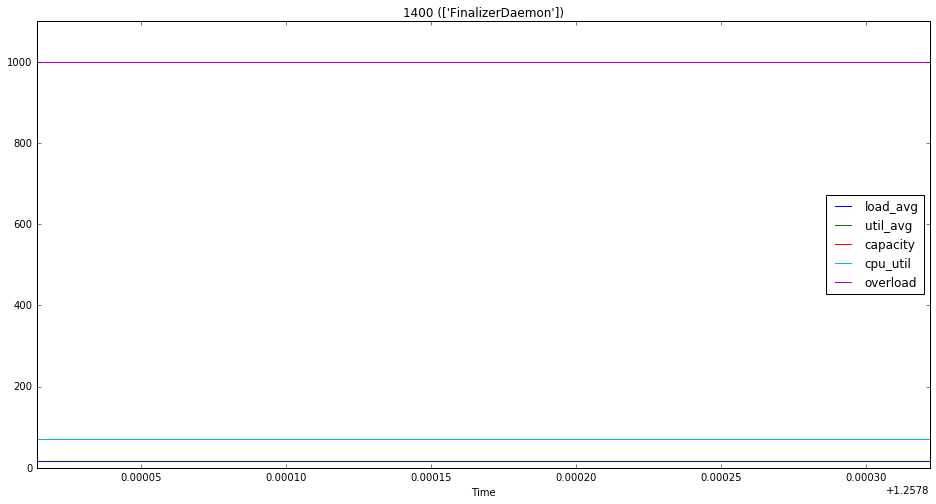

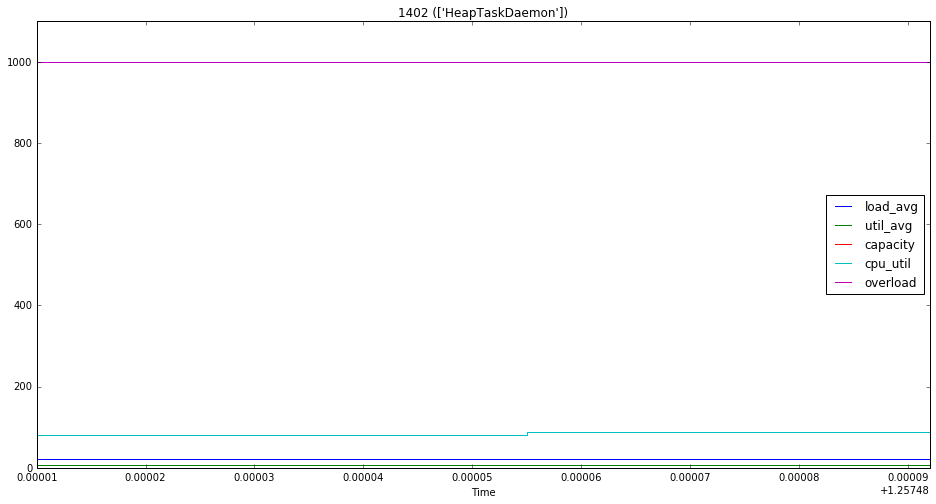

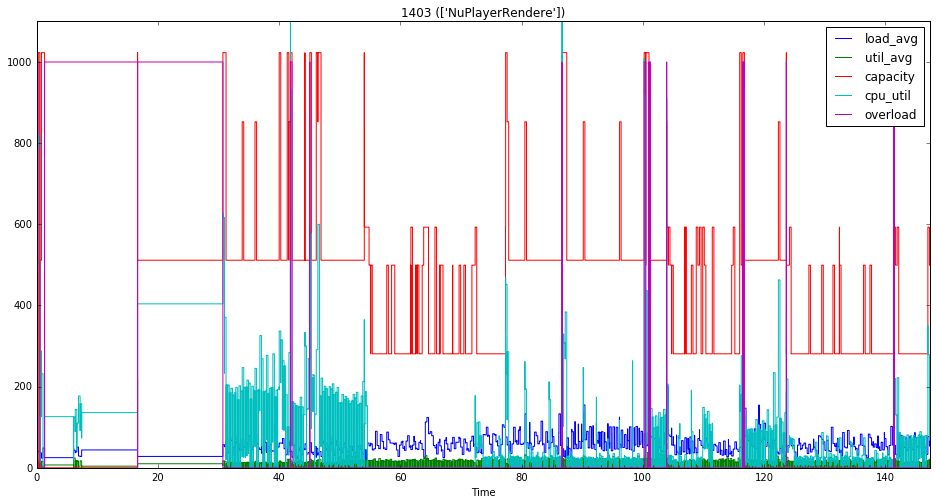

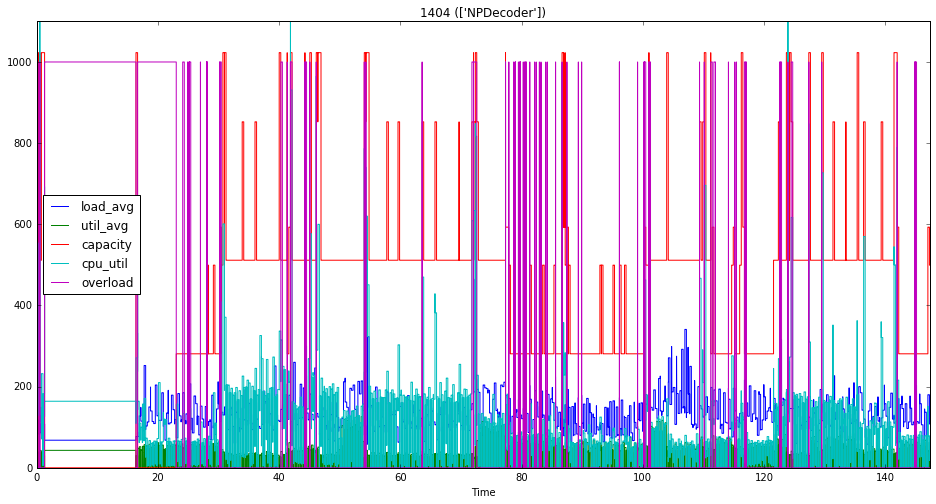

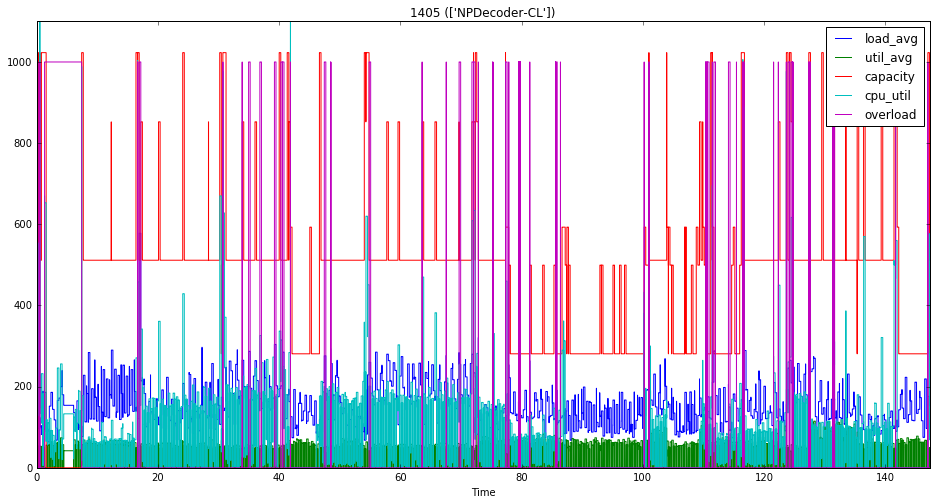

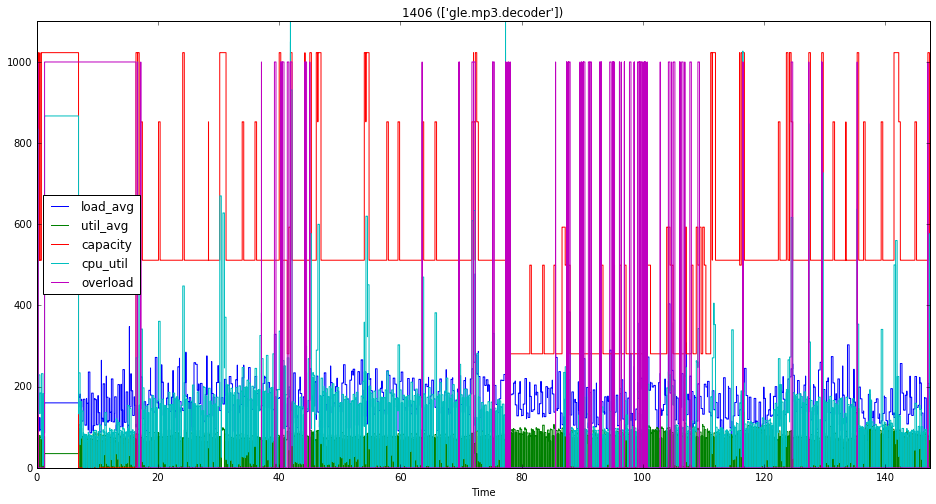

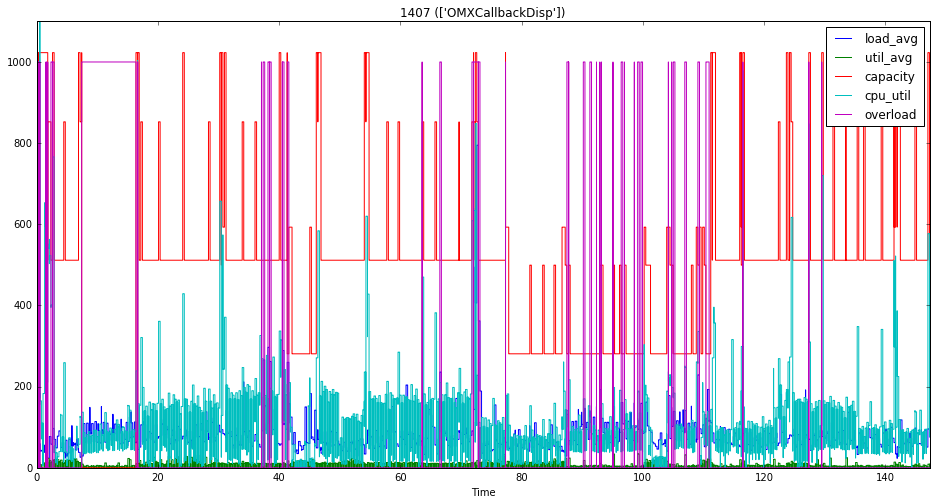

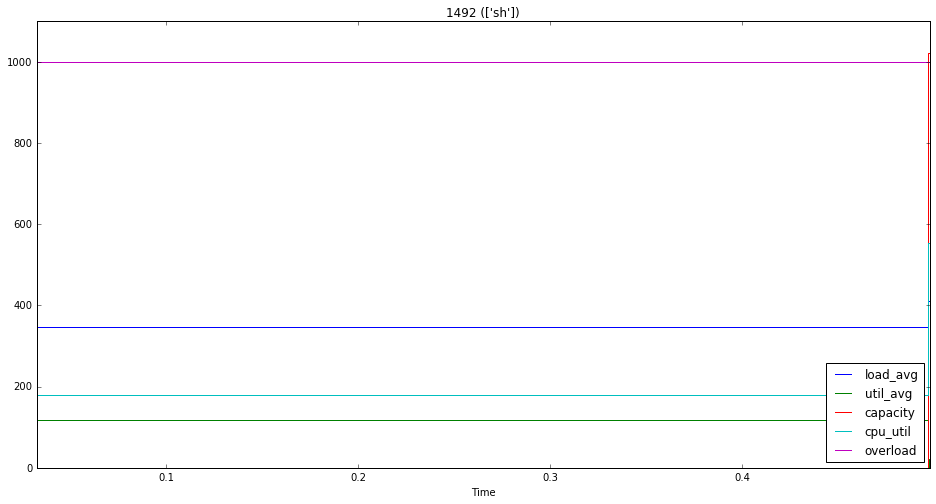

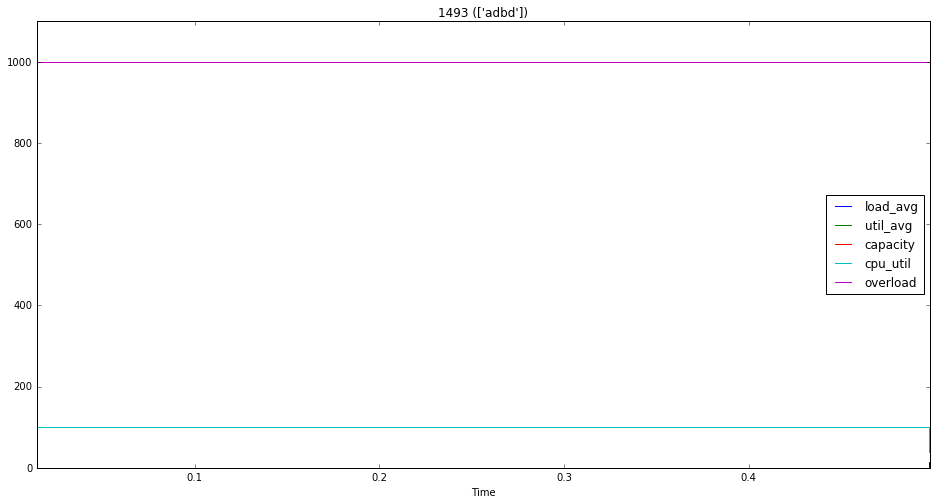

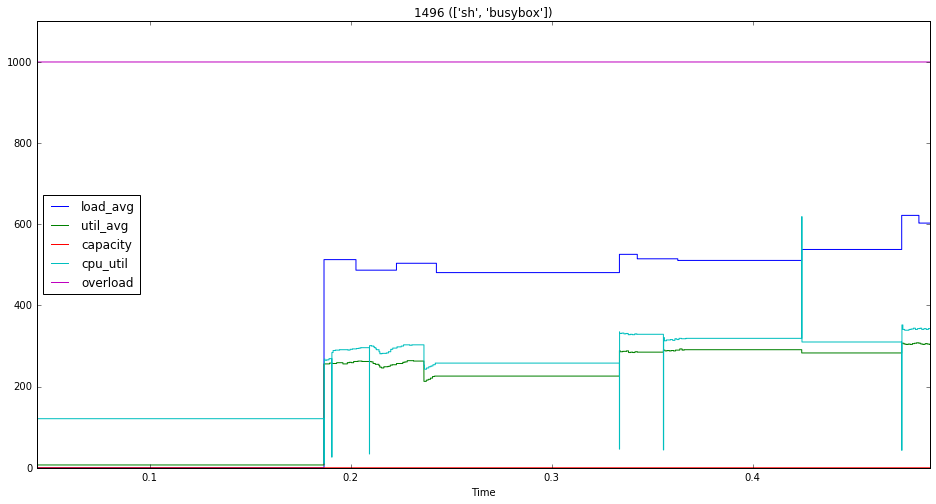

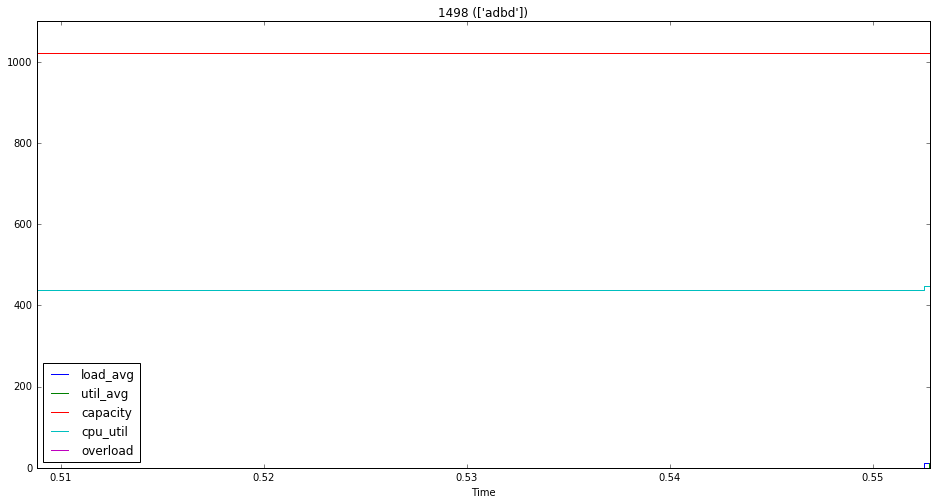

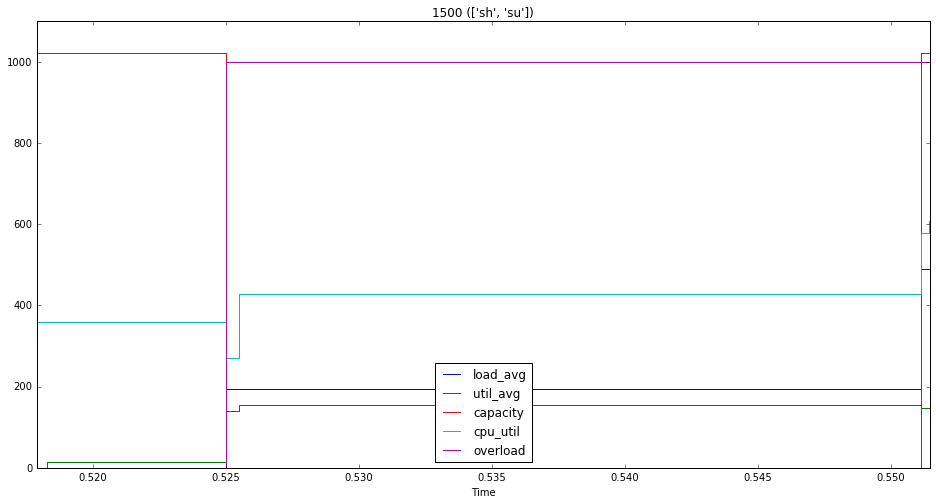

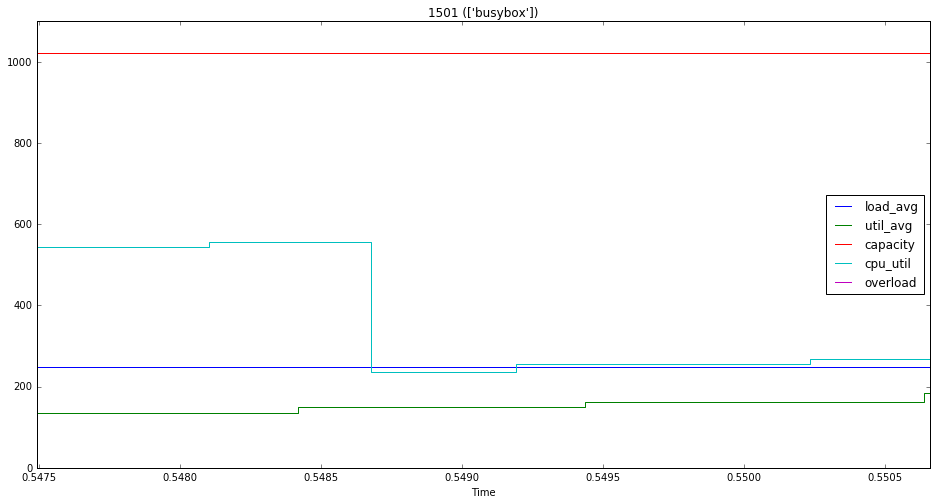

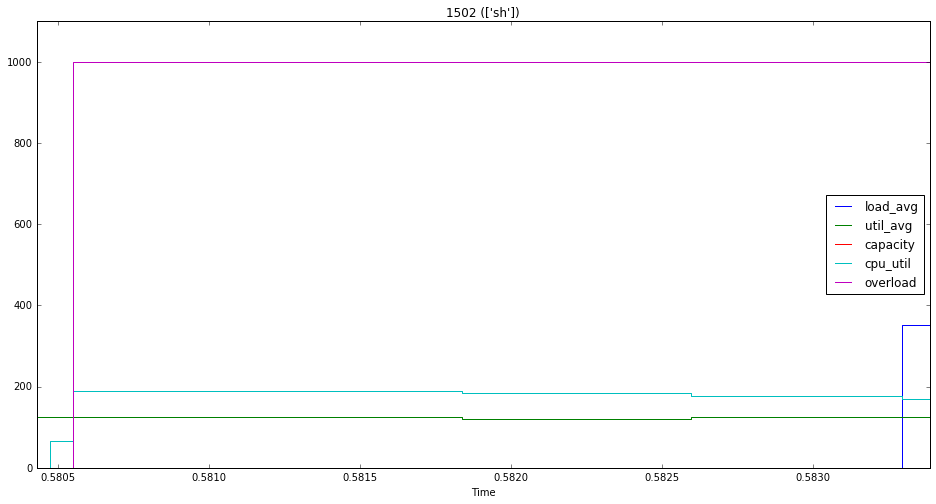

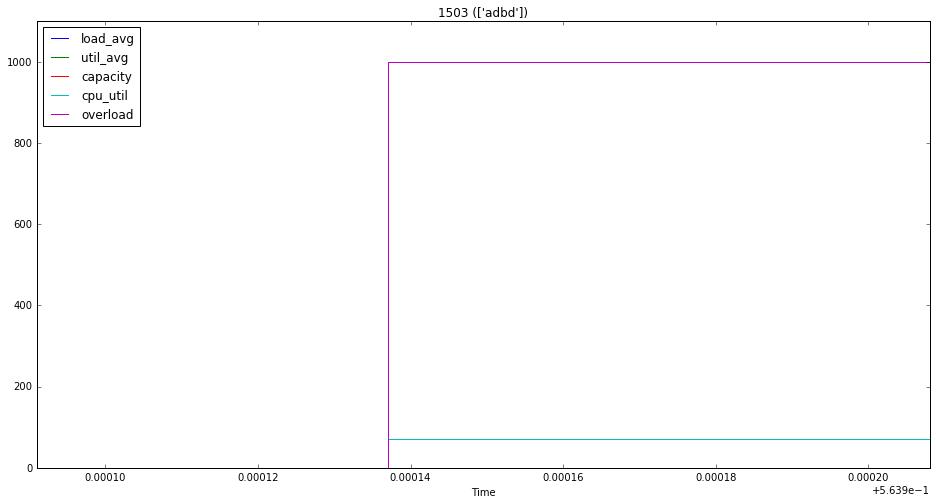

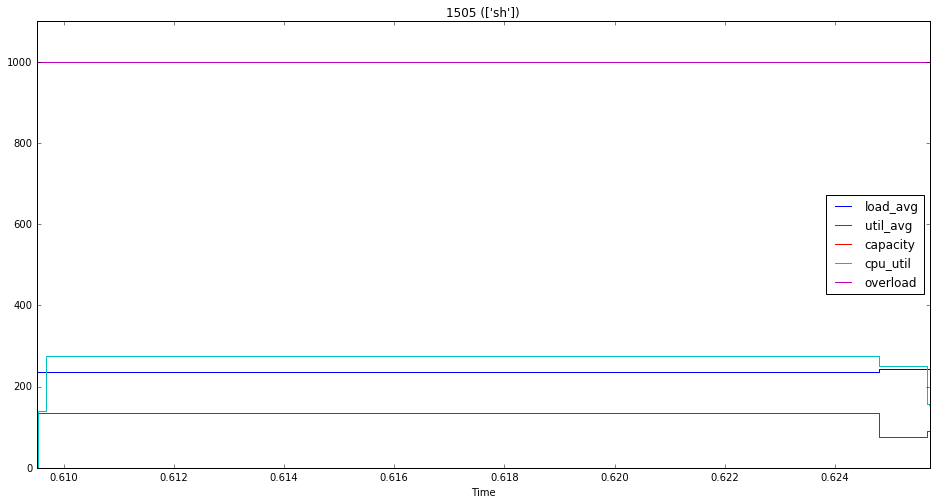

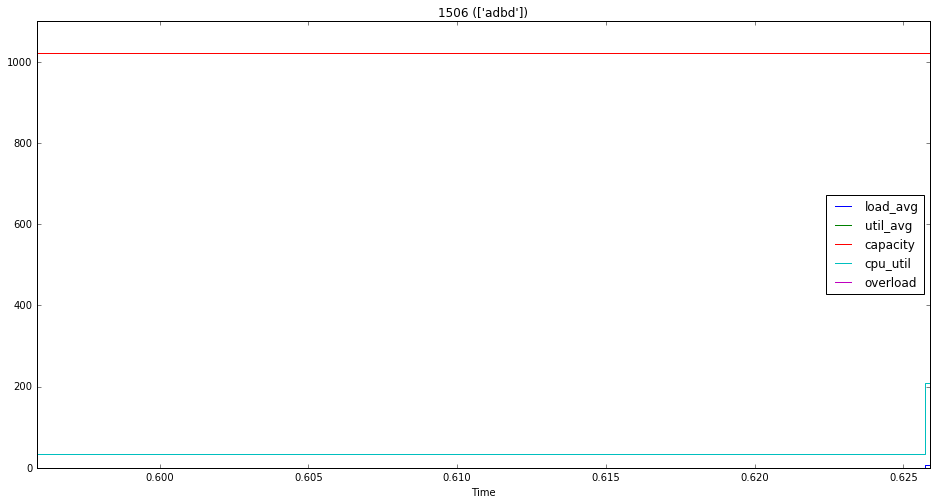

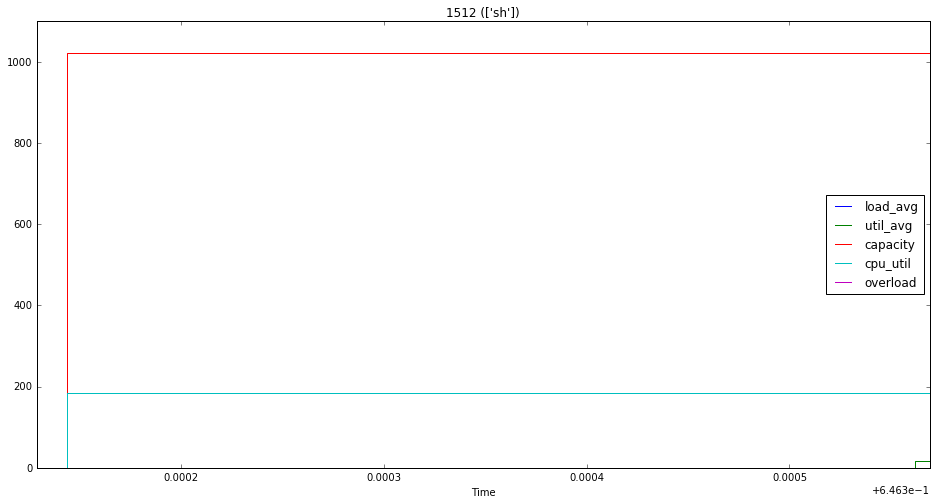

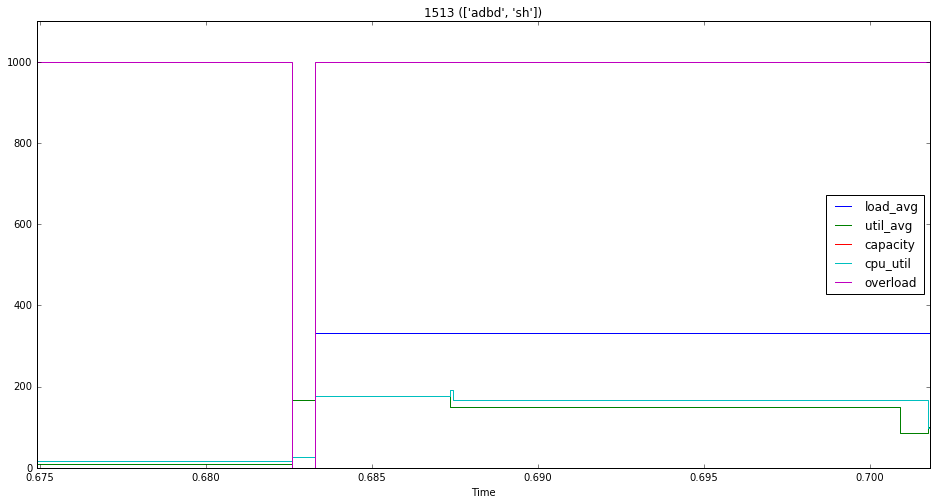

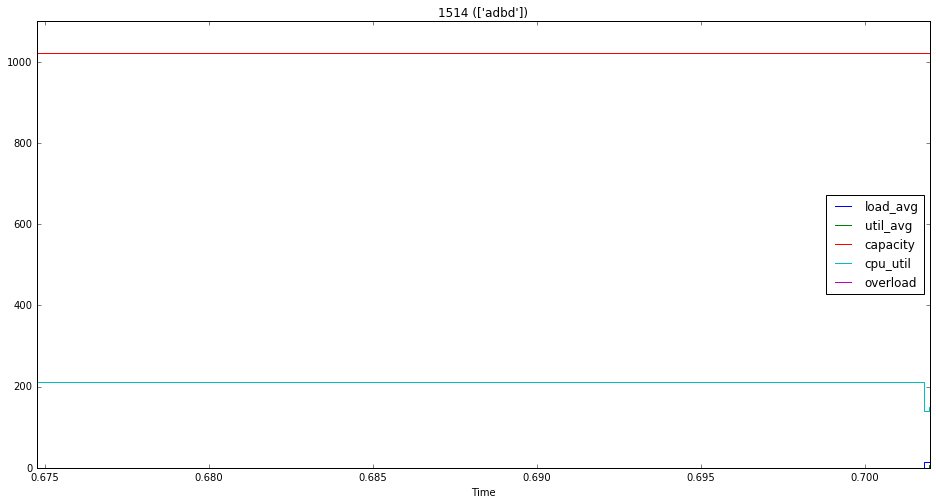

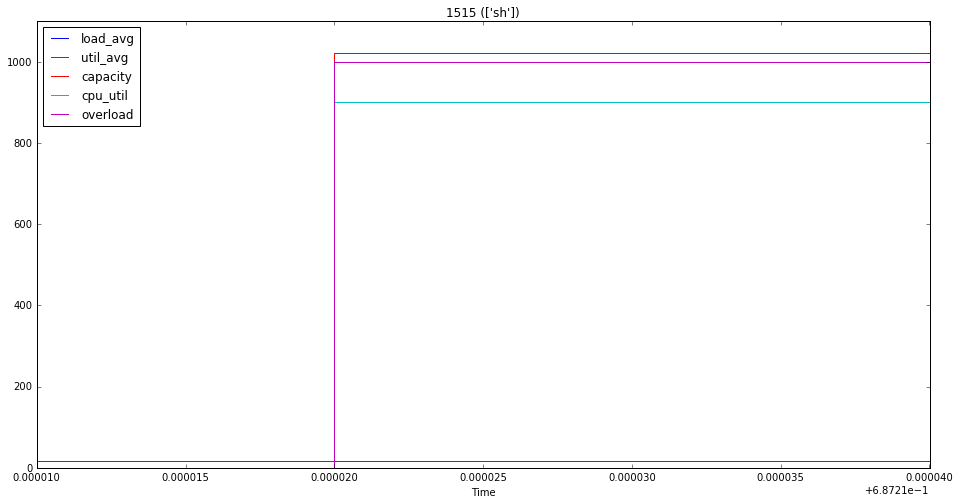

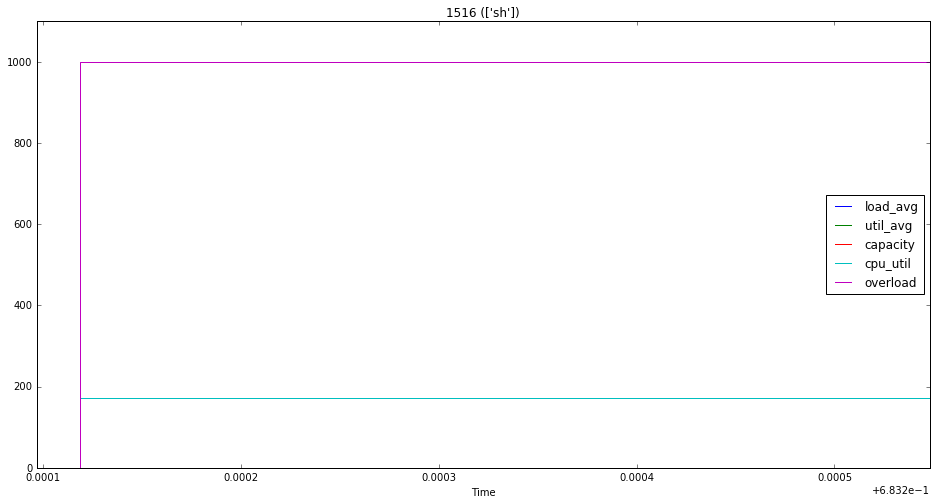

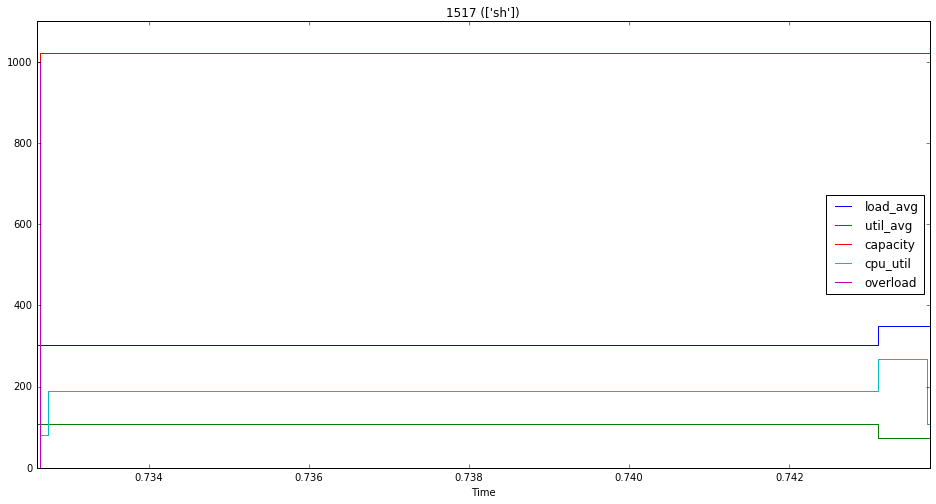

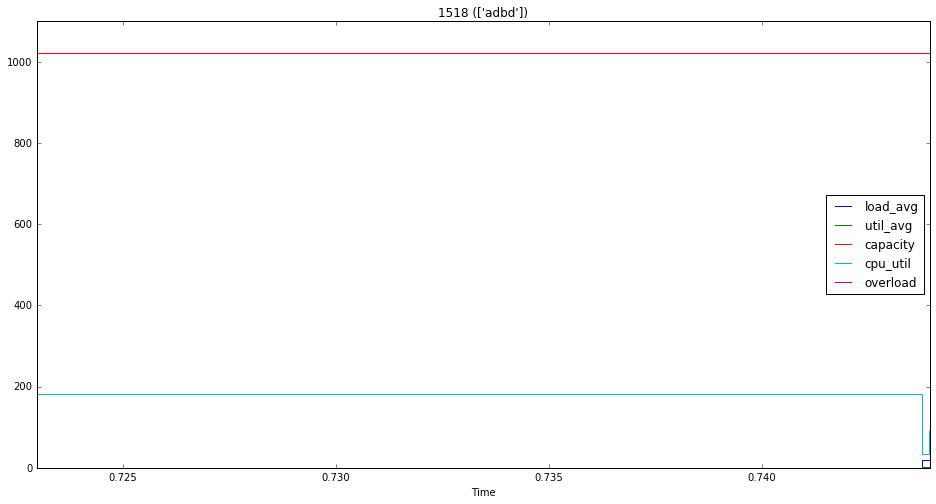

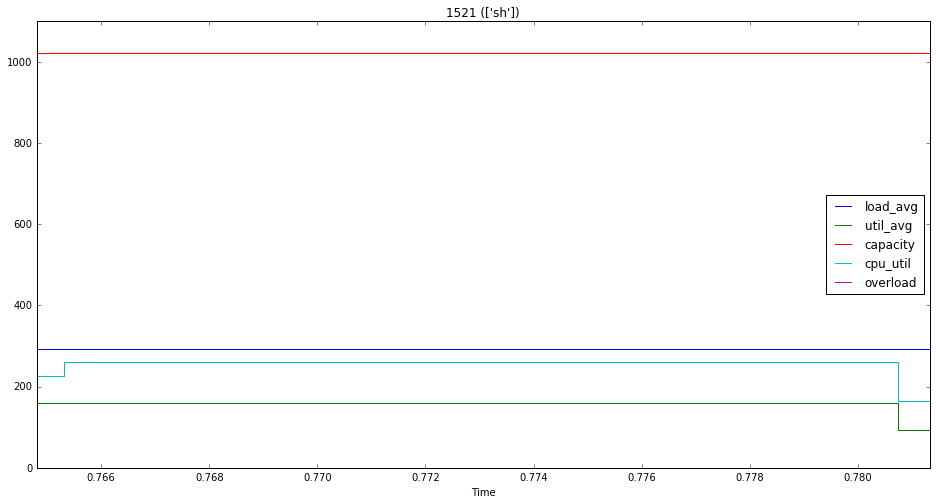

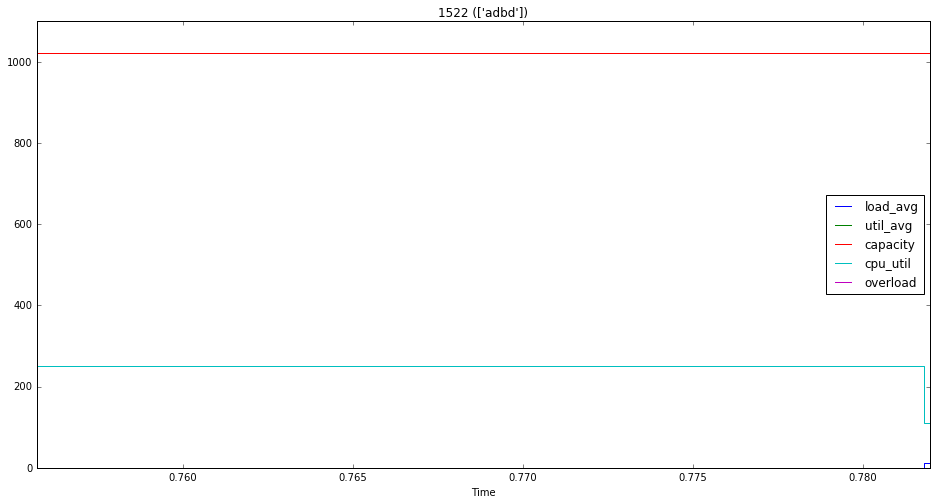

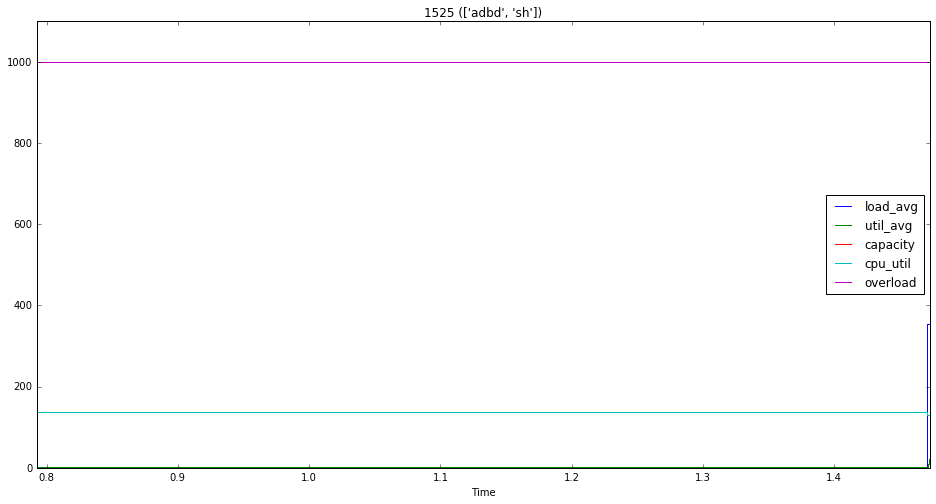

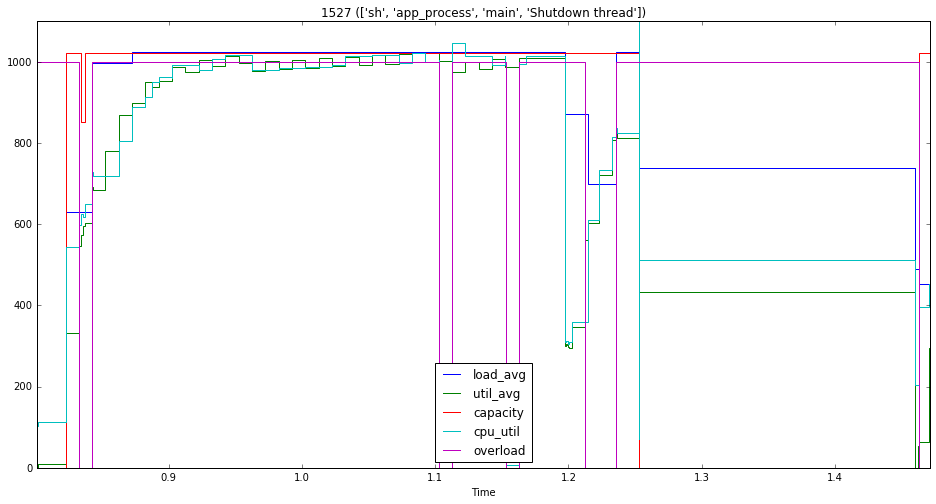

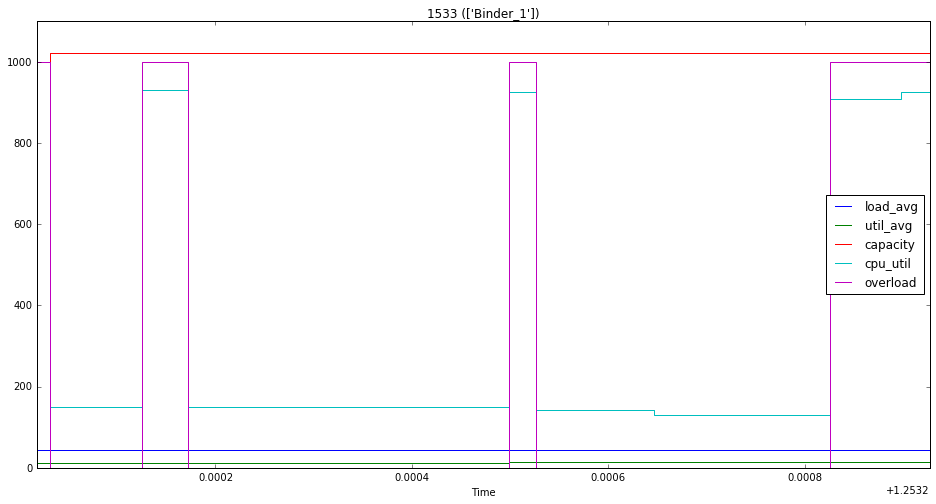

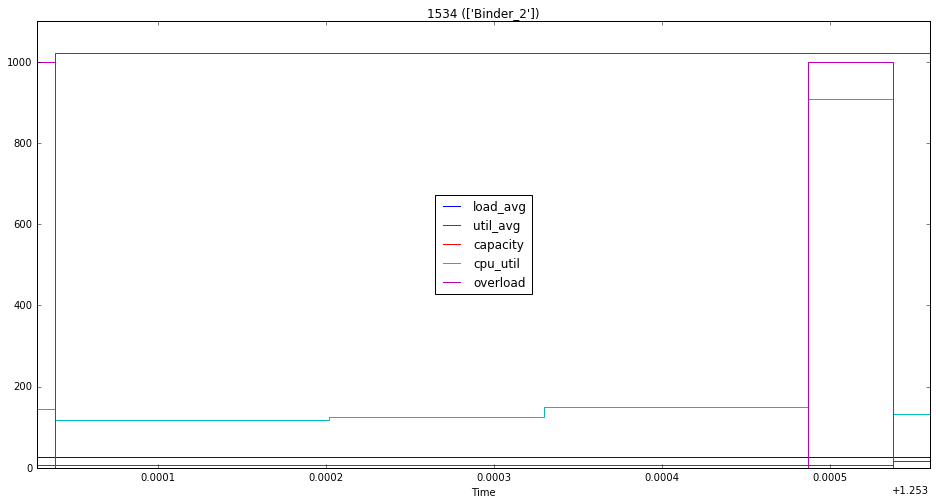

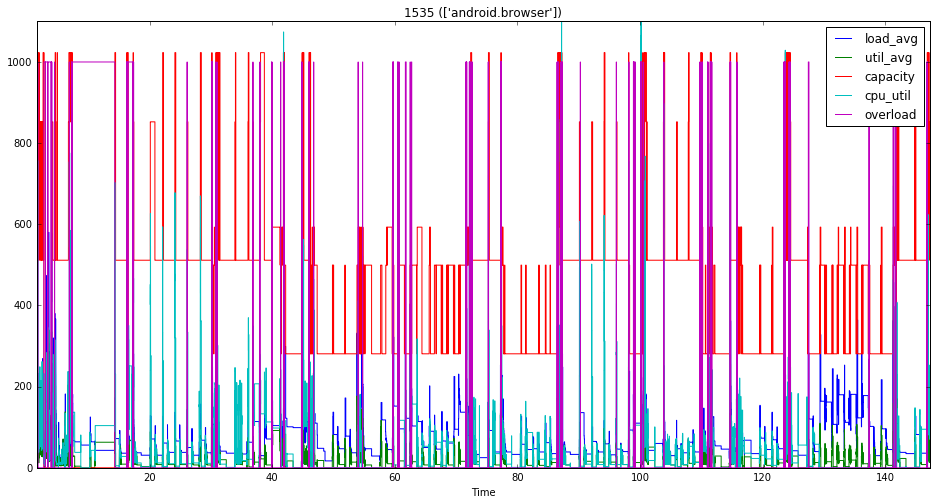

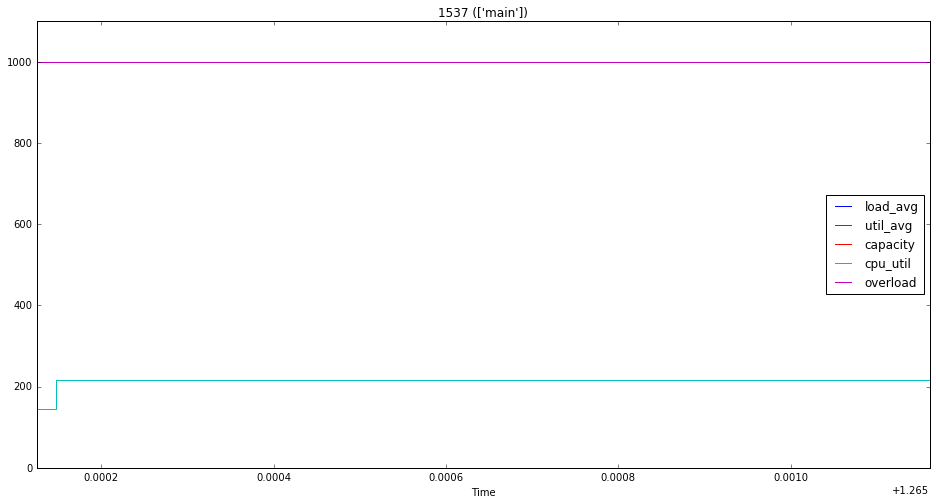

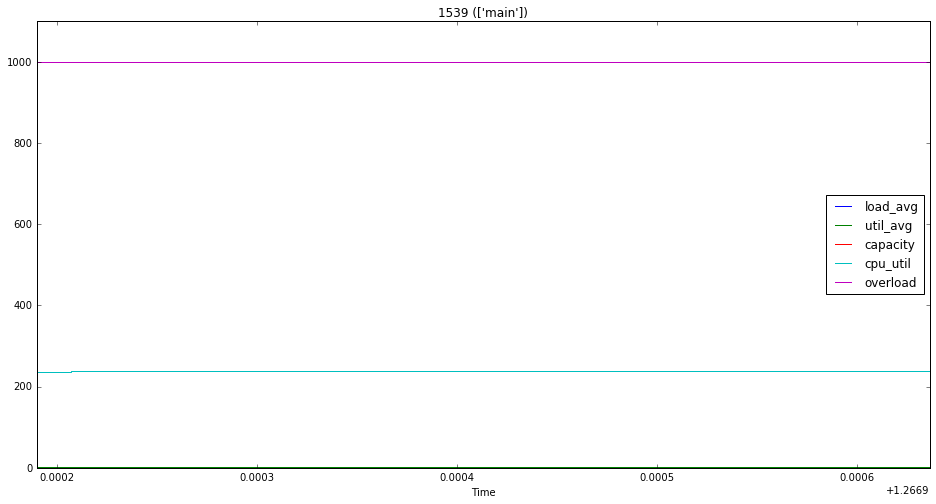

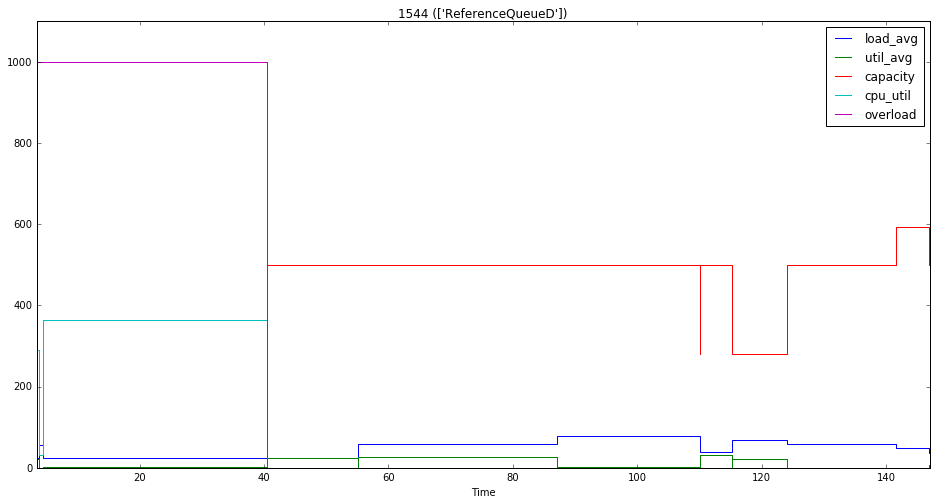

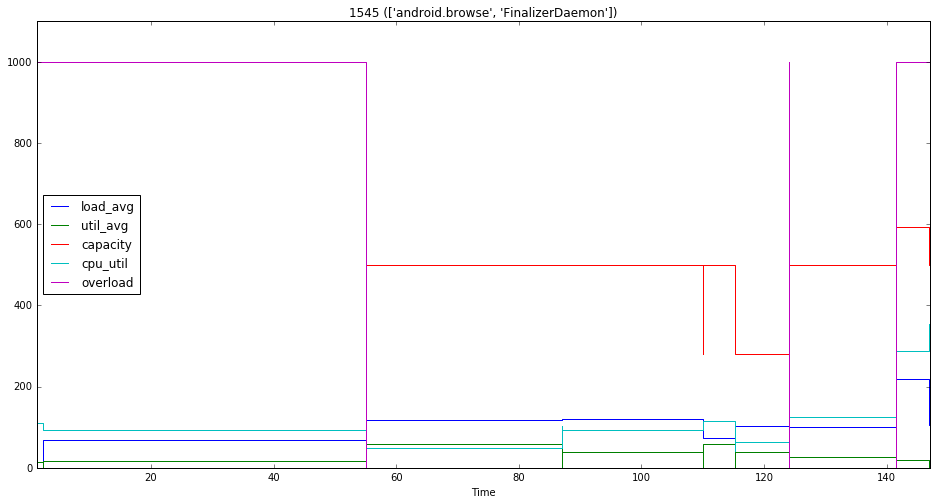

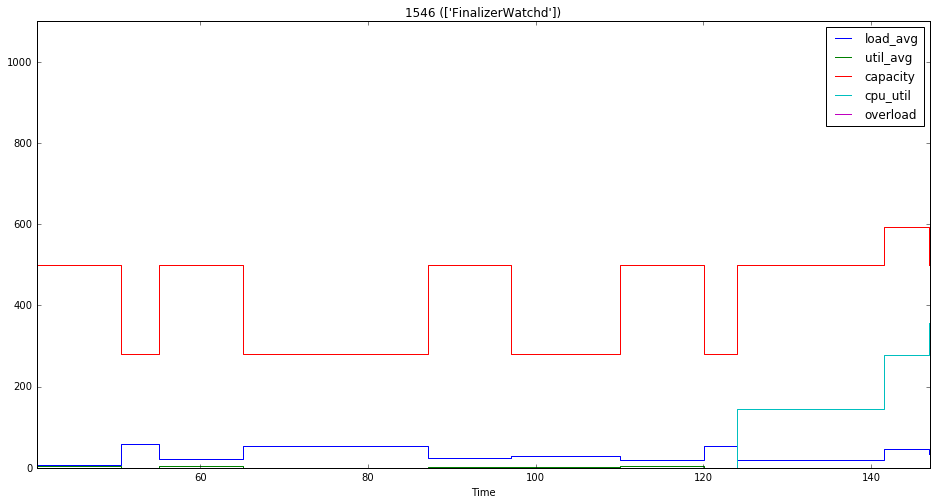

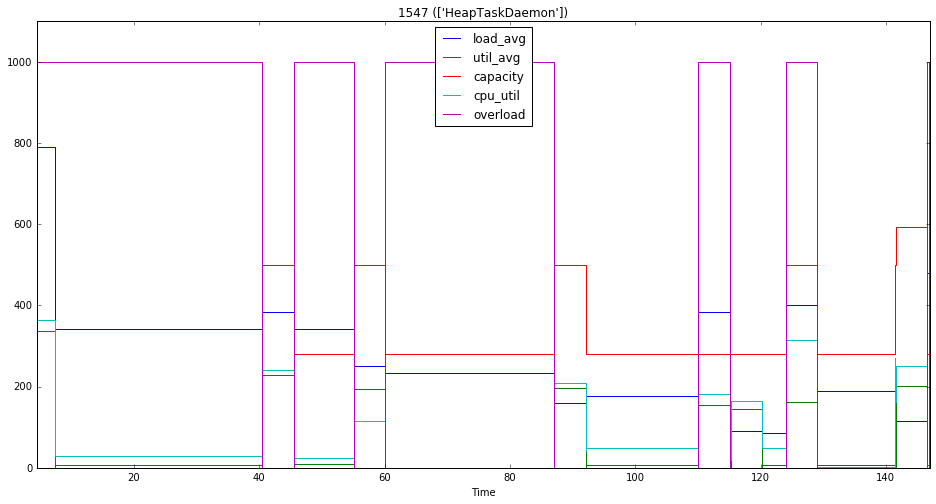

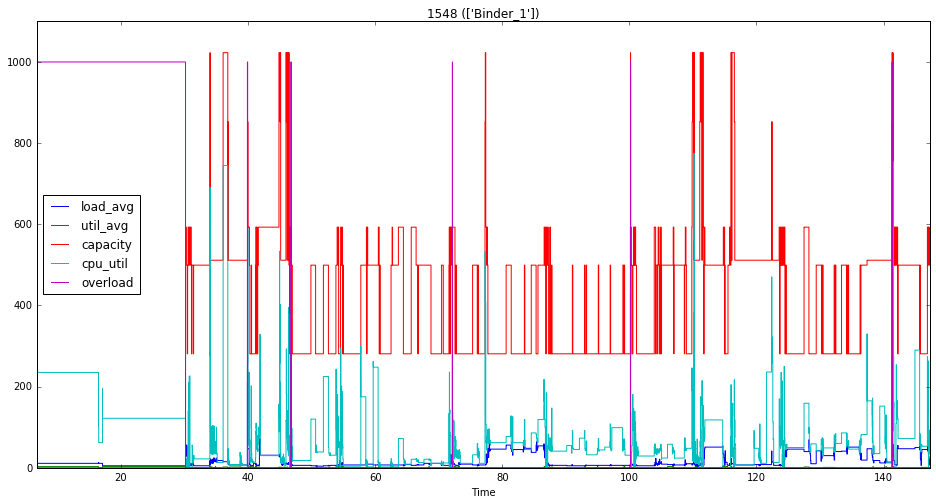

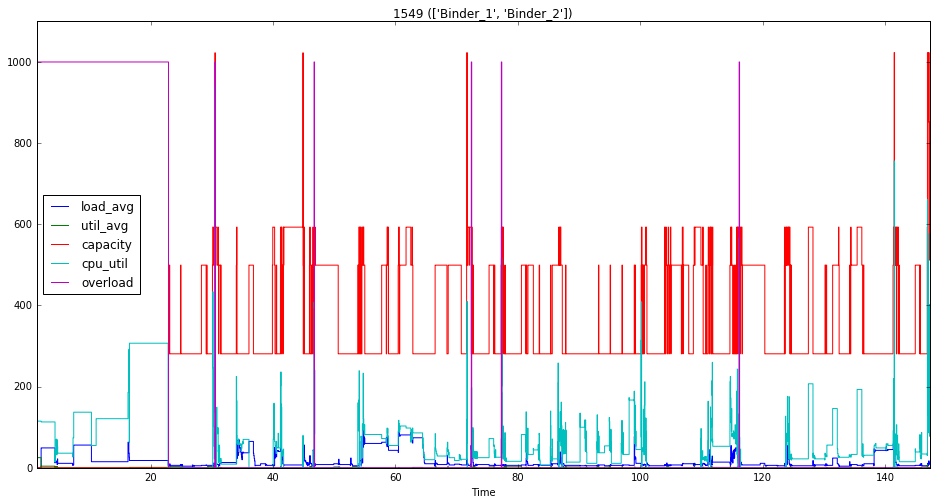

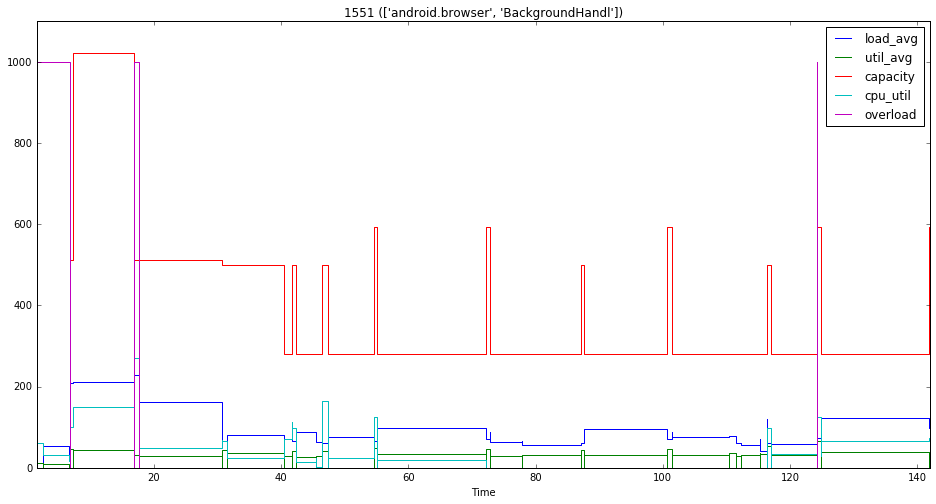

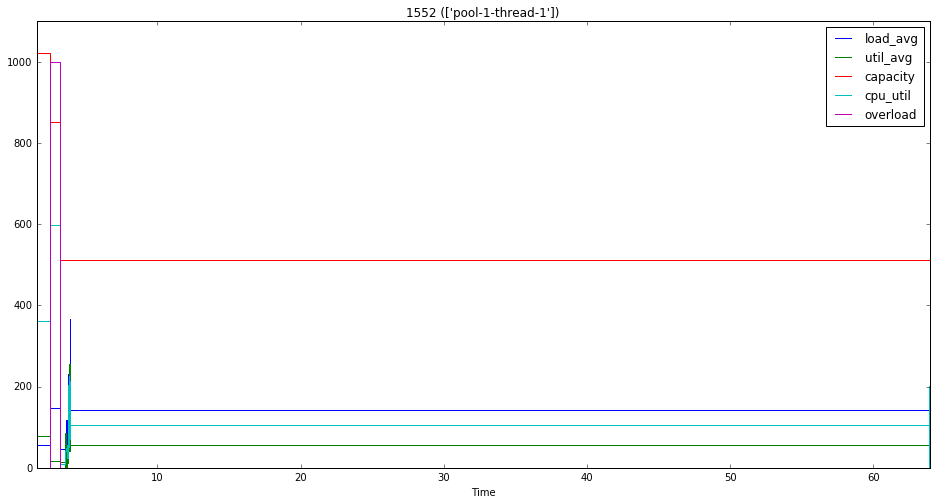

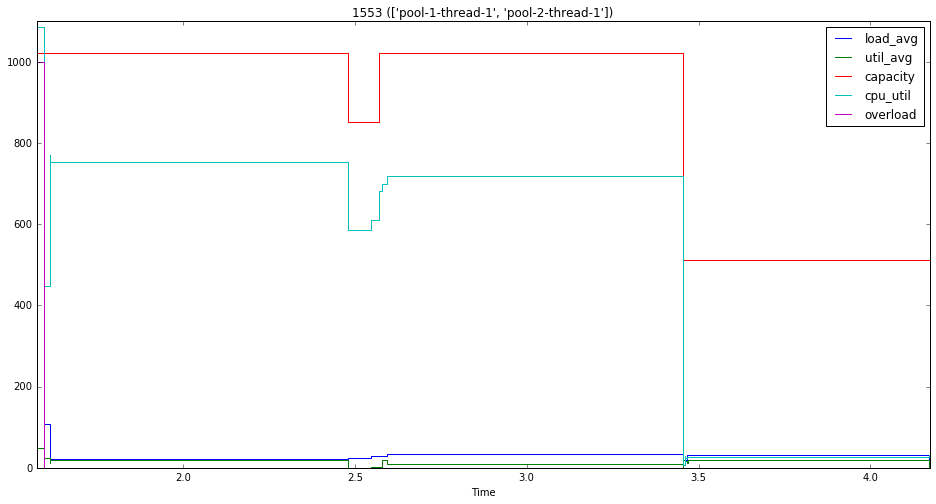

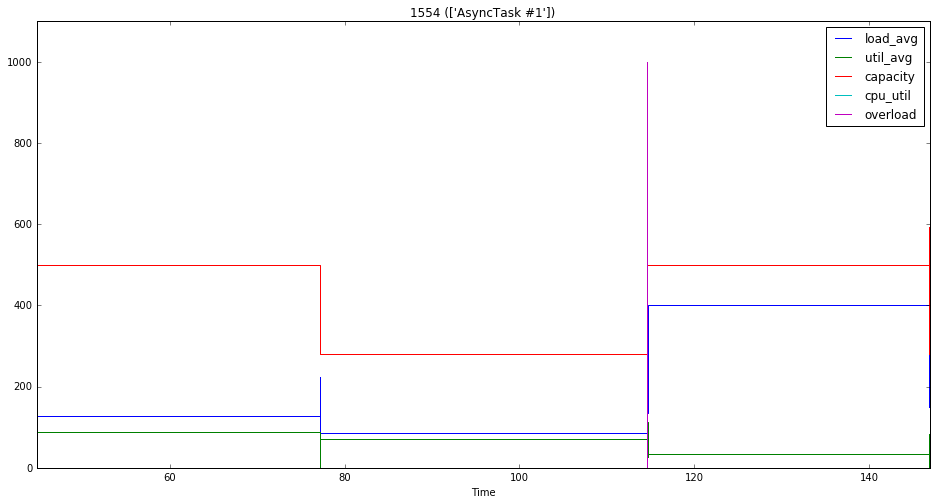

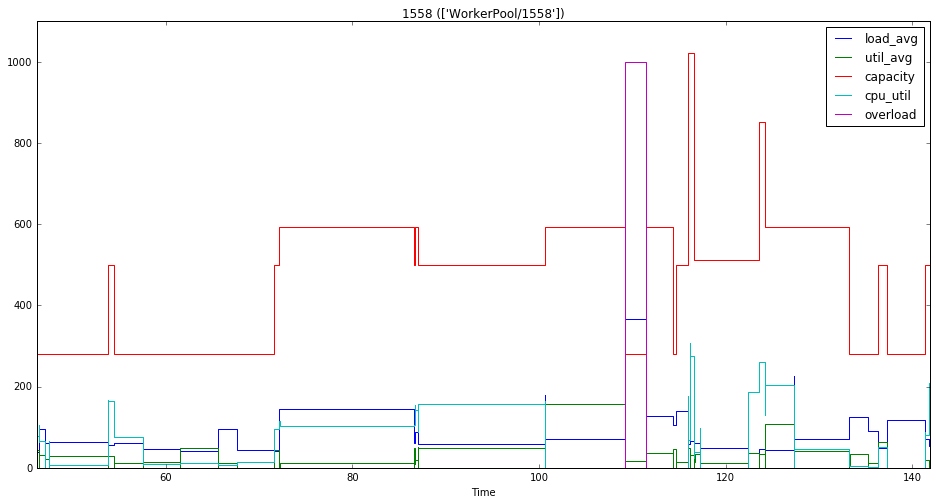

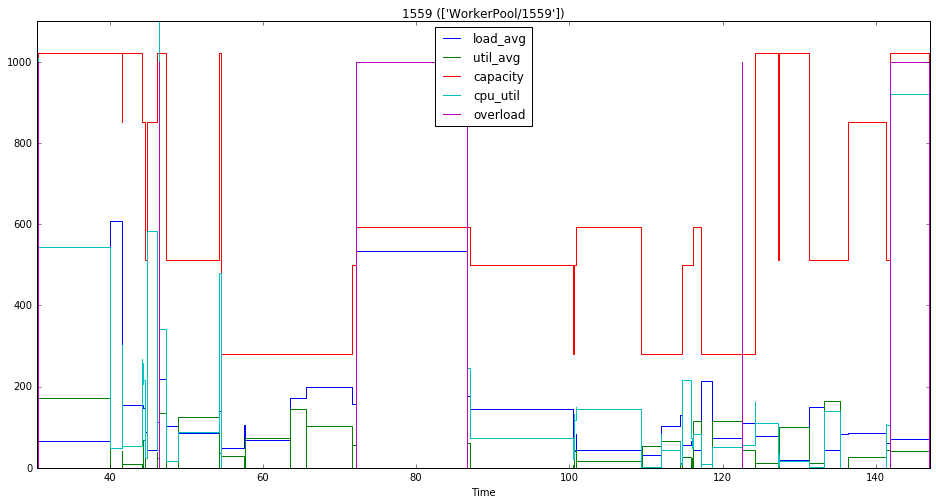

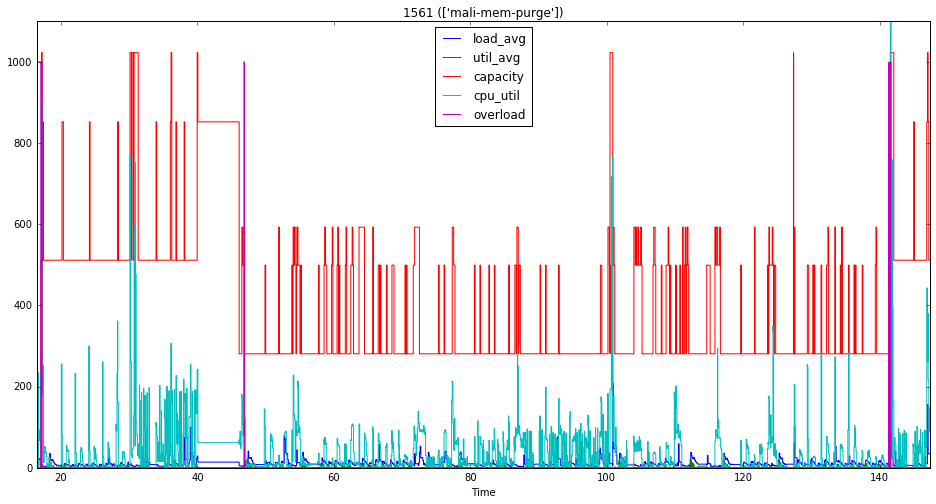

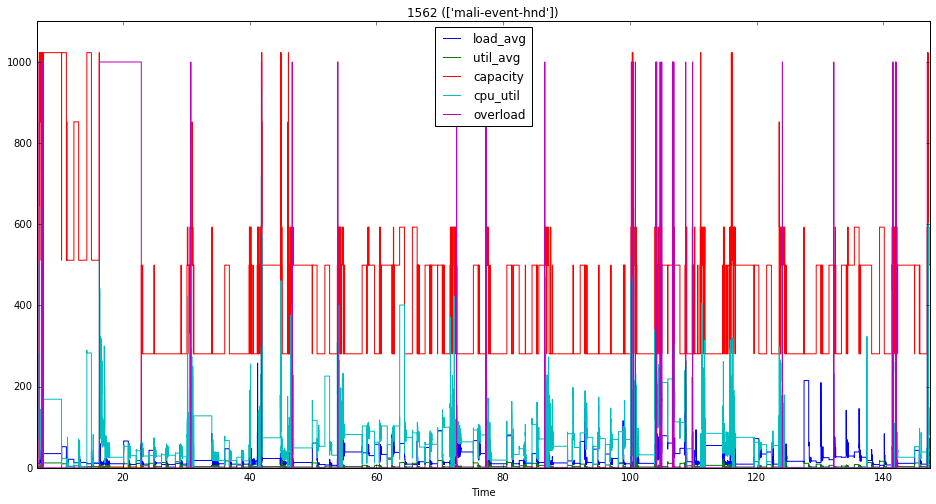

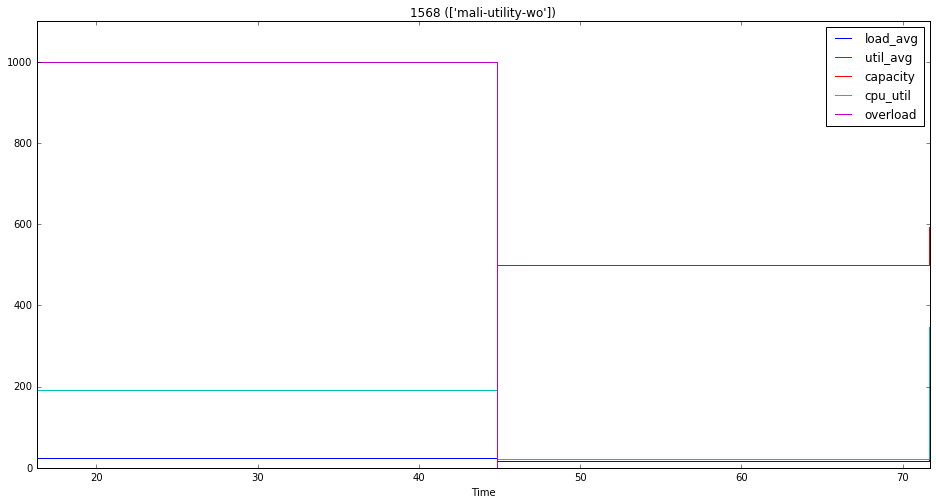

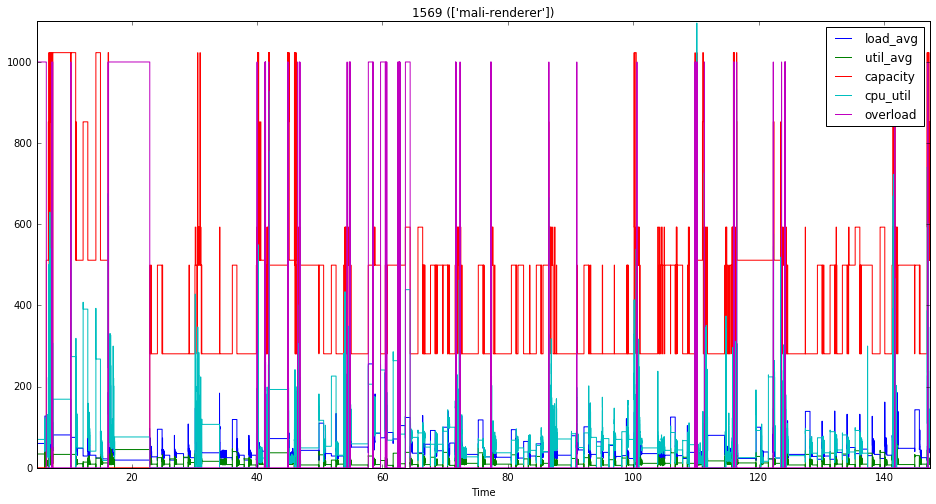

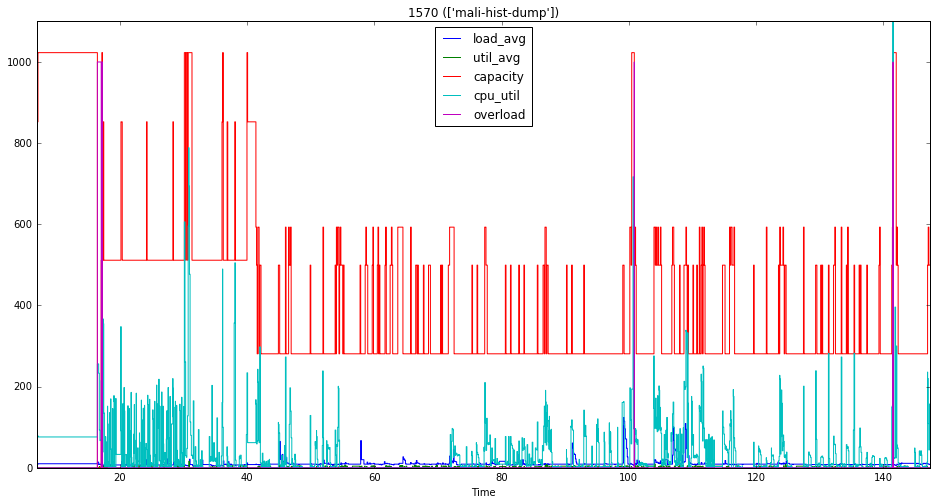

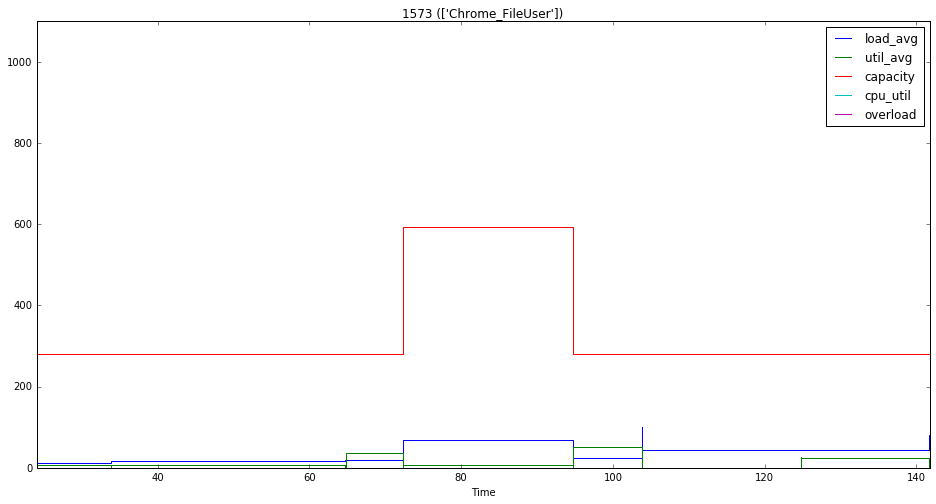

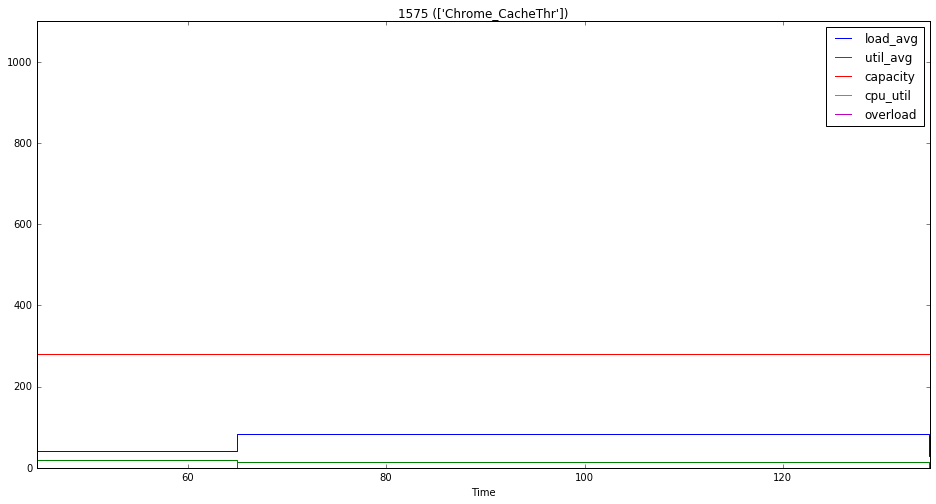

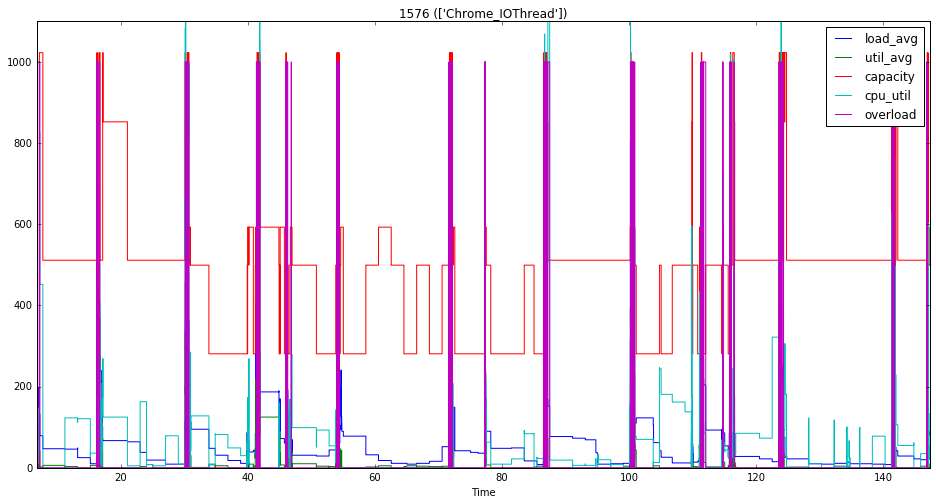

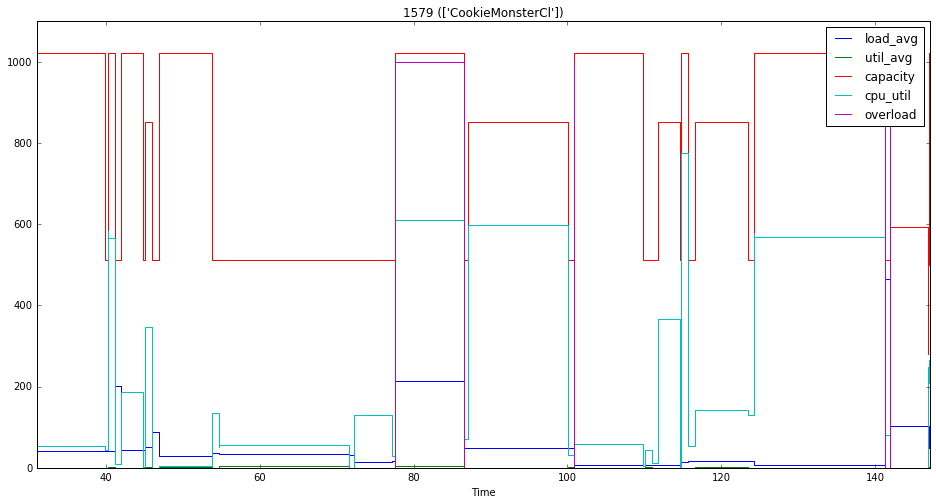

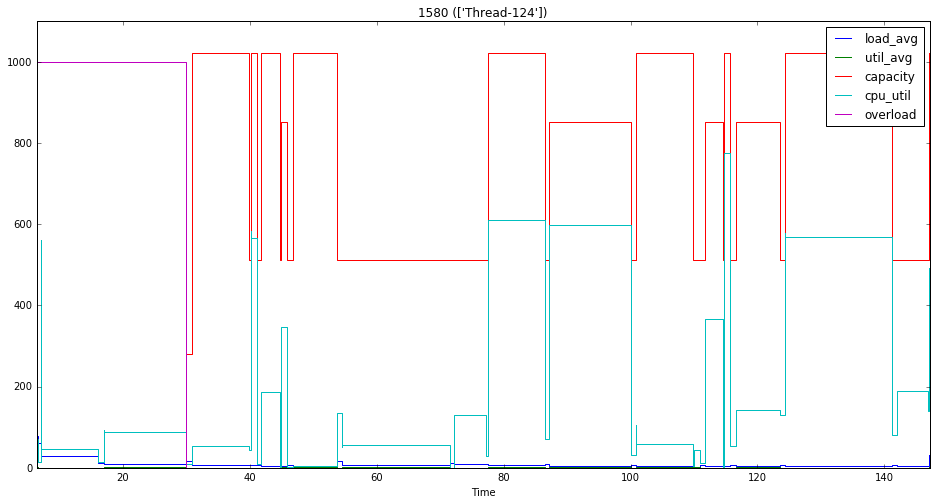

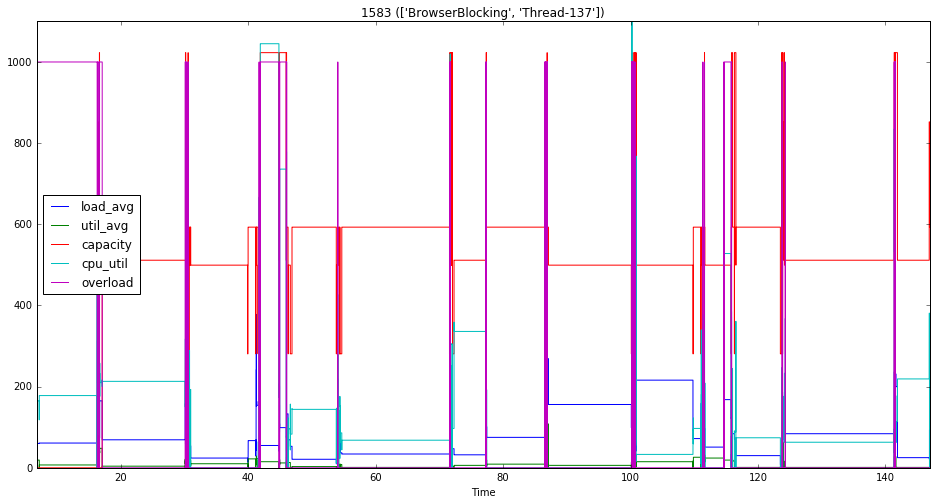

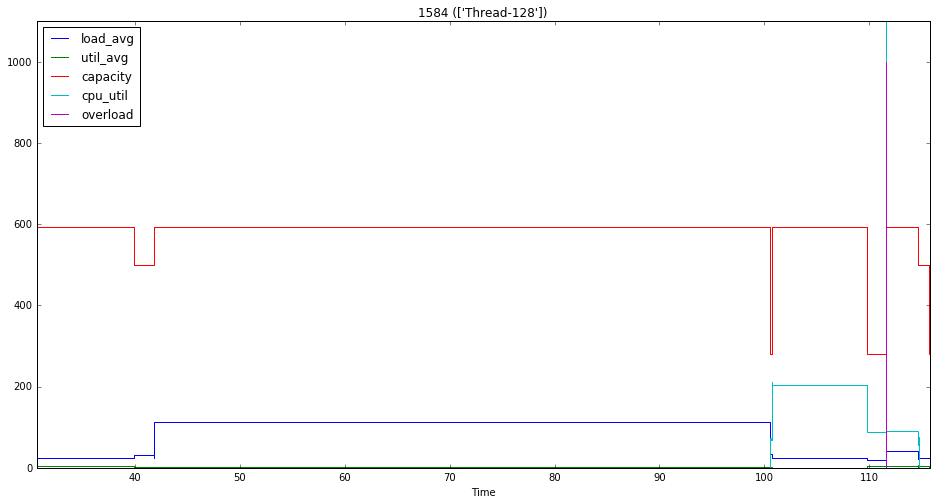

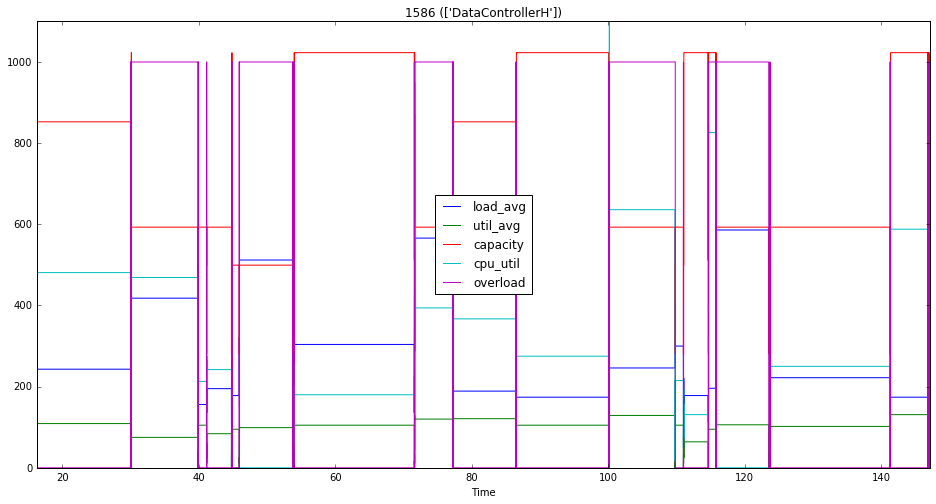

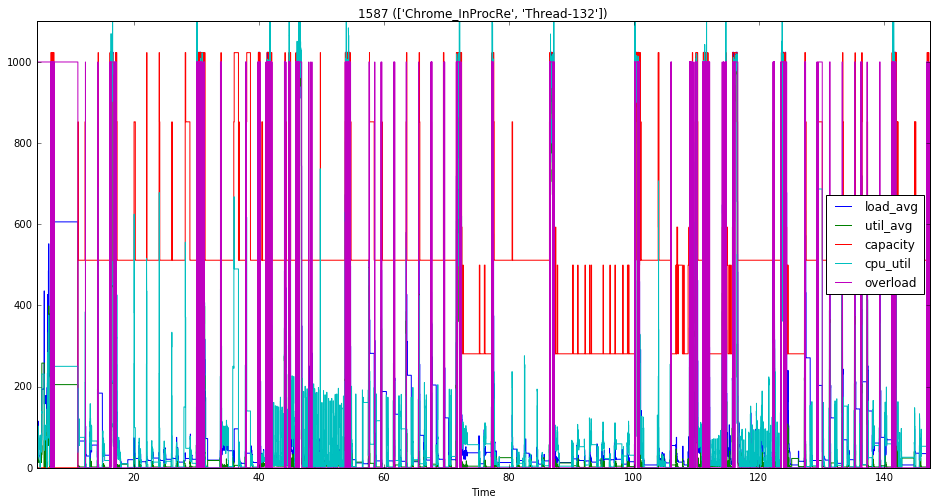

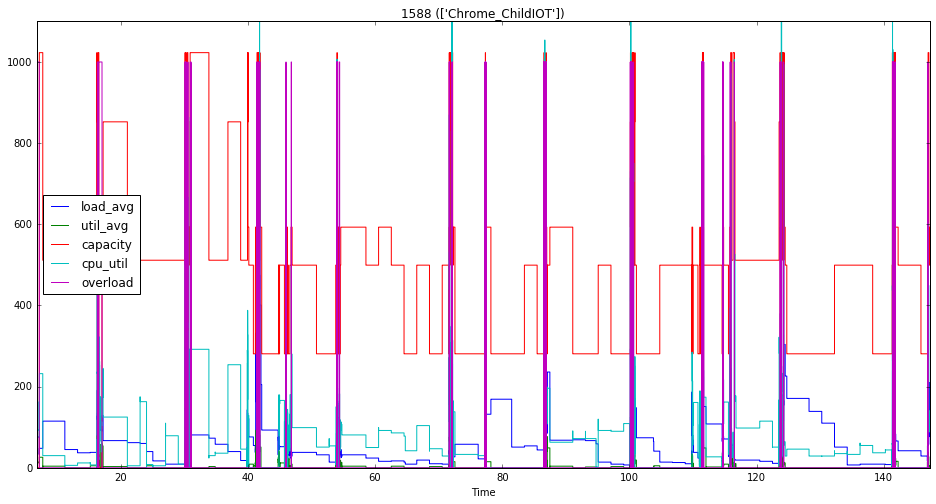

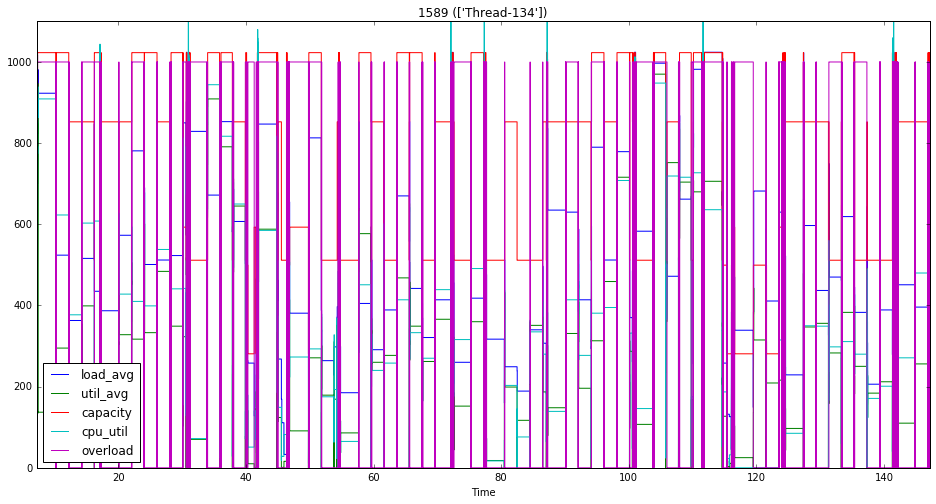

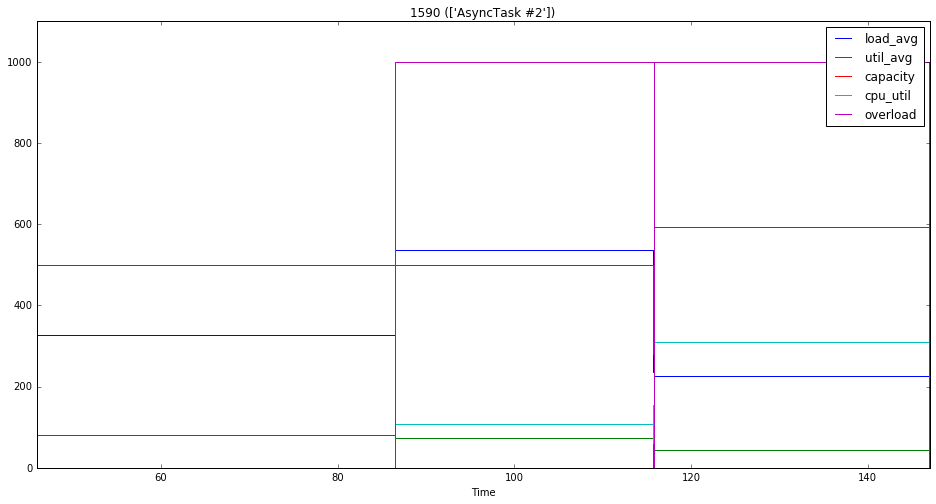

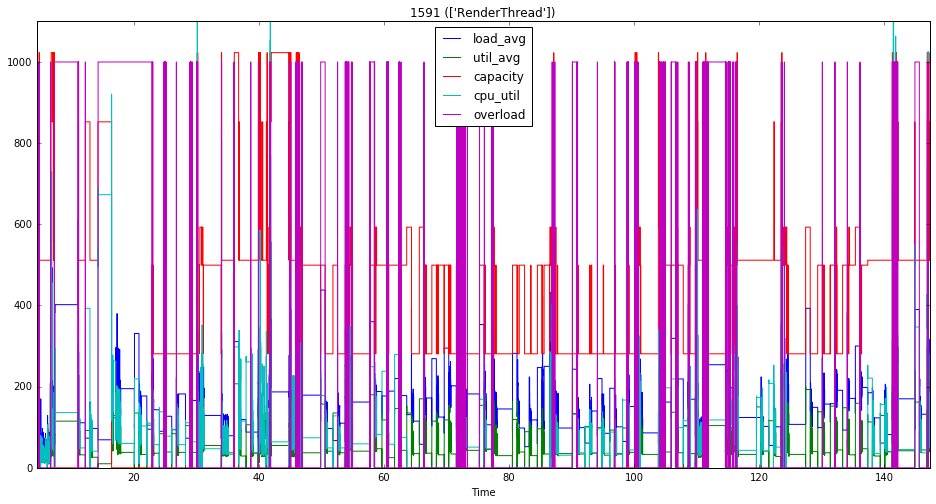

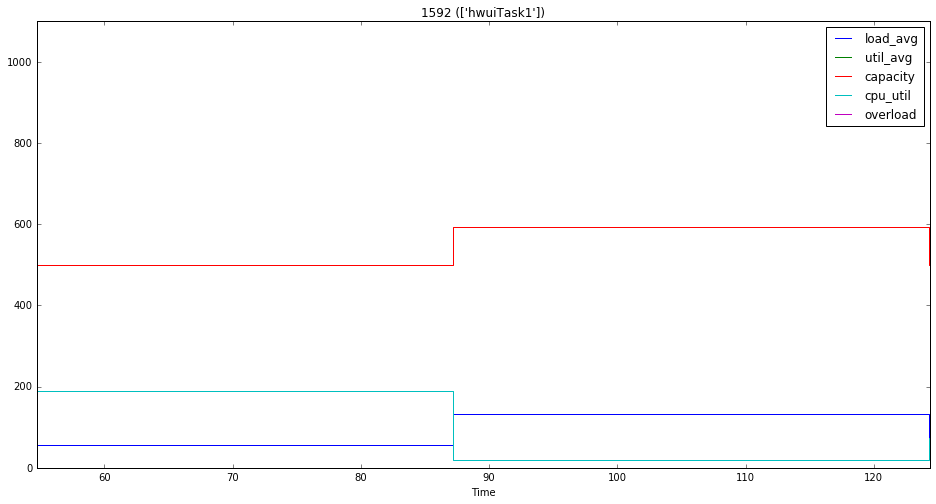

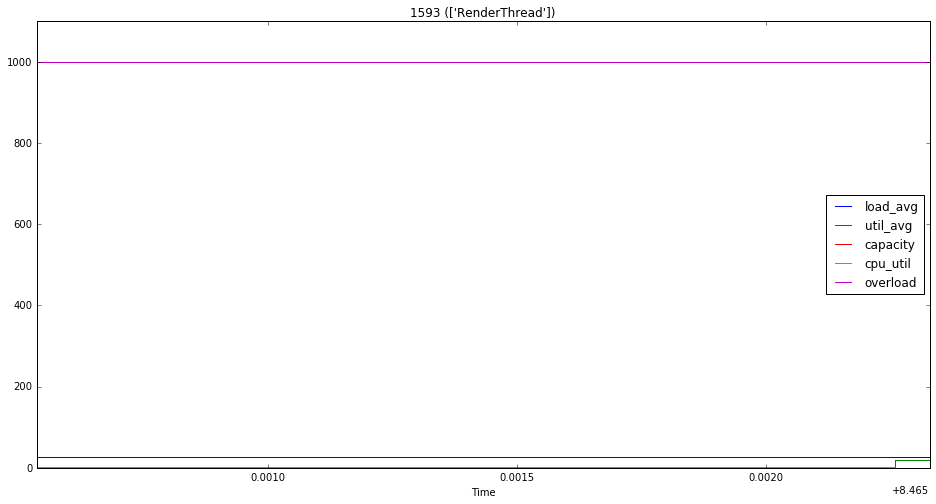

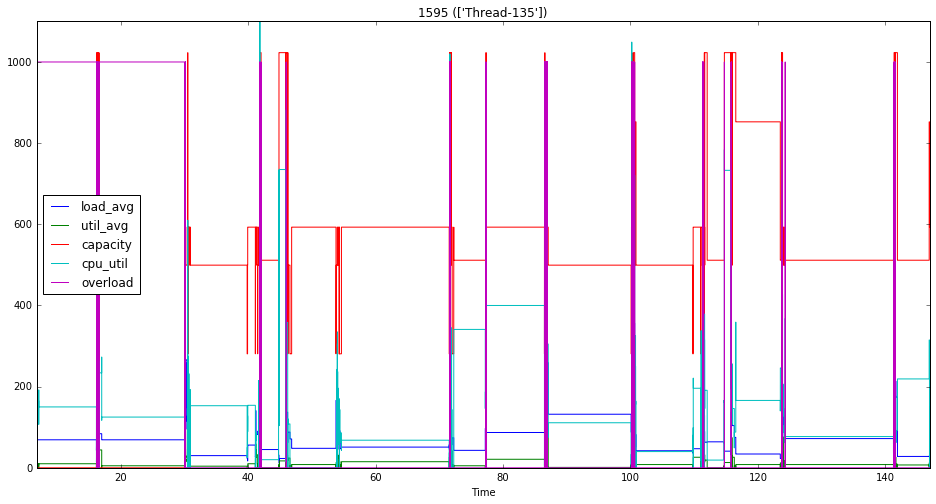

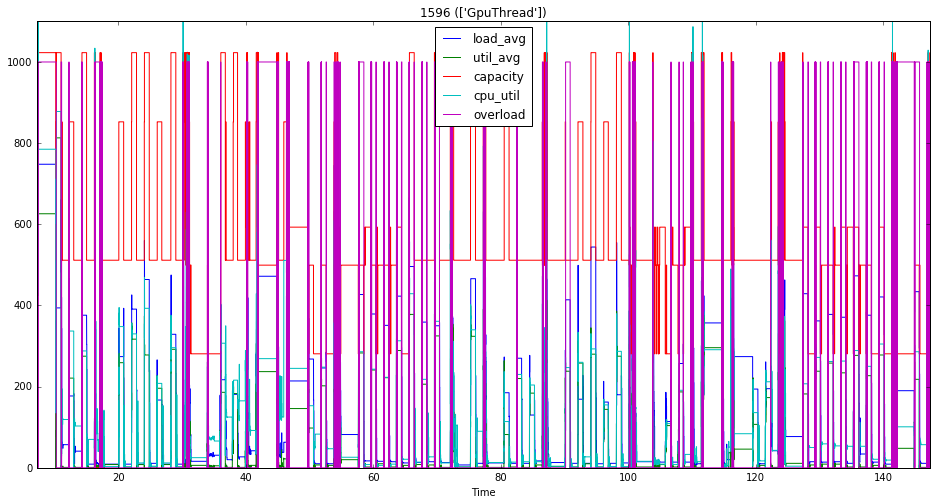

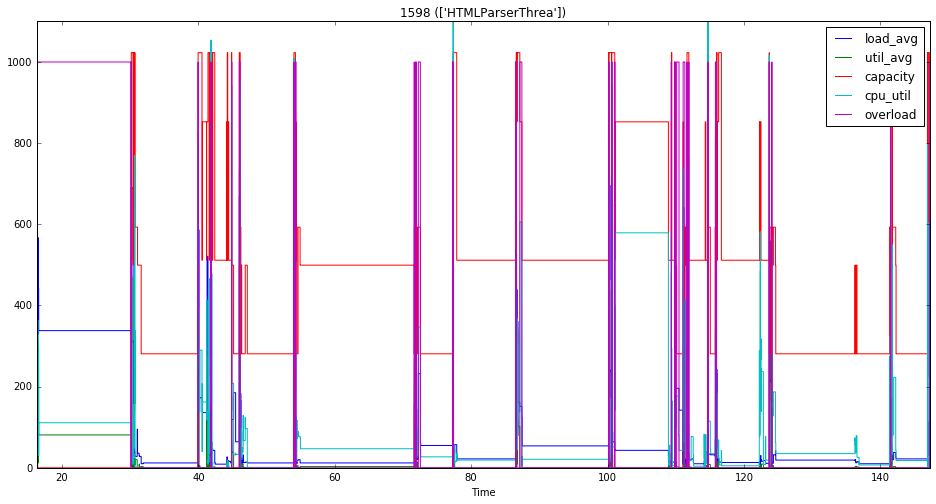

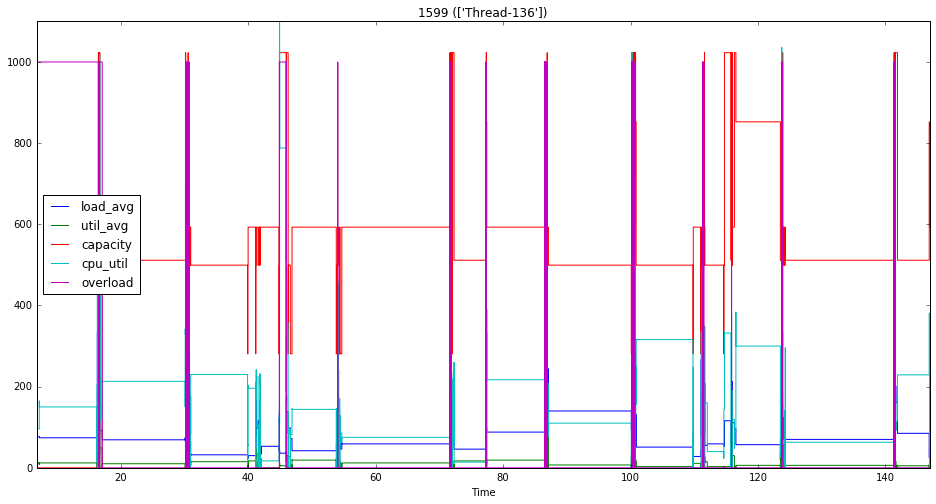

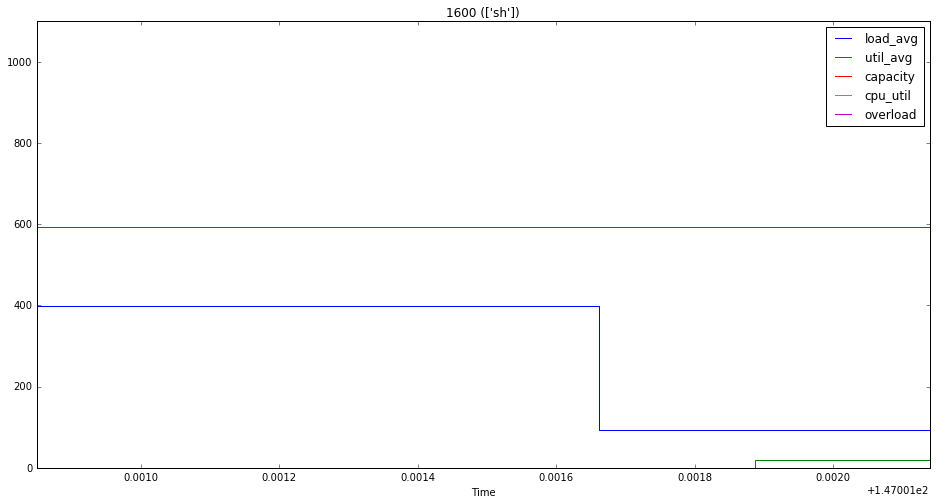

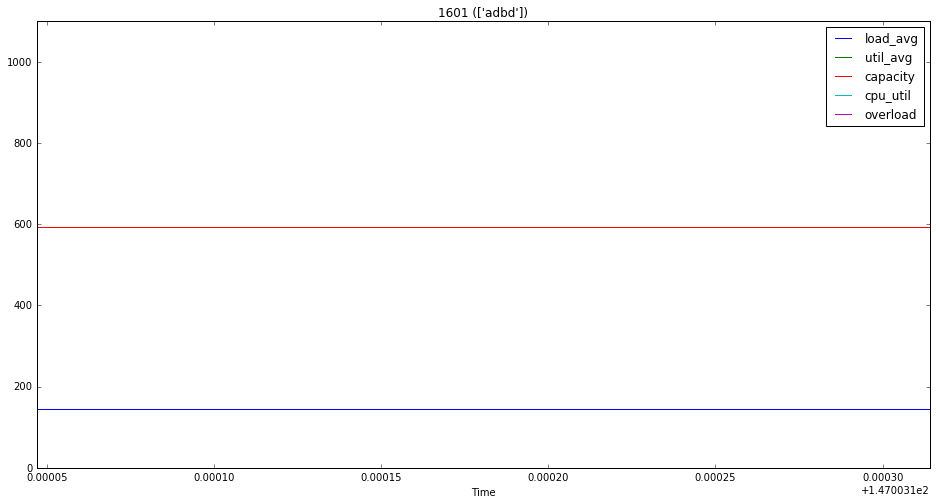

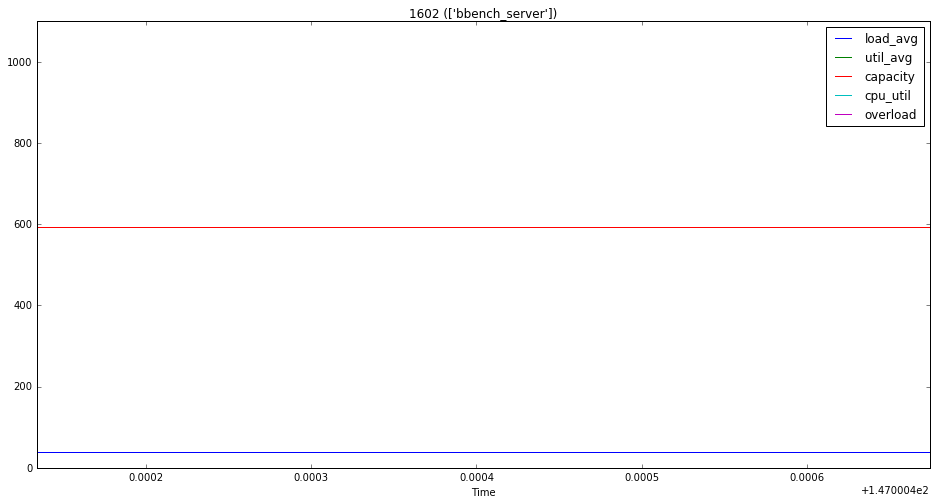

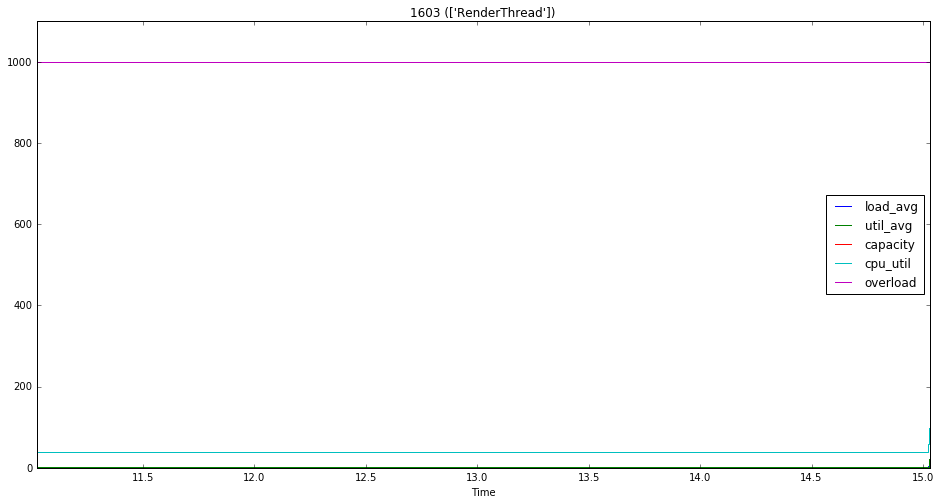

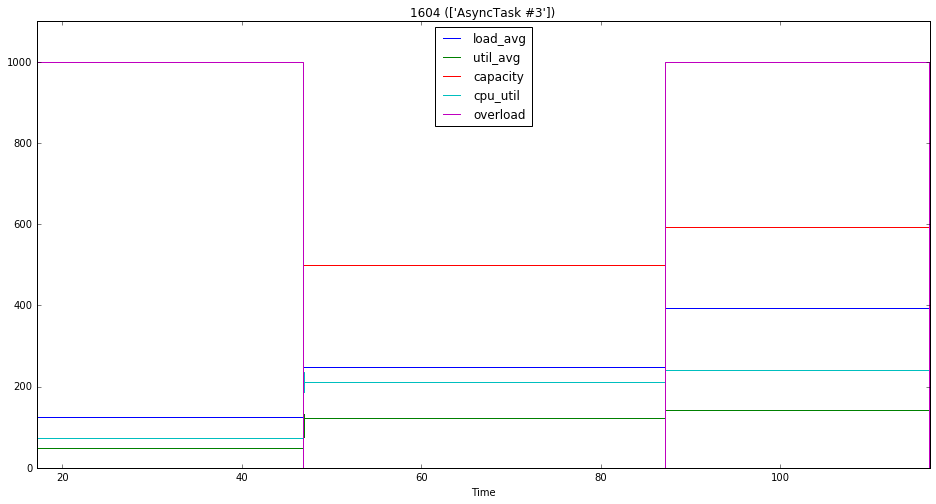

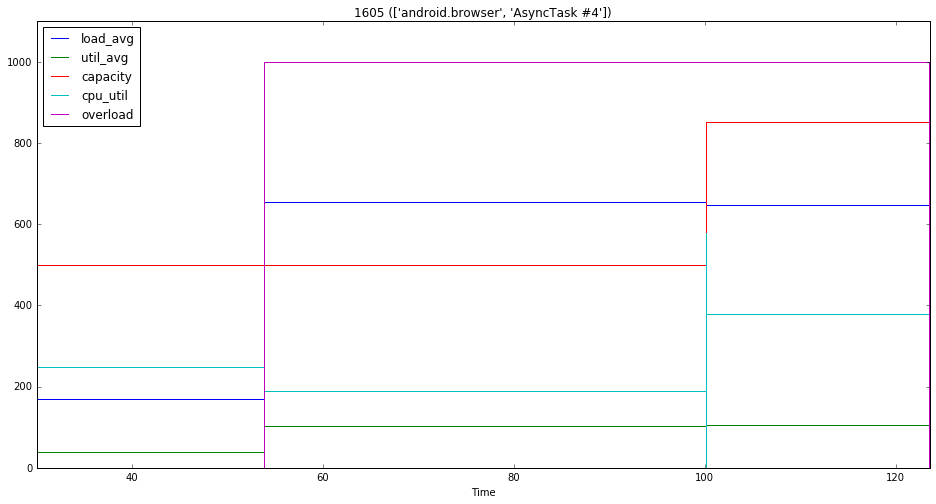

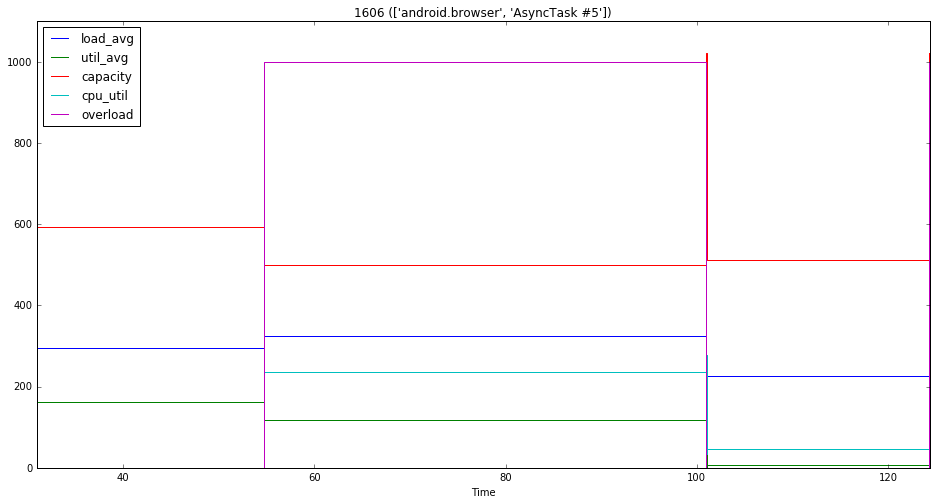

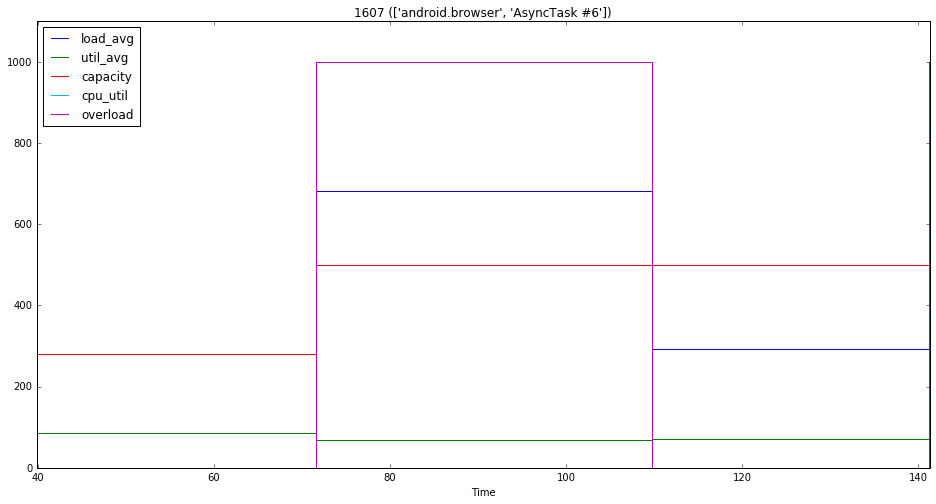

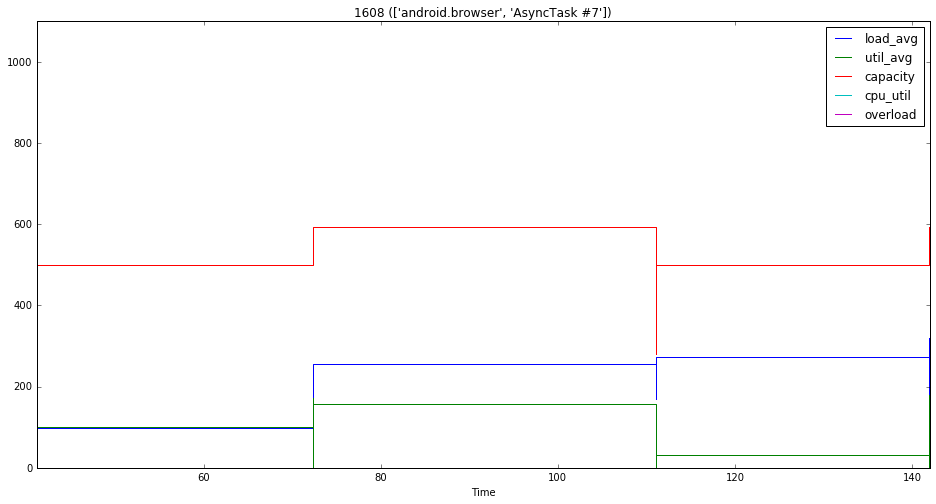

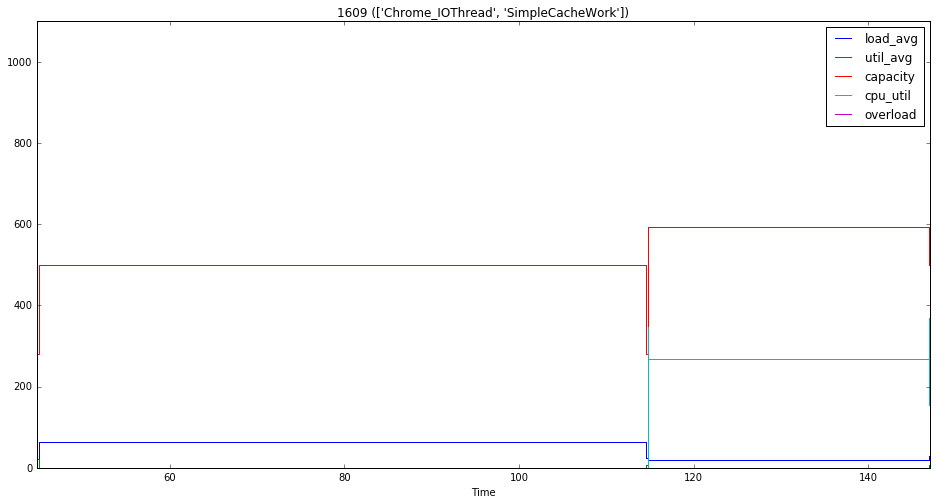

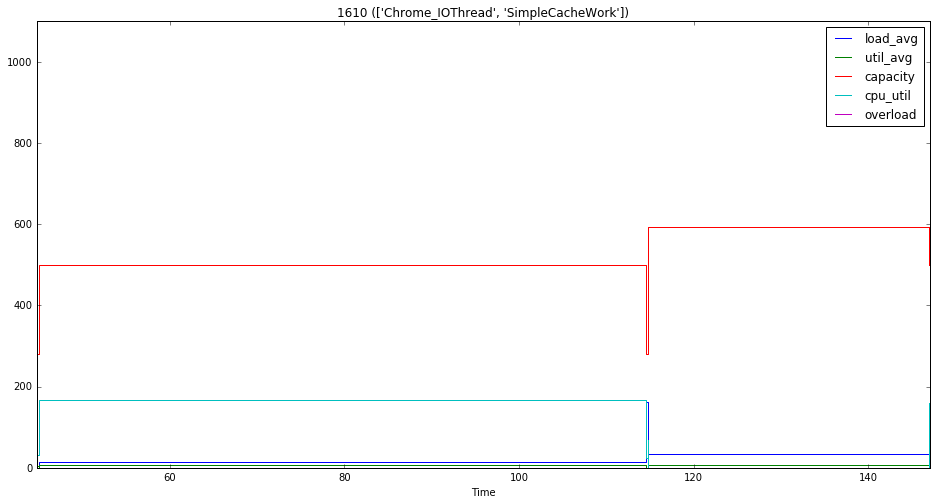

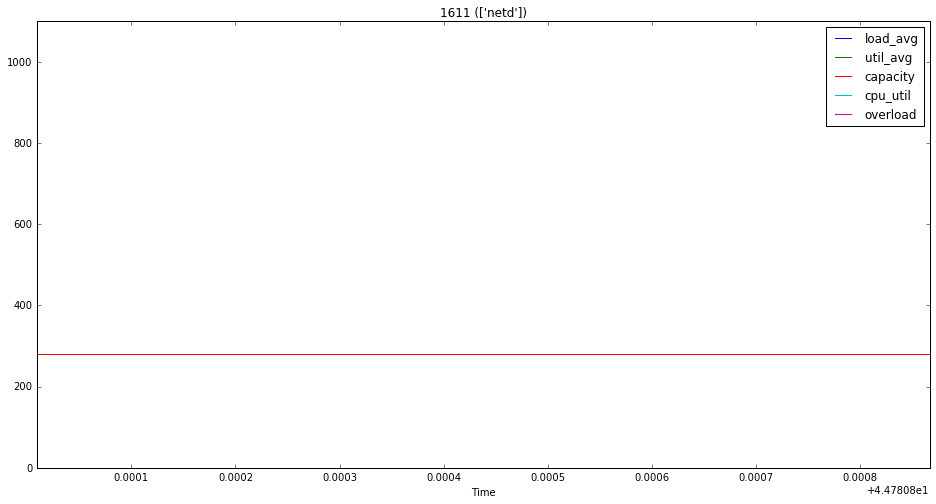

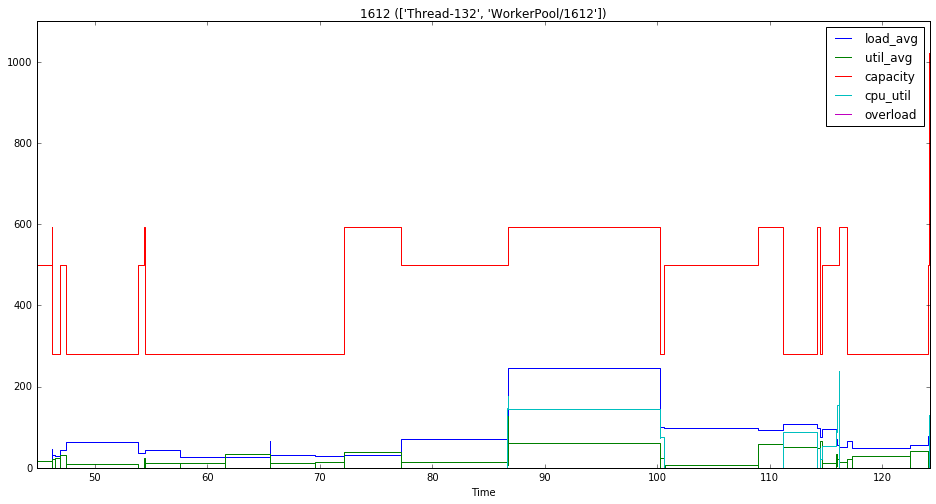

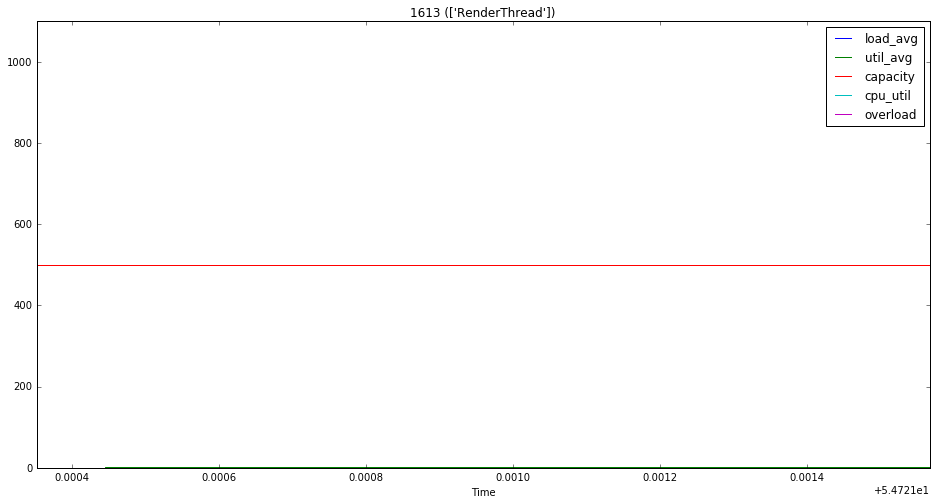

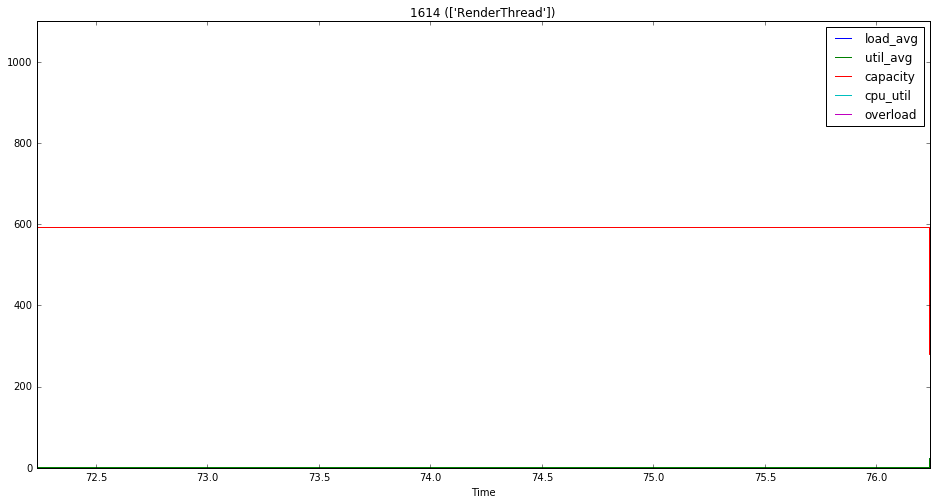

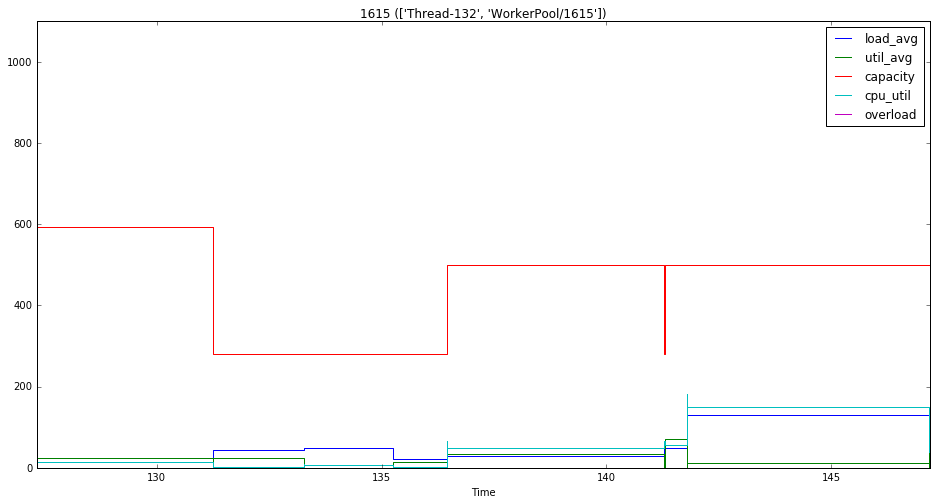

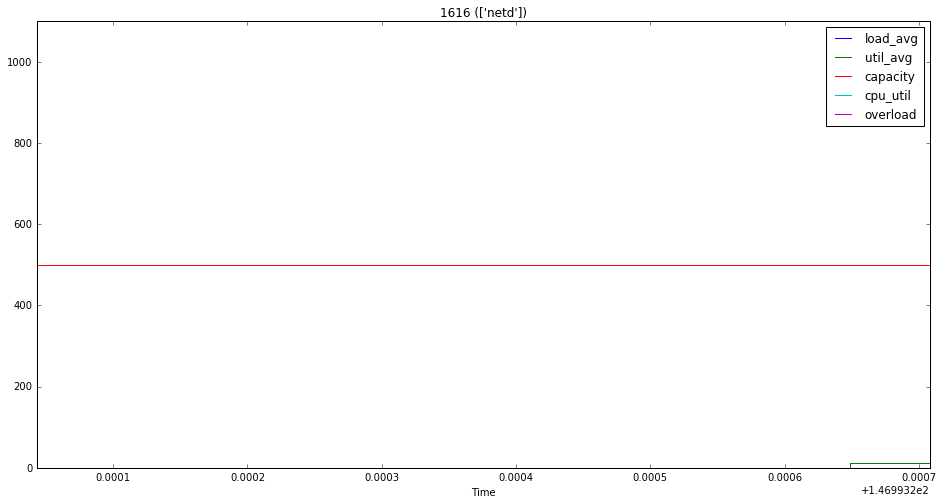

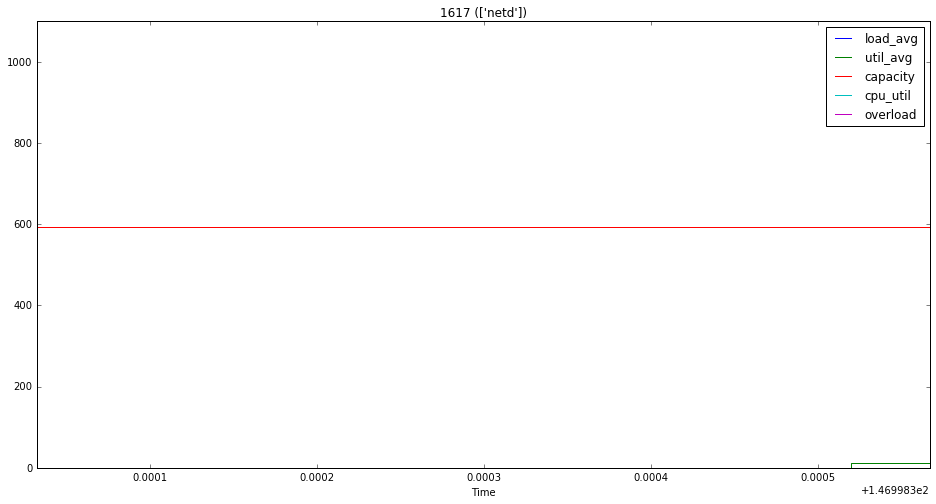

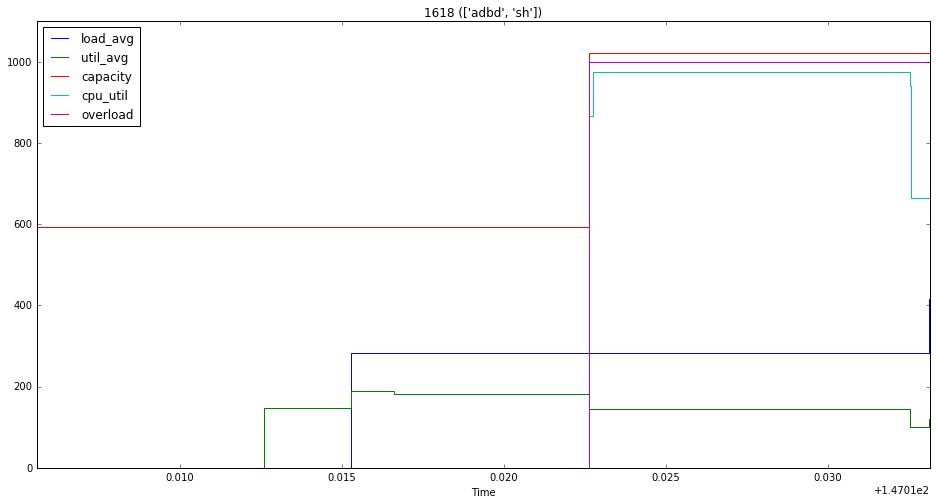

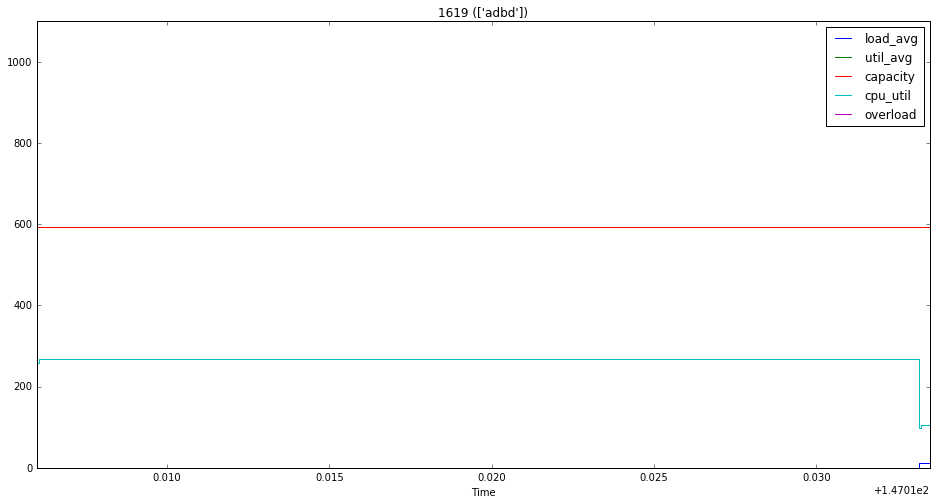

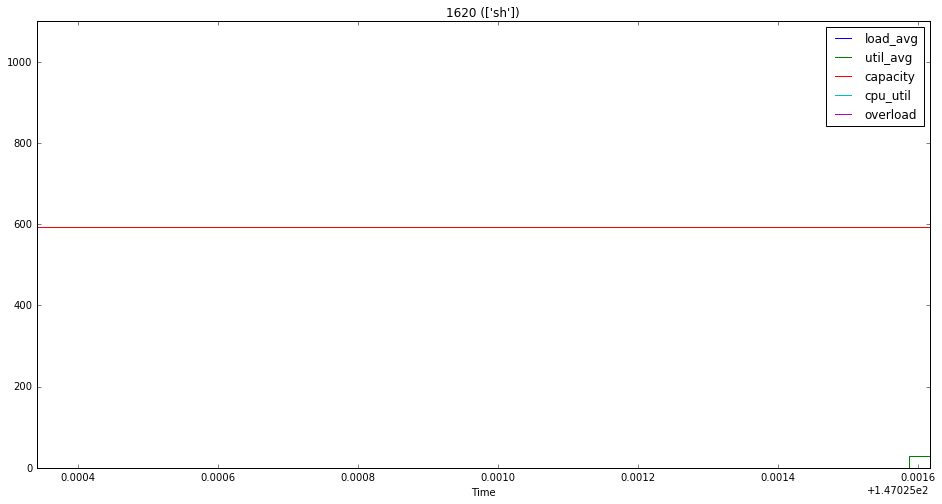

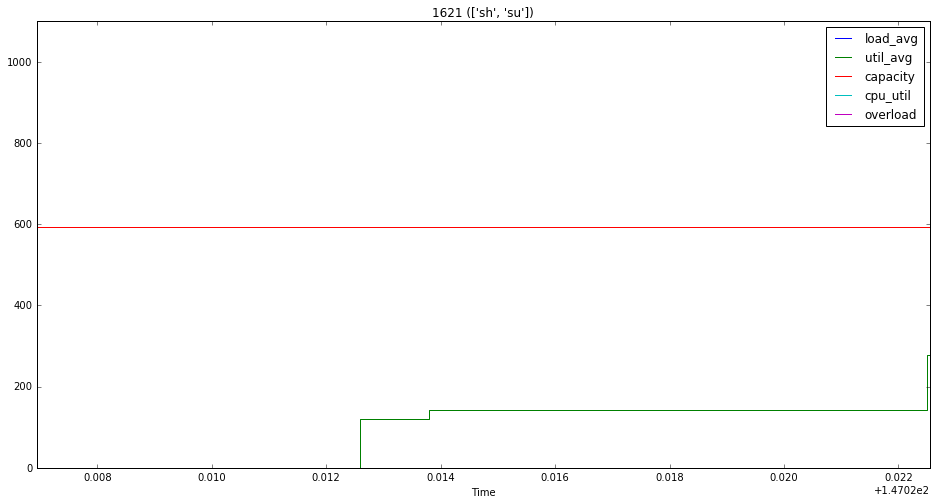

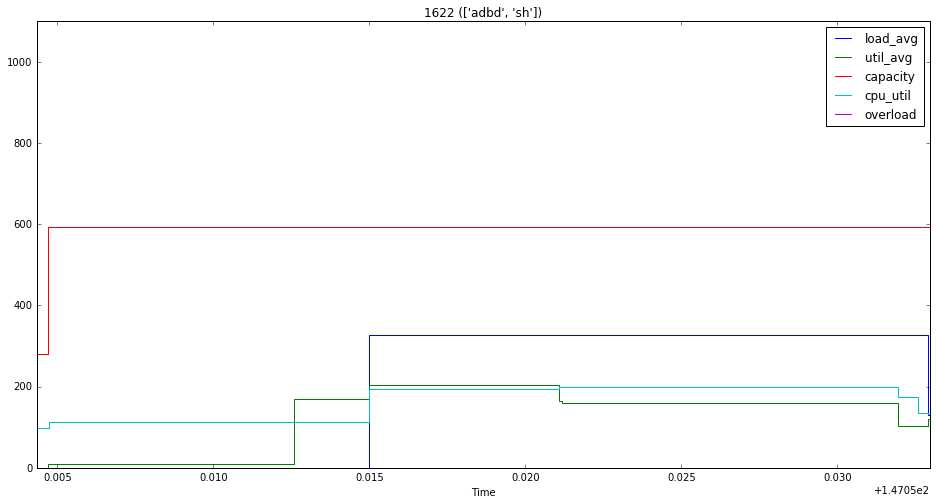

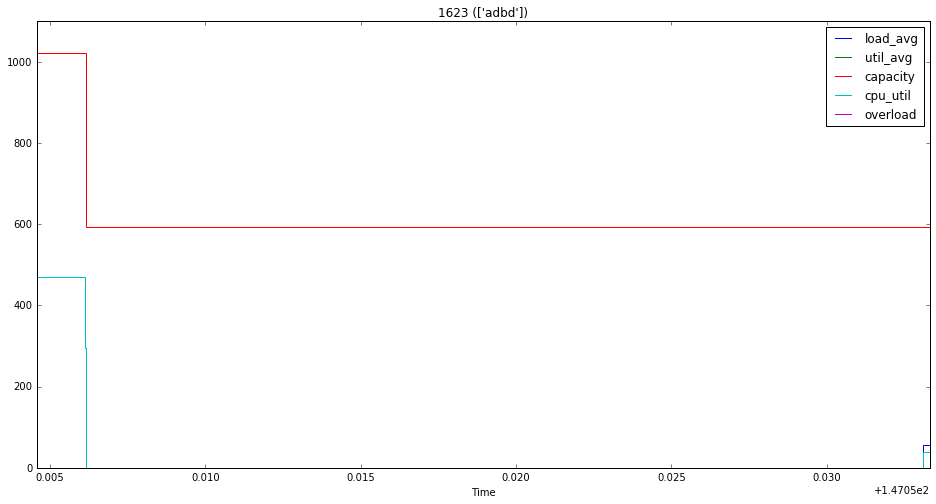

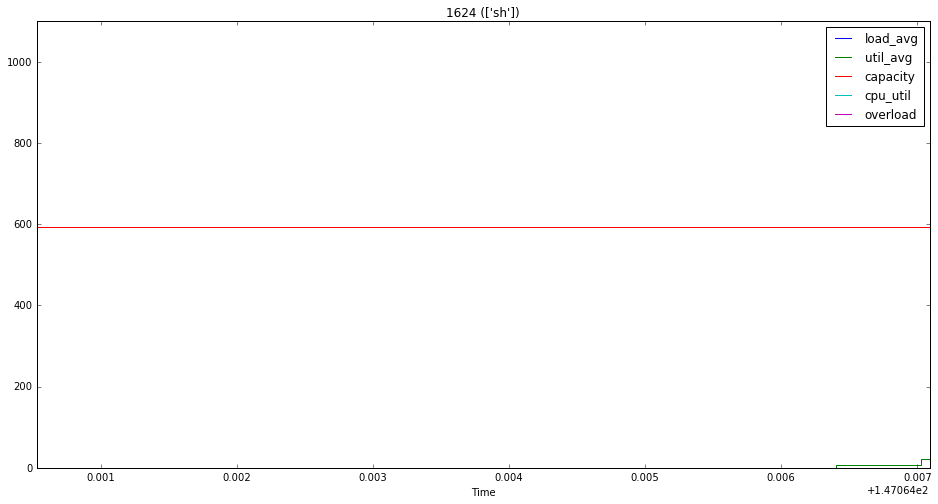

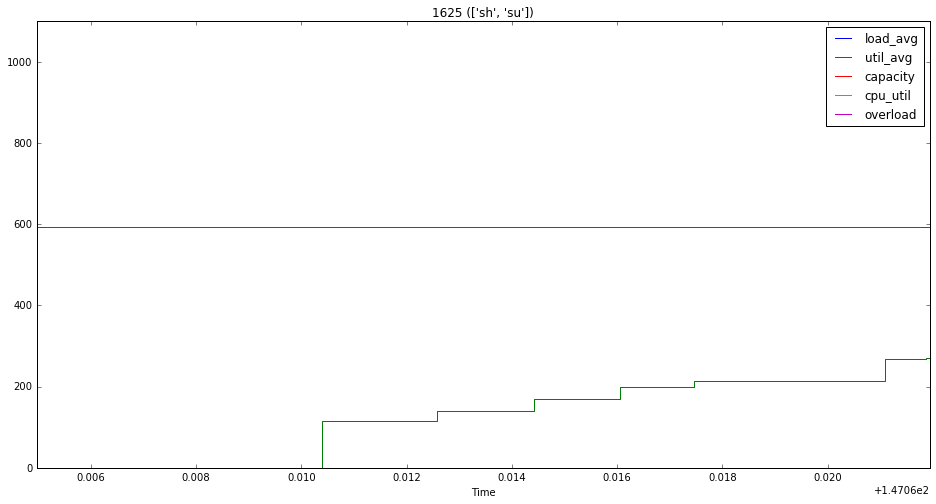

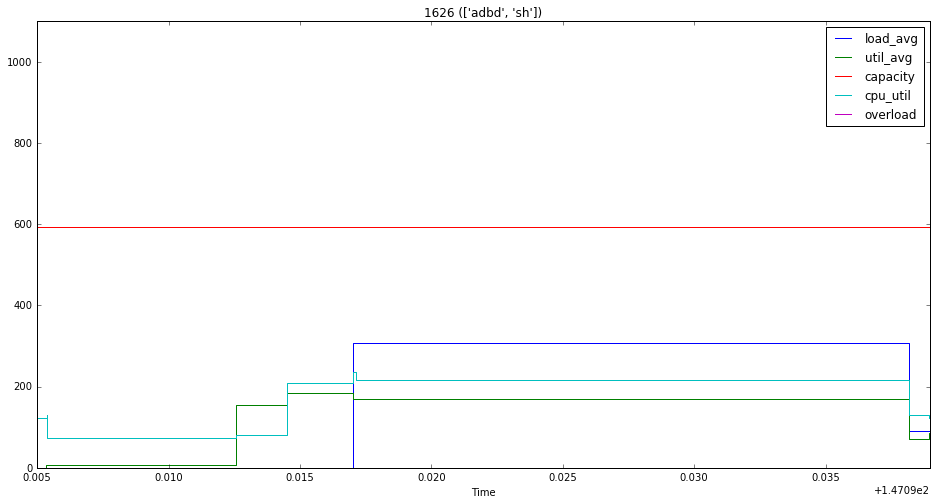

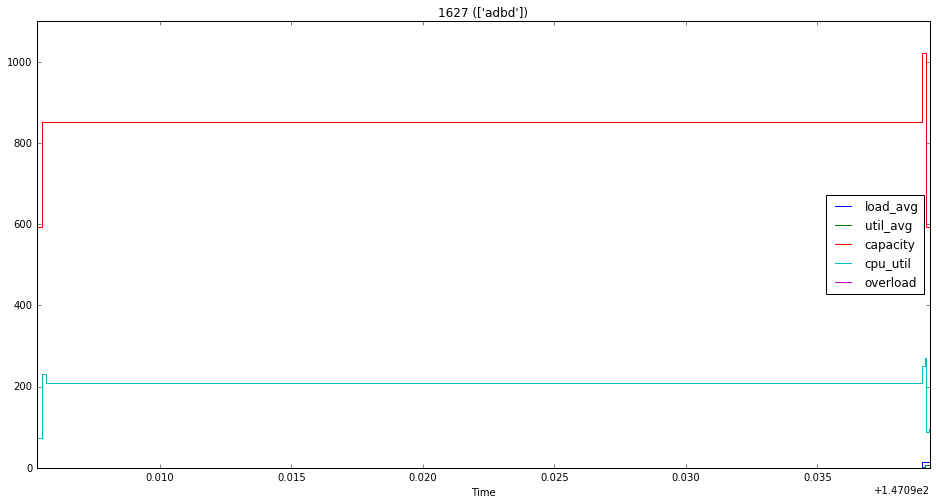

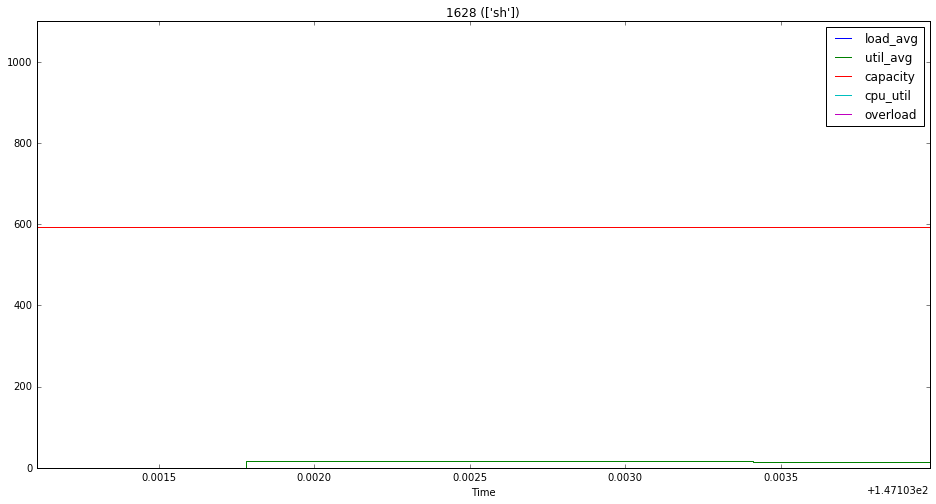

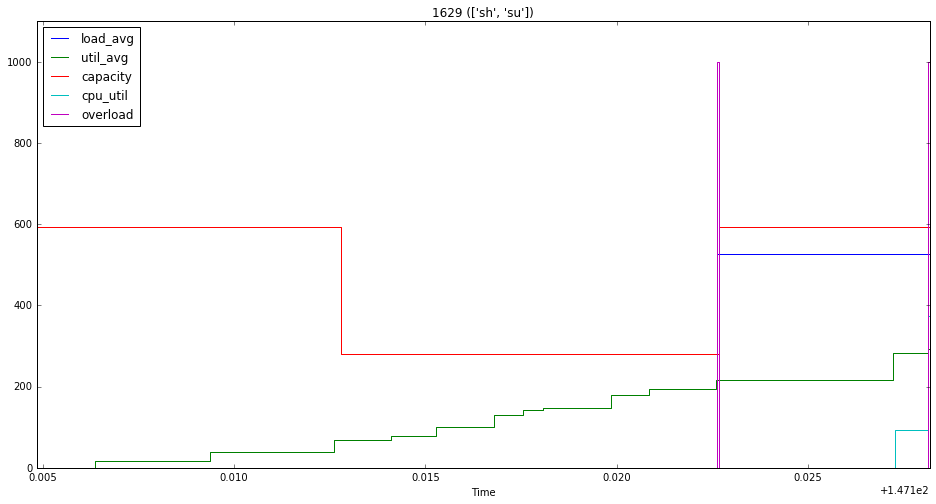

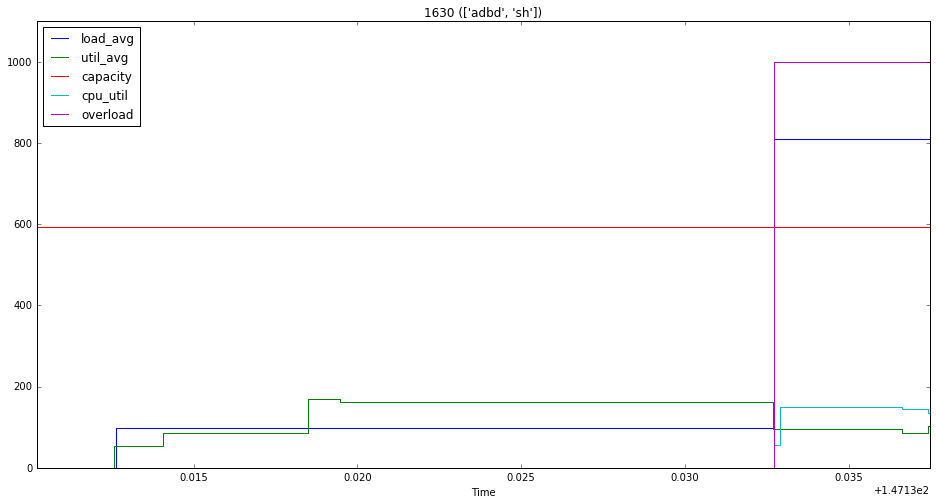

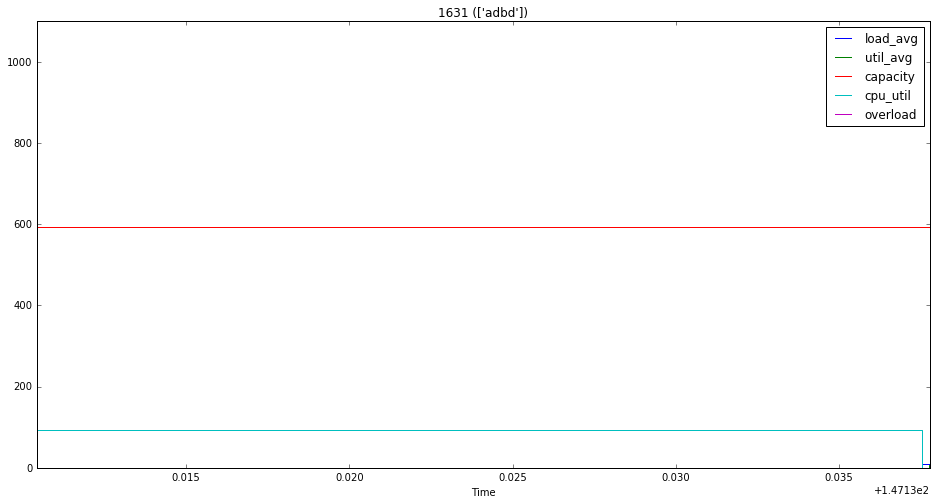

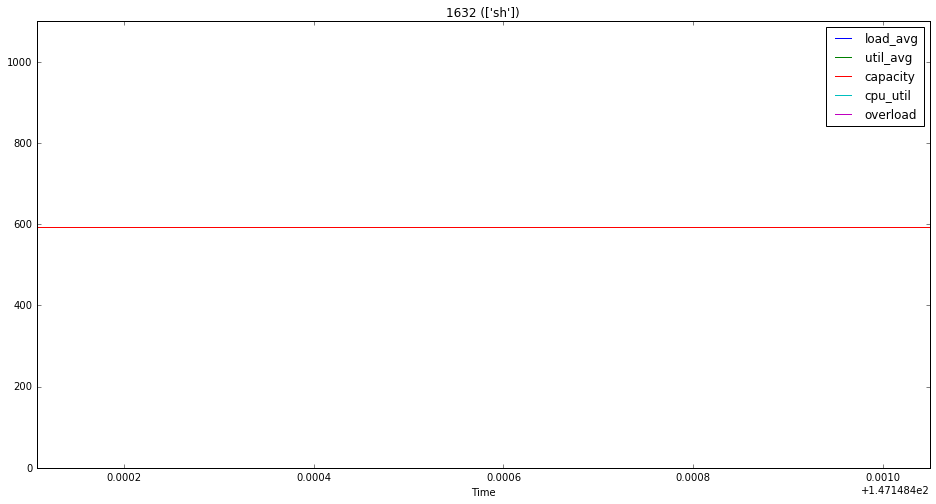

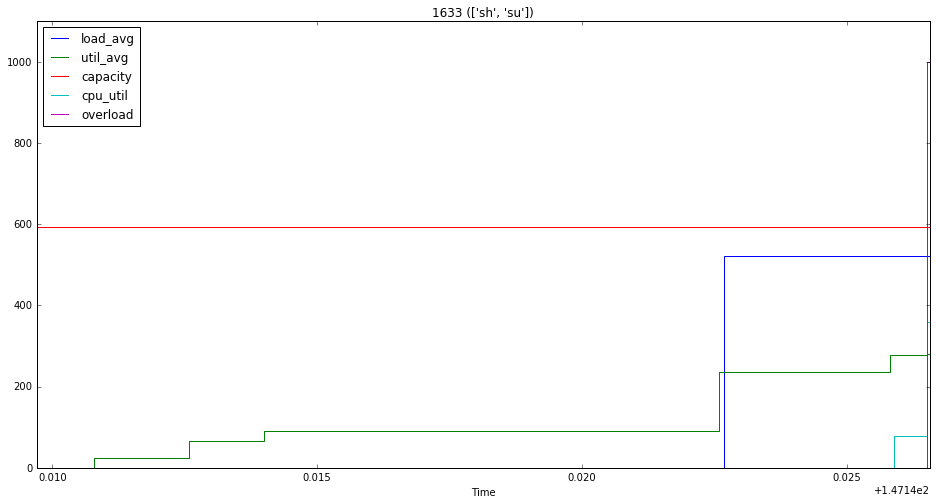

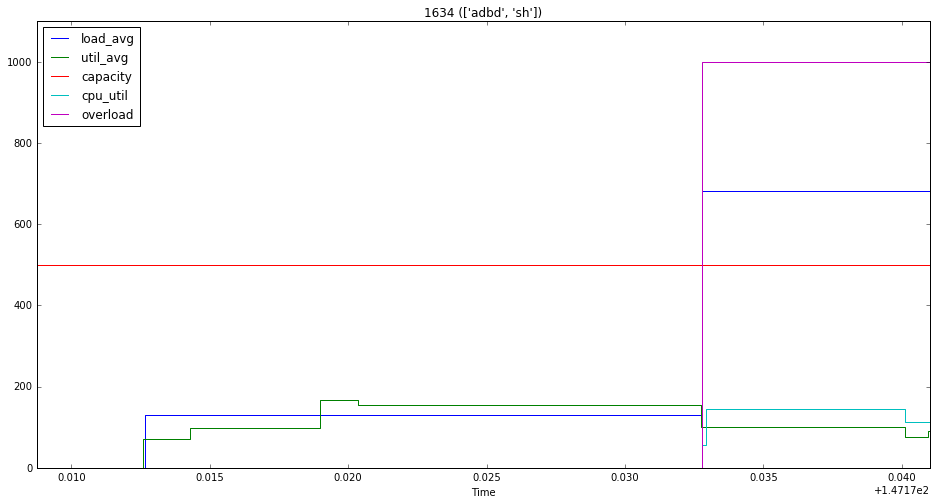

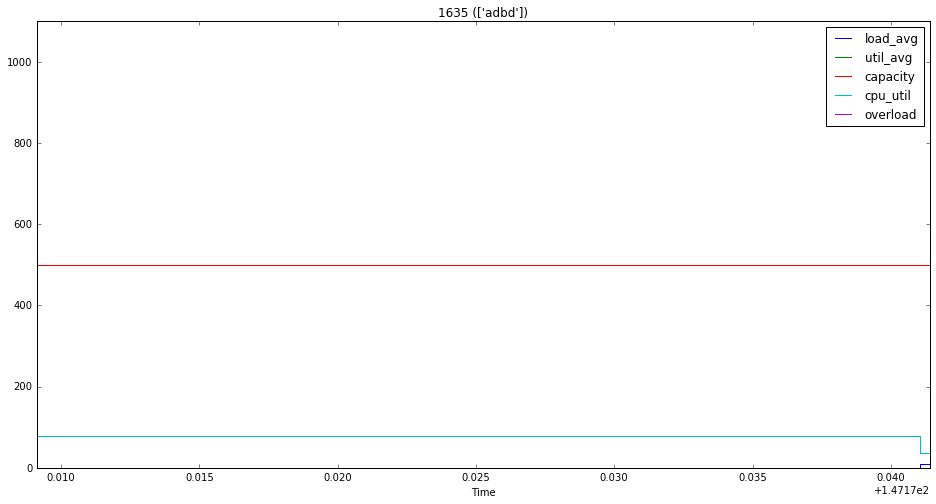

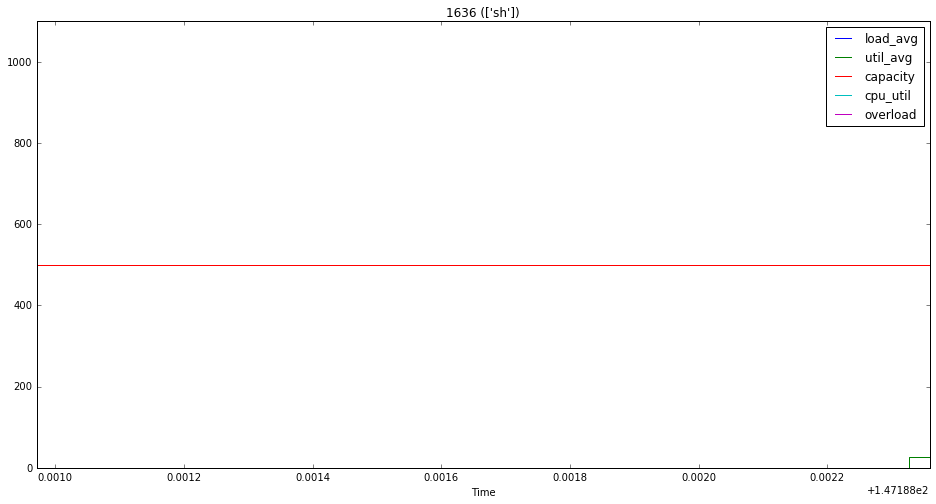

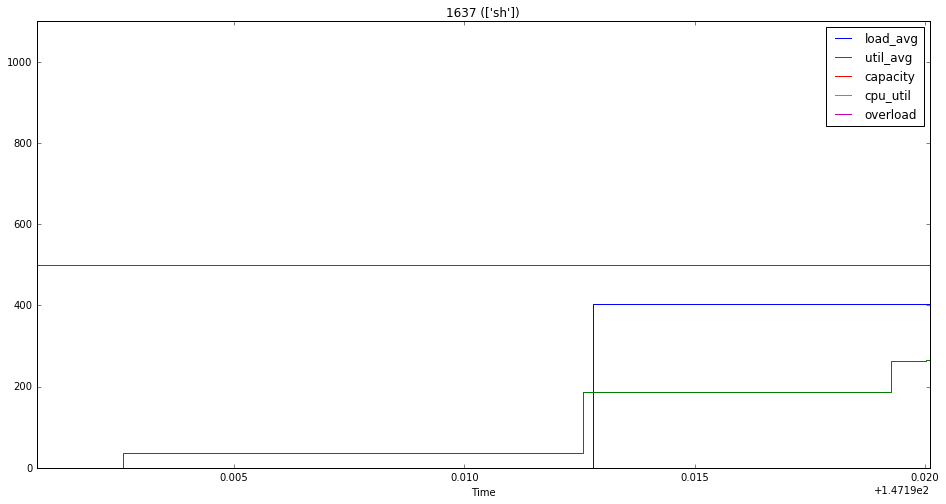

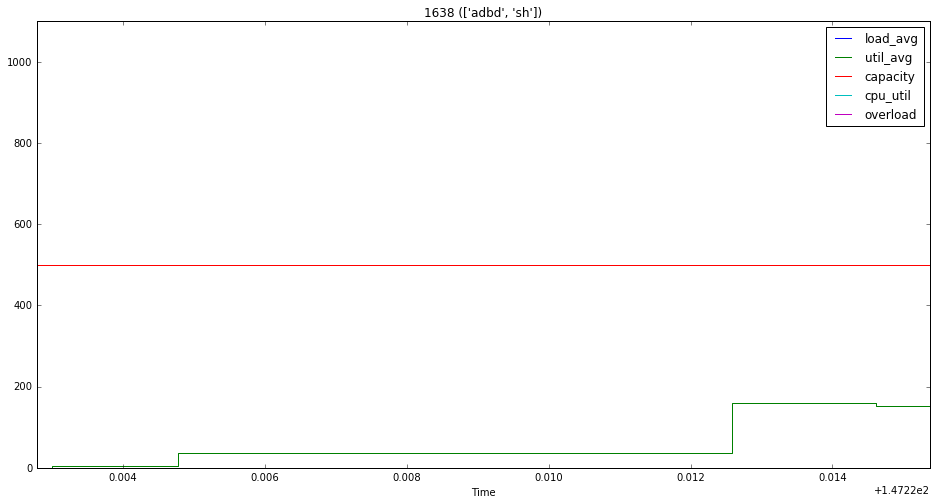

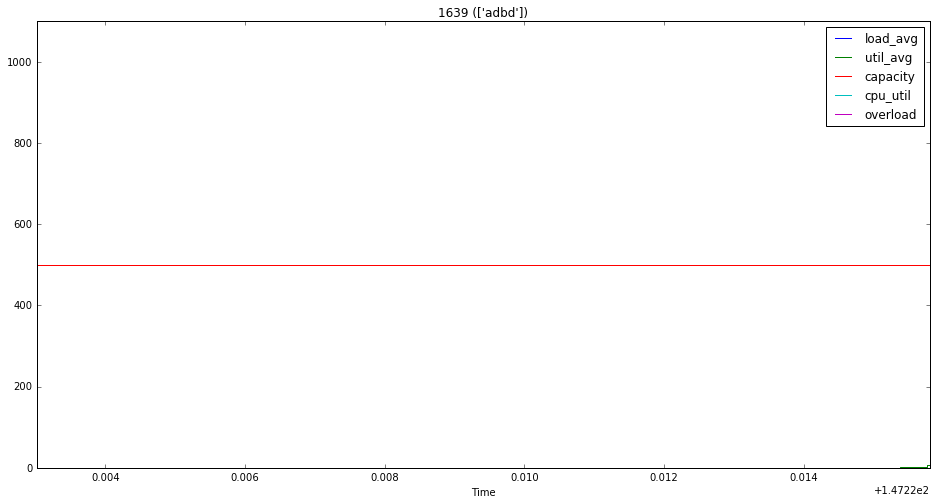

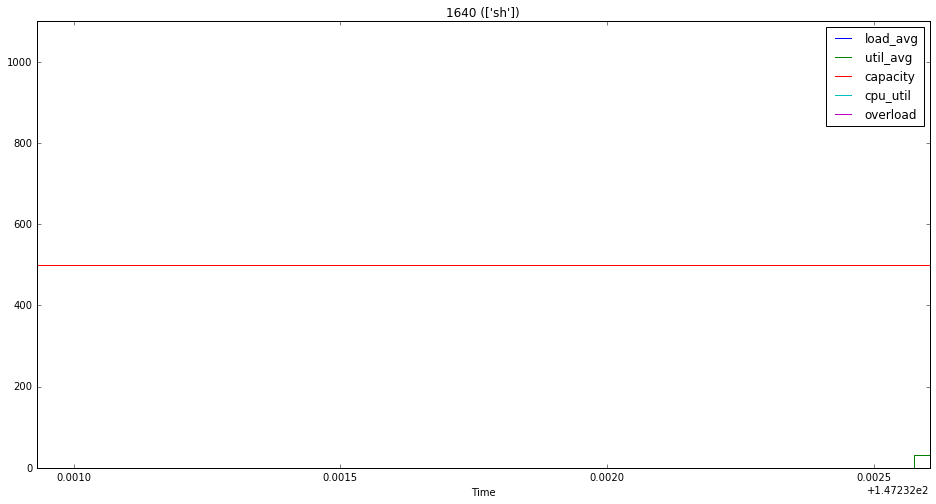

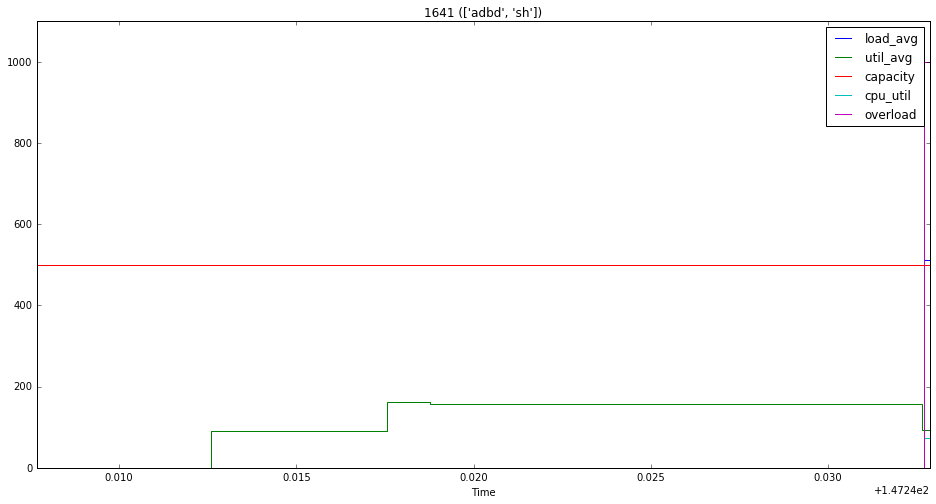

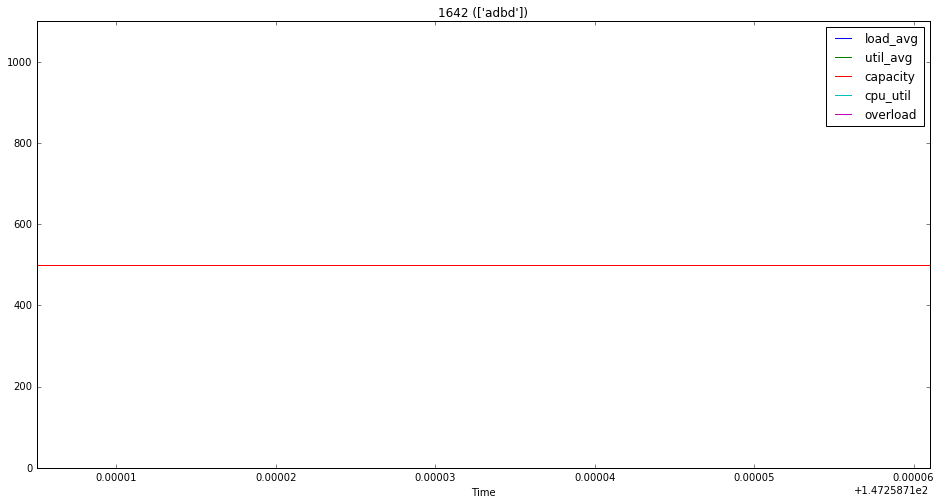

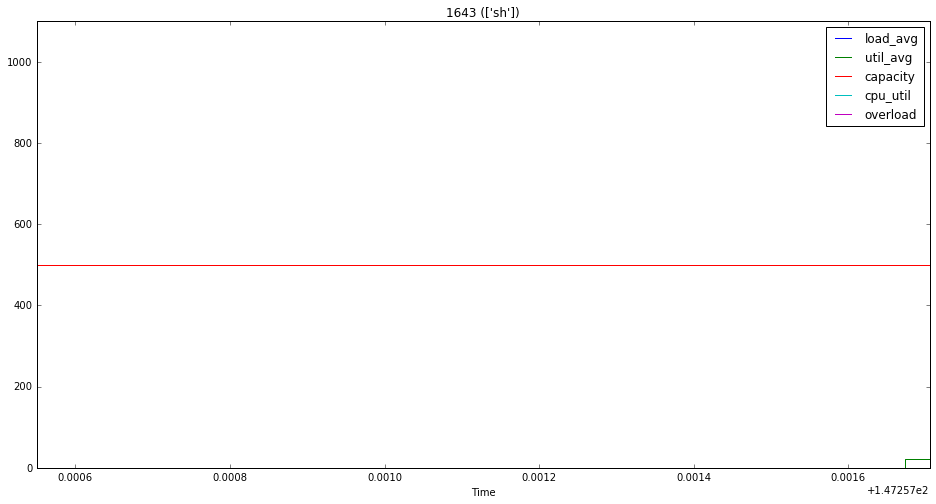

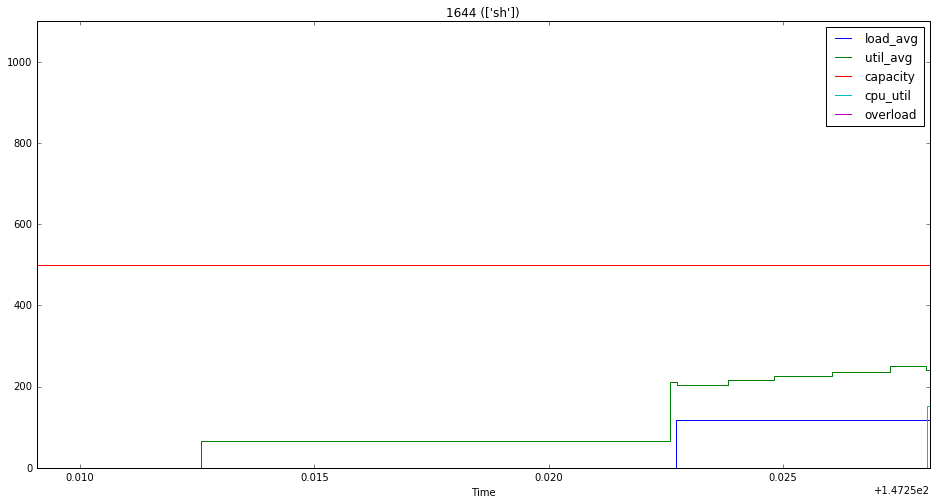

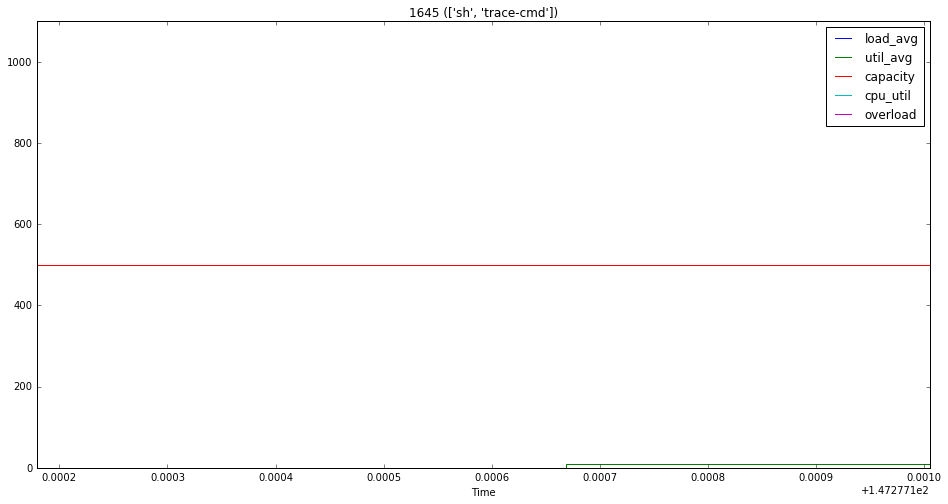

In [72]:
for pid in sorted(trace._tasks_by_pid):
    try:
        cap_df[cap_df['pid']==pid][['load_avg','util_avg', 'capacity', 'cpu_util', 'overload']].plot(drawstyle='steps-post', title='{} ({})'.format(pid, trace._tasks_by_pid[pid]), figsize=(16,8), ylim=(0,1100))
    except:
        pass

In [108]:
thread_activations={}
for pid in sorted(trace._tasks_by_pid):
    thread_activations[pid]=active_df.loc[(active_df['next_pid']==pid) | (active_df['prev_pid']==pid)].copy()

# now have a list of thread activations for each PID

In [149]:
pid=1596
if thread_activations[pid].iloc[0]['next_pid'] == pid:
    #start from beginning
    seq=thread_activations[pid].index
else:
    #skip first item
    seq=thread_activations[pid][1:].index

#thisplot = cap_df[cap_df['pid']==pid][['overload','load_avg','util_avg', 'capacity', 'cpu_util']].plot(
#    drawstyle='steps-post', title='{} ({})'.format(pid, trace._tasks_by_pid[pid]), xlim=(53.8,54), figsize=(16,8), ylim=(0,1100)
#    )#, set_dashes=seq)
on={}
on['time']=[]
on['on']=[]
on_val=0
for time in seq:
    if on_val==0:
        on_val=1
    else:
        on_val=0
    on['time'].append(time)
    on['on'].append(on_val)

new_df=pd.DataFrame(on)
new_df.index = new_df['time']
new_df.drop('time', axis=1, inplace=True)

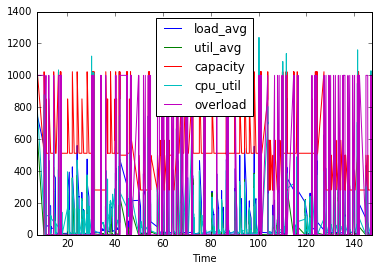

In [156]:
new_cap_df=cap_df[cap_df['pid']==pid].copy()
new_cap_df=new_cap_df[['load_avg','util_avg', 'capacity', 'cpu_util', 'overload']]
new_cap_df.plot()

In [167]:
# lookup in cpu load signals what a given CPU load is recorded as at any given time
def is_active(time, on_series):
    return on_series.iloc[on_series.index.get_loc(time, method='pad')]

def make_active_trace(row):
    global on_series
    time=row.name
    return row.cpu_util * is_active(time, on_series)

on_series = new_df
new_cap_df['cpu_util']=new_cap_df.apply(make_active_trace, axis=1)

KeyError: (7.1854170000000011, u'occurred at index 7.185417')

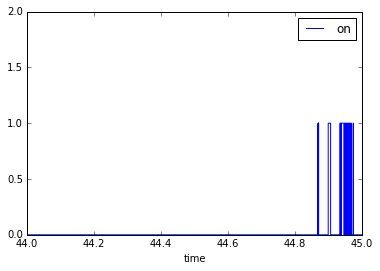

In [168]:
new_df.plot(drawstyle='steps-post', xlim=(44,45), ylim=(0,2))

In [70]:
active_df = trace.df('sched_switch').copy()


ERROR! Session/line number was not unique in database. History logging moved to new session 103


In [65]:
thread_activations={}
for pid in sorted(trace._tasks_by_pid):
    thread_activations[pid]=active_df.loc[(active_df['next_pid']==pid) | (active_df['prev_pid']==pid)].copy()

# now have a list of thread activations for each PID


In [92]:
pid=941
if thread_activations[pid].iloc[0]['next_pid'] == pid:
    #start from beginning
    seq=thread_activations[pid].index
else:
    #skip first item
    seq=thread_activations[pid][1:].index
seq
    

Float64Index([1.000663, 1.000689, 1.000746, 1.000777, 1.000821, 1.000943,
               1.00256, 1.002628, 1.002691, 1.126896,
              ...
              2.802551, 2.802651, 2.803121, 2.803206,  2.80373, 2.803784,
              2.804192, 2.804487, 2.805078,  2.80509],
             dtype='float64', name=u'Time', length=6271)

11:44:16  INFO    : Set plots time range to (0.000000, 147.278141)[s]
11:44:16  INFO    : 474 593 818 1023


IndexError: index out of range

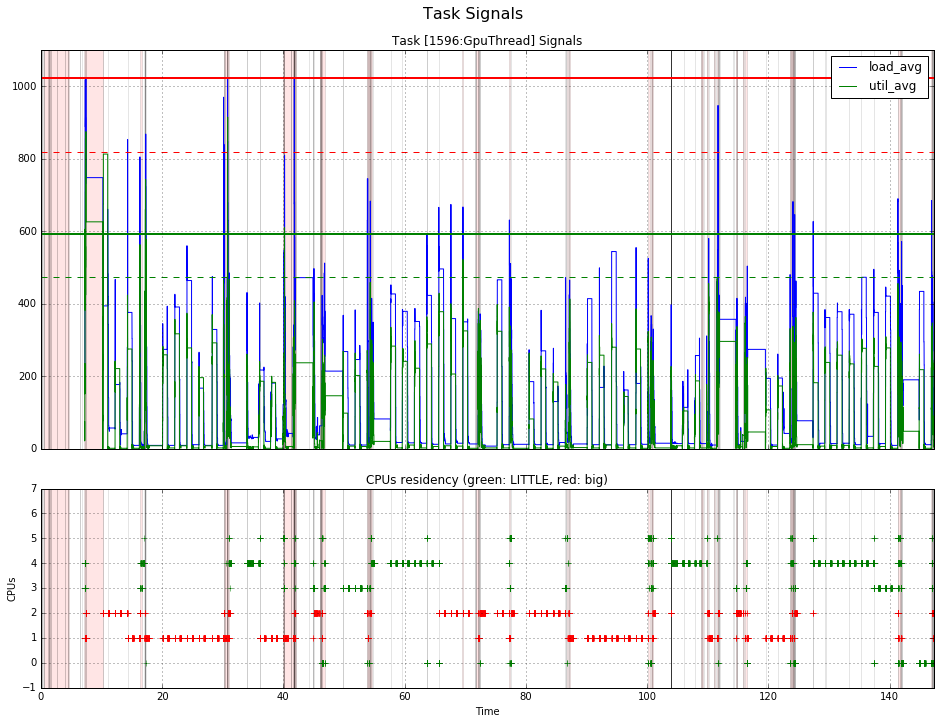

In [9]:
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output

# only want to see PIDs where there is a significant difference between WALT and PELT signal
walt_diff_target = 10000
task_list = []
df = trace.df('sched_load_avg_task').copy()
for pid in sorted(trace._tasks_by_pid):
    pid_df = df[df['pid']==pid]
    if pid_df.empty:
        continue
#    walt_max = pid_df.load_avg.max()
#    if walt_max < 700:
#        continue
    walt_diff = abs(pid_df.util_avg.sum() - pid_df.load_avg.sum())
    if walt_diff < walt_diff_target:
        continue
    task_list.append('{:05d},{}'.format(pid,trace._tasks_by_pid[pid][0]))

xmin=widgets.Text('-1', description='Xmin: (-1 to disable)')
xmax=widgets.Text('-1', description='Xmax: (-1 to disable)')

w = widgets.Dropdown(
    options=task_list,
    description='Tasks'
)
def show_report():
    global w, xmin, xmax
    clear_output()
    pid,taskname = w.value.split(',')
    _xmin=None
    _xmax=None
    if float(xmin.value) >= 0:
        _xmin = float(xmin.value)
    if float(xmax.value) >= 0:
        _xmax = float(xmax.value)
    ta.setXTimeRange(_xmin, _xmax)
    ta.plotTasks([pid,], ['load_avg', 'util_avg', 'util_est', 'sched_overutilized', 'residencies'])
    #ta.plotCPU()
    print '\'{}\'=pid \'{}\'=taskname'.format(pid, taskname)

def clicked(b):
    show_report()

def reset(b):
    global xmin,xmax
    xmin.value=-1
    xmax.value=-1
    show_report()

#behaviours
w.on_trait_change(show_report, 'value')
button1=widgets.Button(description='Reset')
button1.on_click(reset)
button=widgets.Button(description='Redraw')
button.on_click(clicked)

display(xmin)
display(xmax)
display(button1)
display(button)
display(w)


In [10]:


print getCPUCapacity(1, 10.0)


511.5


In [ ]:
df = trace.df('sched_overutilized').copy()
df[['overutilized']].plot(drawstyle='steps-post', figsize=(16,8), ylim=(-1,2))

In [ ]:
interesting_pids=None
walt_diff_target=0
pid_list={}
pids_in_trace=tasks_by_pid.keys()

df = trace.df('sched_load_avg_task').copy()
if 'walt_demand' not in df.columns:
    df.rename(columns = {'load_avg':'walt_demand'}, inplace = True)

# PID list filtering:
#   if you want to limit the list of PIDs, put them in 'interesting_pids'
#interesting_pids=[ 1535, 1591, 415, 1589, 1596, 1587 ]
#   if you want to ignore tasks with little difference, set a limit here
walt_diff_target = 10000
for pid in pids_in_trace:
    if interesting_pids and not pid in interesting_pids:
        print 'Skipping {} as not one of our \'interesting\' PIDs'.format(pid)
        continue
    pid_df = df[df['pid']==pid]
    if pid_df.empty:
        print '{} empty'.format(pid)
        continue
    walt_diff = abs(pid_df.util_avg.sum() - pid_df.walt_demand.sum())
    if walt_diff < walt_diff_target:
        print 'Skipping {} as difference between walt and pelt is only {}'.format(pid, walt_diff)
        continue
    pid_list[pid] = walt_diff

for pid in sort(pid_list.keys()):
    pid_df = df[df['pid']==pid]
    pid_title='PID {} ({}). Walt_diff={}'.format(pid, trace.getTaskByPid(pid), pid_list[pid])
    pid_df[['util_avg', 'walt_demand', 'util_est']].plot(drawstyle='steps-post', title=pid_title, ylim=(0,1100), figsize=(16,8))



In [ ]:
# just one plot for a given pid
pid=1589
start=77
end=78


pid_df = df[df['pid']==pid].copy()
# add frequencies & overutilised
df_little_freqs = df_little[['frequency']].apply(lambda x: (platform['nrg_model']['little']['cpu']['cap_max']*x)/max(platform['freqs']['little'])).rename(columns={'frequency':'littleFreq'})
df_big_freqs = df_big[['frequency']].apply(lambda x: (platform['nrg_model']['big']['cpu']['cap_max']*x)/max(platform['freqs']['big'])).rename(columns={'frequency':'bigFreq'})
pid_title='PID {} ({}). Walt_diff={}'.format(pid, trace.getTaskByPid(pid), pid_list[pid])
#pid_df[['util_avg', 'walt_demand', 'util_est', 'littleFreq']].plot(drawstyle='steps-post', title=pid_title, figsize=(16,8))
#df_big_freqs.plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), ylim=(0,1100))
tmp_df=pd.concat([pid_df, df_little_freqs, df_big_freqs])
#tmp_df.plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), ylim=(0,1100))
tmp_df[['util_avg', 'walt_demand', 'util_est']].plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), xlim=(start,end))
tmp_df[['littleFreq', 'bigFreq']].plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), xlim=(start,end))



In [ ]:
df = trace.df('sched_load_avg_cpu').copy()
#if 'walt_demand' not in df.columns:
#    df.rename(columns = {'load_avg':'walt_demand'}, inplace = True)

#for pid in pids_in_trace:
#    pid_df = df[df['pid']==pid].copy()
#    if pid_df.empty:
#        continue
#    if pid_df.util_avg.sum() < 500000:
#        continue
for cpu in range(0,5):
    cpu_df = df[df['cpu']==cpu].copy()
    pid_title='Examining CPU {}'.format(cpu)
    #cpu_df[['util_avg', 'util_est']].plot(drawstyle='steps-post', title=pid_title, ylim=(0,1100), figsize=(16,8), xlim=(43.05,43.10))
    cpu_df[['util_avg', 'util_est']].plot(drawstyle='steps-post', title=pid_title, ylim=(0,1100), figsize=(16,8))
